In [607]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data
from tensorflow.keras.utils import register_keras_serializable

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [608]:
from tensorflow.keras import layers, models

# Procedurally generated training data
The code below demonstrates how to generate training videos and labels. The function also returns the ground truth particle tracks, which might also be useful depending on your goals.

Note that the training generator is a Tensorflow Module and can be easily incorperated into a Tensorflow neural network. Alternatively, you could simply save a large set of data and use another machine learning framework.

Note that the image dimension is fixed at 256x256. The labels are downsampled to 128x128 in the image dimensions. There are two classes (a particle is detected or not detected) per label so the label shape is 128x128x2. Hence, the neural network output should be 128x128x2.

### Our paper
https://www.pnas.org/content/115/36/9026.short

In [609]:
Nt = 50 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

In [610]:
tracks[0]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[ 52.471115 , 105.78137  , -19.548386 ],
       [115.7619   ,  -4.292328 ,  10.836426 ],
       [ 83.42096  , 127.36429  ,  21.119339 ],
       [249.06299  , 153.45361  , -29.884617 ],
       [ 28.210358 , 159.89815  , -19.702225 ],
       [256.9126   ,  -3.2355042, -20.274506 ],
       [253.5748   ,  99.39935  ,   6.655464 ],
       [171.70587  , 234.74275  ,  23.827324 ],
       [219.36443  ,  21.235718 ,  25.799042 ],
       [ 57.180832 , 172.88219  ,  27.567352 ]], dtype=float32)>

## Visualizing training videos and labels

In [604]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=49), Checkbox(value=True, description='show_trac…

In [605]:
tracks[0]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[ 69.06746  , 168.53479  ,  13.309196 ],
       [133.23521  , 189.85901  ,  17.174622 ],
       [222.50795  , 165.56575  ,  13.147999 ],
       [ 17.38707  , 111.35788  , -24.072987 ],
       [ 60.343475 , 254.64032  , -11.177063 ],
       [175.63806  , 243.50124  , -10.990158 ],
       [143.53142  ,  39.42659  ,  25.738564 ],
       [206.80115  , 191.04048  ,  15.566868 ],
       [ 73.63049  , 178.13043  ,  -7.1612587],
       [101.47423  , 155.22926  ,   4.8605576]], dtype=float32)>

### Particle tracks

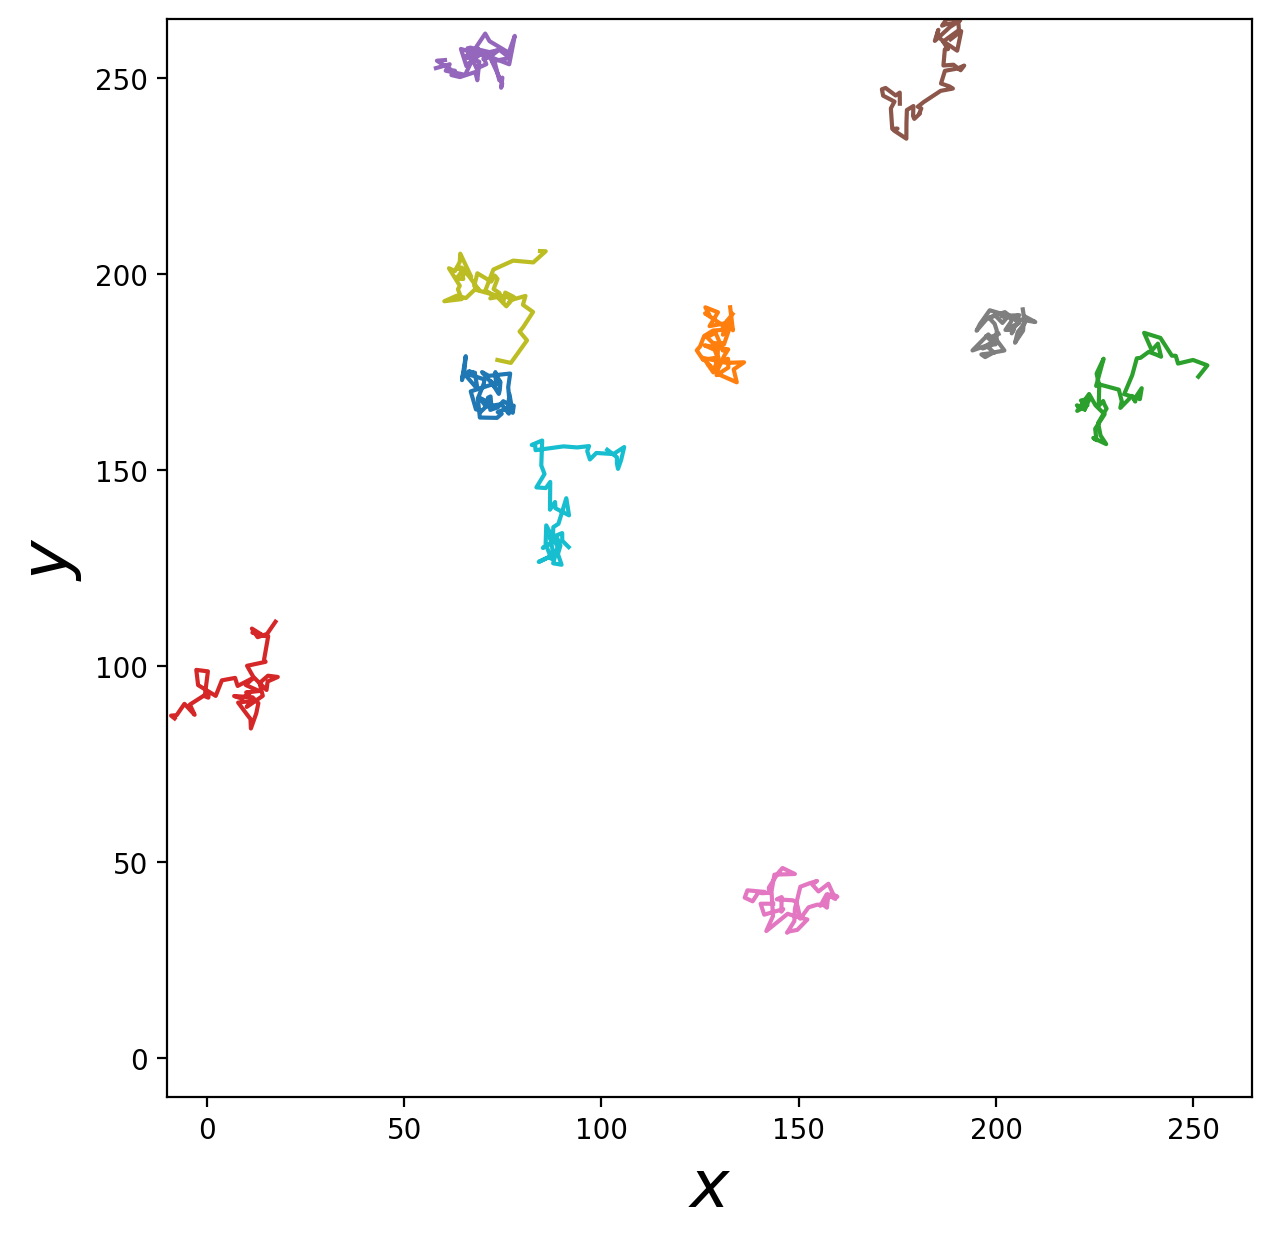

In [606]:
figure(1, [7, 7])
plot(tracks[..., 0], tracks[..., 1])
xlim(-10, 265)
ylim(-10, 265)

xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

# Goal 1: Design and train a convolutional neural network using the training data generator

In [488]:
# def training_data_generator(batch_size, Nt, kappa, a, IbackLevel, Nparticles, sigma_motion):
#     pt = Particle_Tracking_Training_Data(Nt)
#     while True:
#         batch_features = []
#         batch_labels = []
#         batch_tracks = []
#         for _ in range(batch_size):
#             vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)
#             batch_features.append(vid)
#             batch_labels.append(labels)
#             batch_tracks.append(tracks)
#         yield np.array(batch_features), np.array(batch_labels)
#         #, np.array(batch_tracks)

In [489]:
# Define the CNN model
from tensorflow.keras import layers, models

def create_particle_tracking_model(input_shape=(256, 256, 1), output_shape=(128, 128, 2)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample to 128x128
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample to 64x64
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample to 32x32
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),  # Upsample to 64x64
        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),  # Upsample to 128x128
        layers.Conv2D(output_shape[2], (1, 1), activation='softmax', padding='same')
    ])
    return model

model = create_particle_tracking_model()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [490]:
# Generate a video
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

In [491]:
# Define loss function
@register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    """
    Weighted binary crossentropy loss, where the weight for class 1 (particles)
    is 300 times the weight for class 0 (background).
    """
    # Define weight
    weight_for_0 = 1.0 
    weight_for_1 = 300.0 
    
    # Compute weight tensor, with the same shape as y_true
    weights = tf.where(tf.equal(y_true[..., 1], 1), weight_for_1, weight_for_0)
    
    # Calculate binary crossentropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply weights
    weighted_bce = weights * bce
    
    # Return the mean of the weighted loss
    return tf.reduce_mean(weighted_bce)

In [492]:
# Then use this custom loss function when compiling the model
model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(vid, labels, epochs=10, validation_split=0.2)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 583ms/step - accuracy: 0.2583 - loss: 68.7802 - val_accuracy: 0.2634 - val_loss: 41.5998
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step - accuracy: 0.2634 - loss: 30.4425 - val_accuracy: 0.6152 - val_loss: 6.9103
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step - accuracy: 0.6241 - loss: 5.8415 - val_accuracy: 0.7464 - val_loss: 2.7136
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step - accuracy: 0.7704 - loss: 2.4521 - val_accuracy: 0.4711 - val_loss: 1.5655
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 524ms/step - accuracy: 0.4787 - loss: 1.4614 - val_accuracy: 0.9584 - val_loss: 1.1553
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step - accuracy: 0.9516 - loss: 1.0707 - val_accuracy: 0.8505 - val_loss: 0.8956
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step - accuracy: 0.8724 - loss: 0.8520 - val_accuracy: 0.9512 - val_loss: 0.6346
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.9571 - loss: 0.6388 - val_accuracy: 0.9184 - val_lo

In [18]:
# Use more video to train the model
num_videos = 10
for i in range(num_videos):
    vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)
    model.fit(vid, labels, batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 540ms/step - accuracy: 0.9829 - loss: 0.3546 - val_accuracy: 0.9818 - val_loss: 0.1291
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - accuracy: 0.9828 - loss: 0.0801 - val_accuracy: 0.9831 - val_loss: 0.1291
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step - accuracy: 0.9839 - loss: 0.0733 - val_accuracy: 0.9831 - val_loss: 0.1267
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/step - accuracy: 0.9839 - loss: 0.0687 - val_accuracy: 0.9840 - val_loss: 0.1342
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 520ms/step - accuracy: 0.9846 - loss: 0.0656 - val_accuracy: 0.9844 - val_loss: 0.1377
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/step - accuracy: 0.9851 - loss: 0.0648 - val_accuracy: 0.9844 - val_loss: 0.1385
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - accuracy: 0.9851 - loss: 0.0624 - val_accuracy: 0.9853 - val_loss: 0.1517
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.9858 - loss: 0.0606 - val_accuracy: 0.9848 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 651ms/step - accuracy: 0.9837 - loss: 0.0802 - val_accuracy: 0.9829 - val_loss: 0.1932
Epoch 14/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - accuracy: 0.9838 - loss: 0.0842 - val_accuracy: 0.9836 - val_loss: 0.1937
Epoch 15/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 596ms/step - accuracy: 0.9849 - loss: 0.0749 - val_accuracy: 0.9809 - val_loss: 0.1178
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 0.9638 - loss: 0.2493 - val_accuracy: 0.9878 - val_loss: 3.8080
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 596ms/step - accuracy: 0.9428 - loss: 2.5207 - val_accuracy: 0.9850 - val_loss: 0.0691
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step - accuracy: 0.9789 - loss: 0.1273 - val_accuracy: 0.9771 - val_loss: 0.0660
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 606ms/step - accuracy: 0.9731 - loss: 0.0808 - val_accuracy: 0.9811 - val_loss: 0.0594
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 629ms/step - accuracy: 0.9768 - loss: 0.0782 - val_accuracy: 0.9823 - val_loss: 0.0580
E

In [21]:
model.save('model2.keras')

In [493]:
from tensorflow.keras.models import load_model

model = load_model('model1.keras')

# model = load_model('model1.keras', compile=False)  # 加载模型，不编译
# model.compile(optimizer='rmsprop', loss='weighted_binary_crossentropy')  # 重新配置优化器和损失函数

/Users/yuanhaowen/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [494]:
# # Test samples
# test_vid, test_labels, test_tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

# # Model performance
# loss, accuracy = model.evaluate(test_vid, test_labels)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

In [495]:
# Test samples
test_vid, test_labels, test_tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

# Visualizing testing videos and labels
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(test_vid[t], origin='lower')
    if show_tracks:
        plot(test_tracks[t, :, 0], test_tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(test_vid[t], origin='lower')
    imshow(test_labels[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=49), Checkbox(value=True, description='show_trac…

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


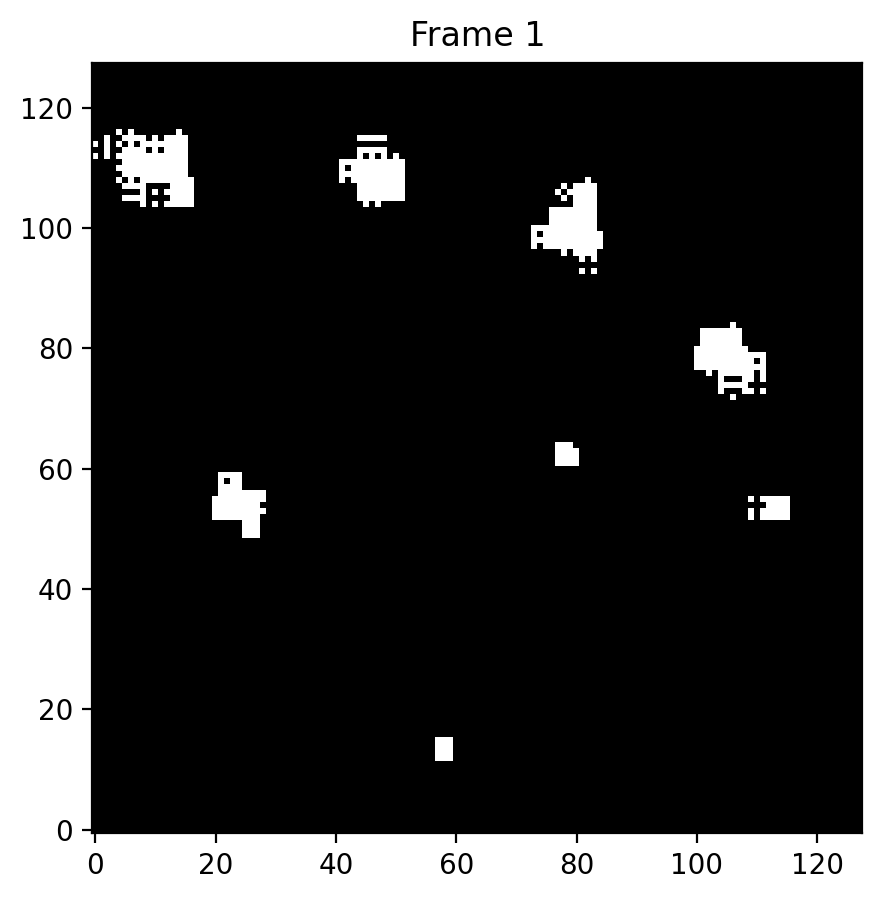

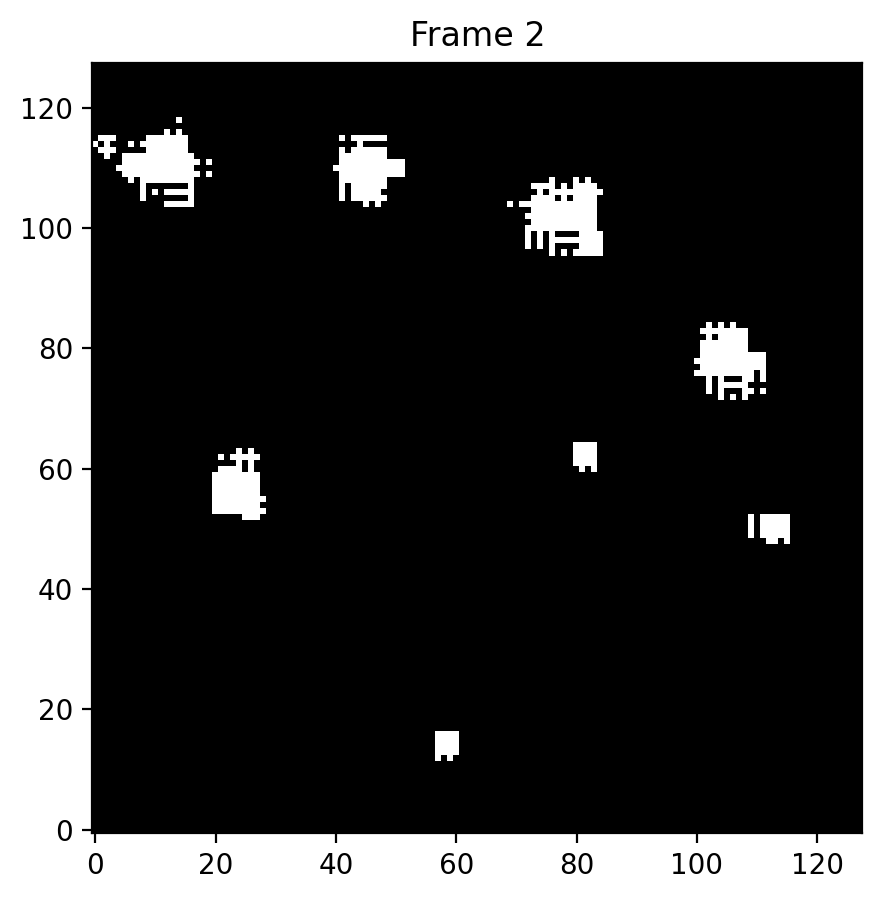

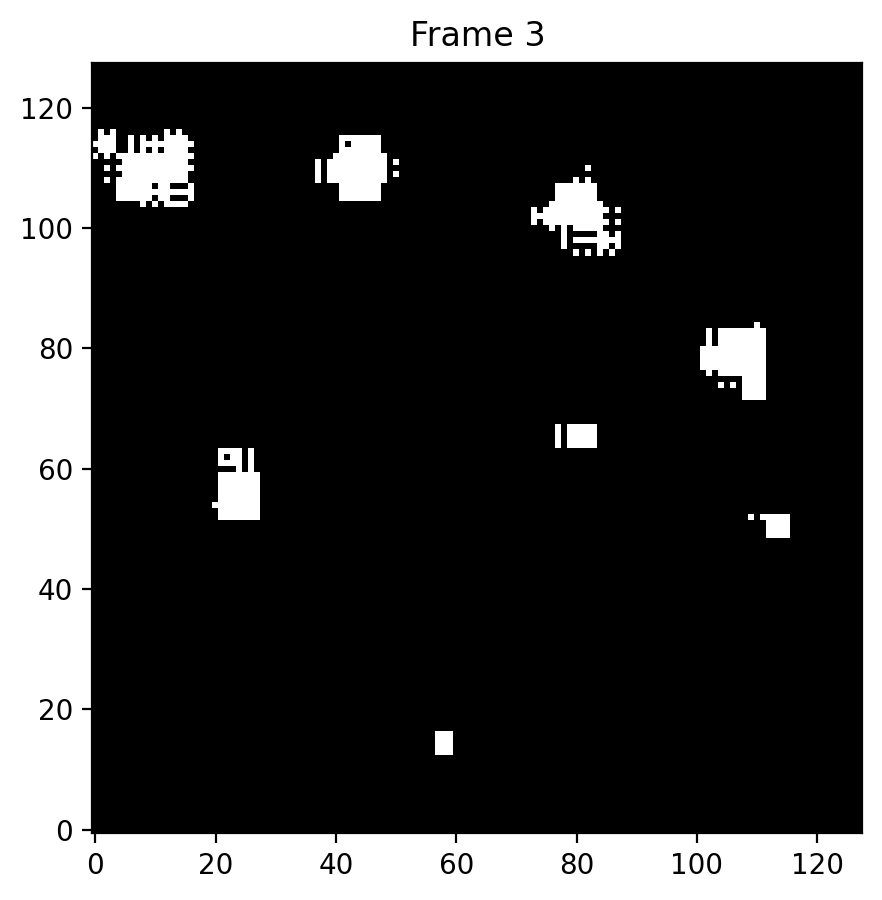

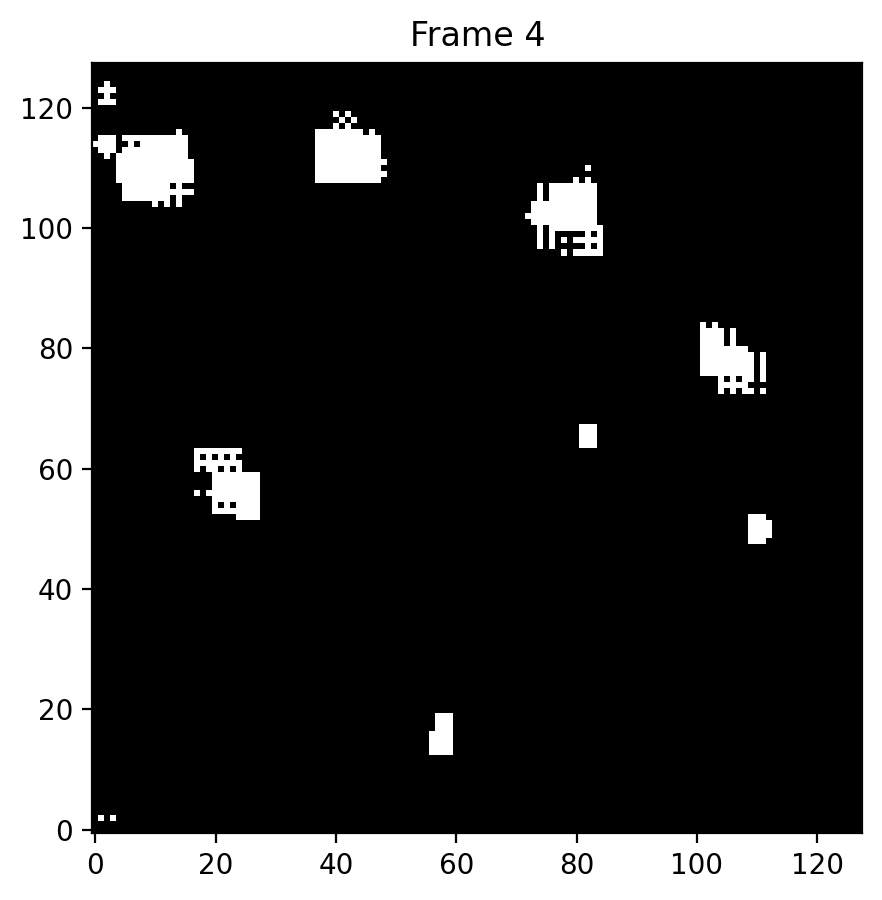

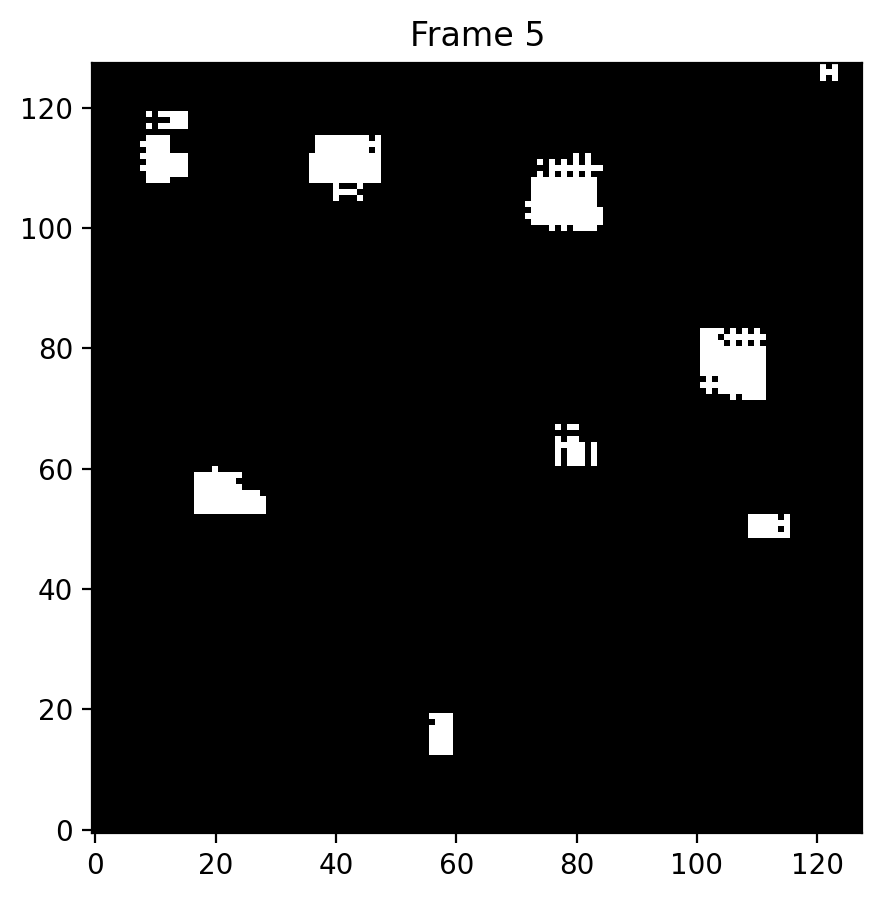

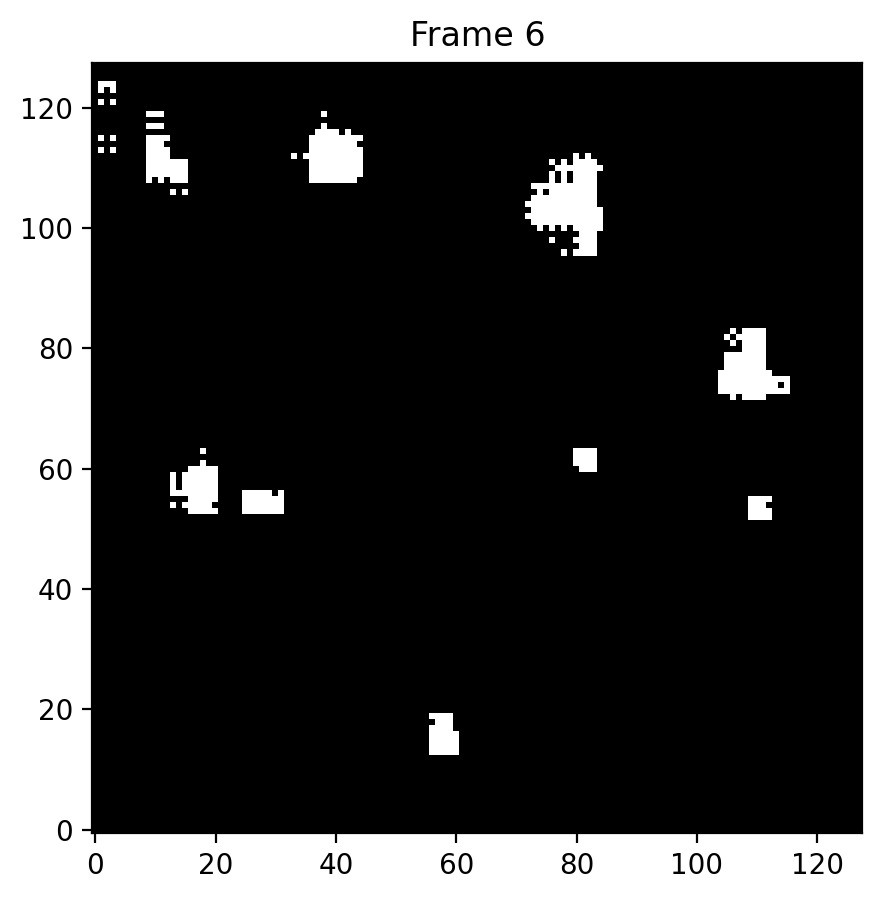

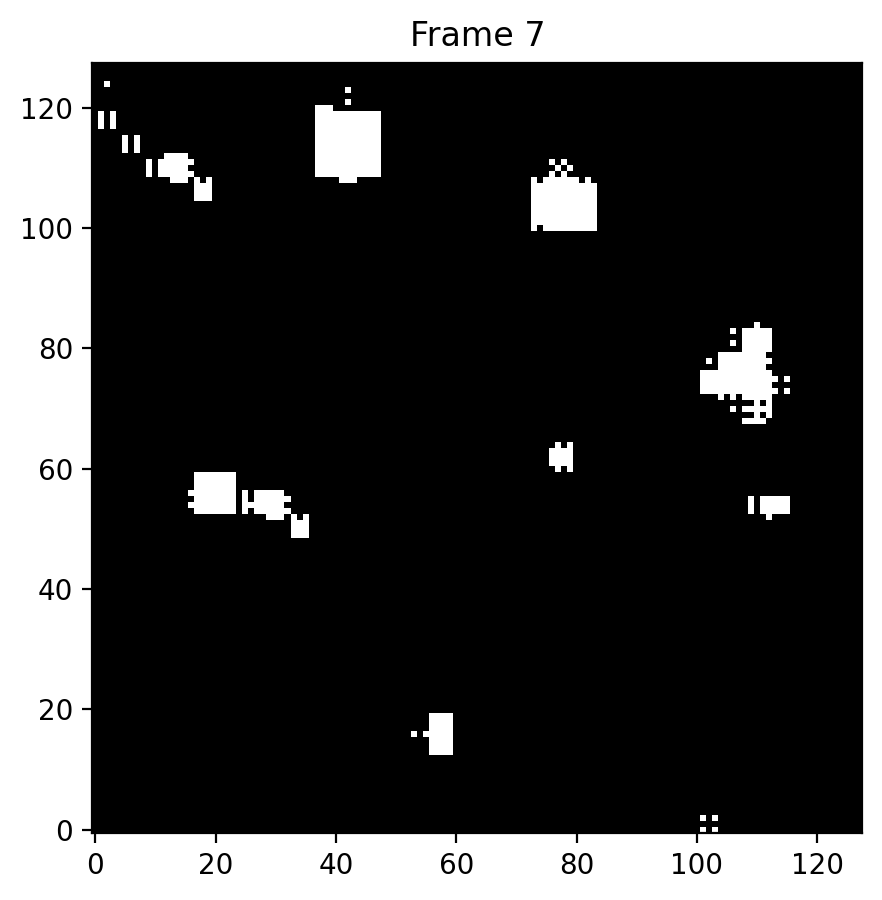

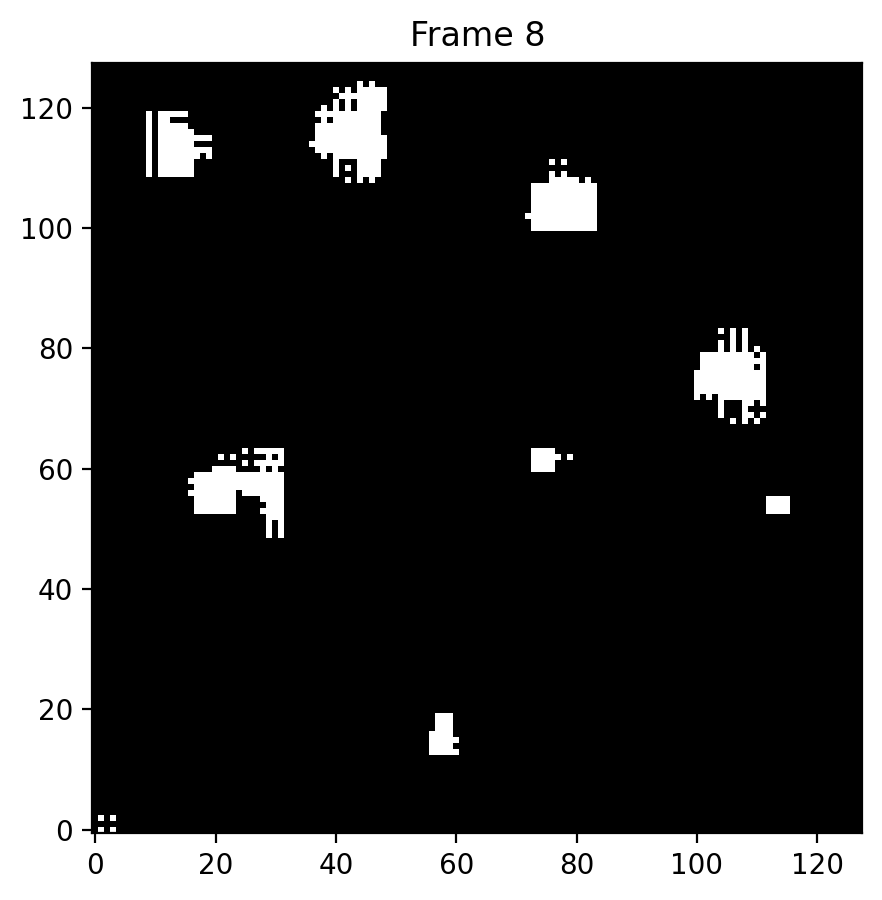

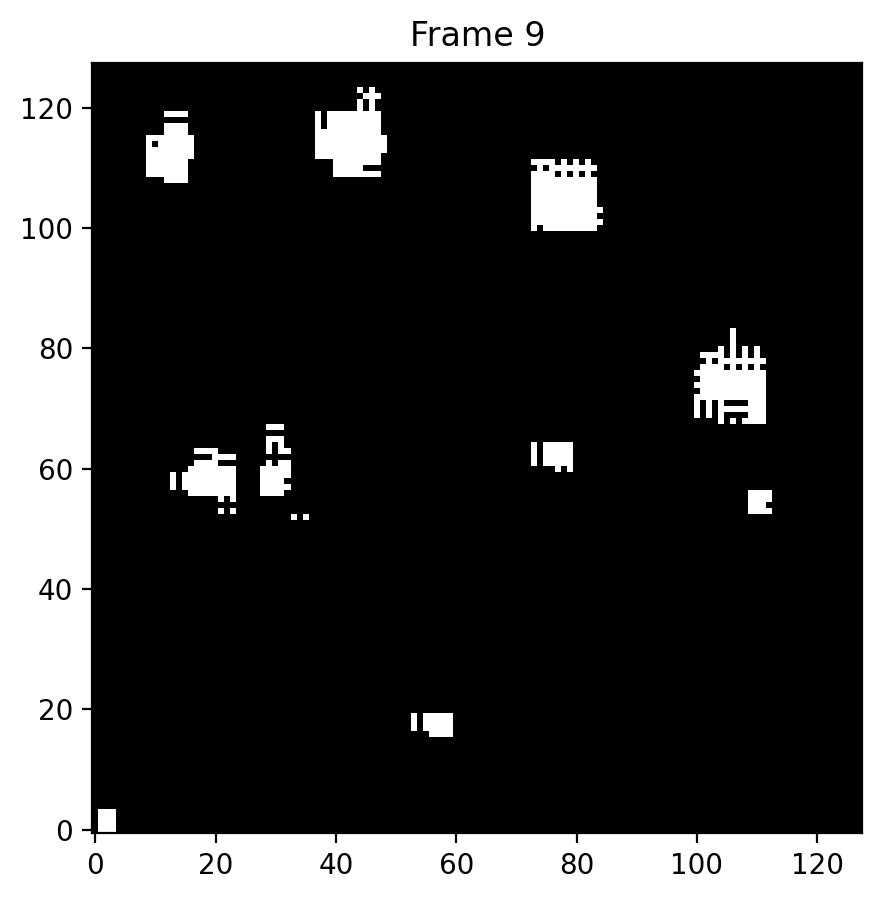

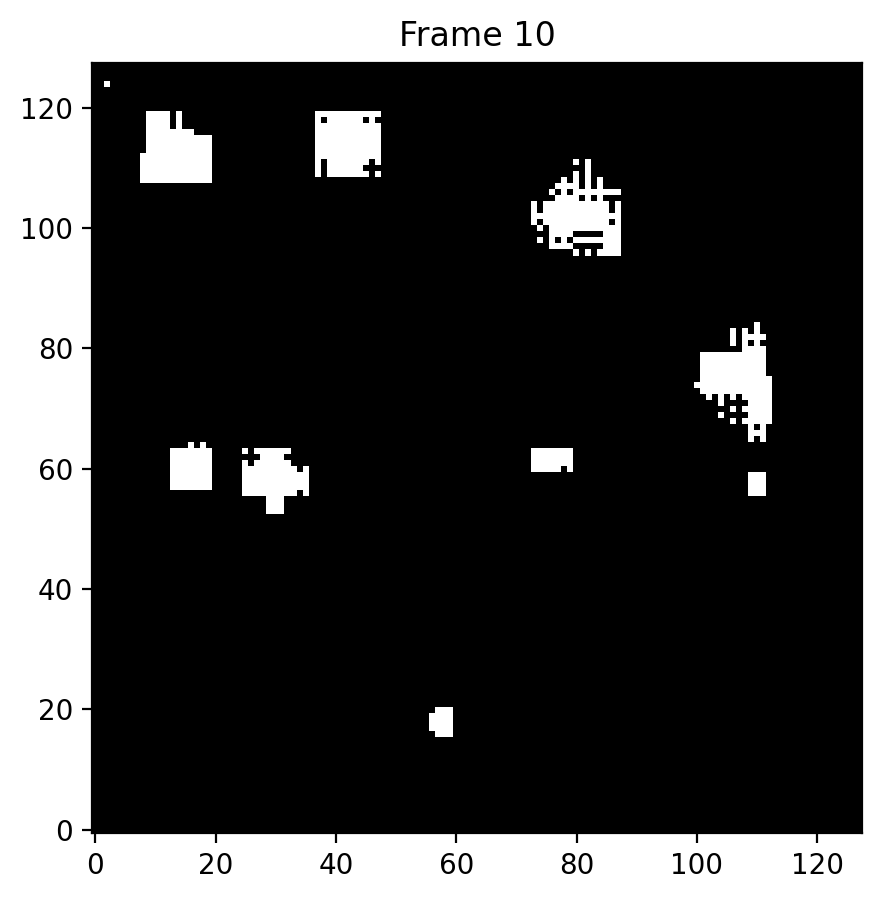

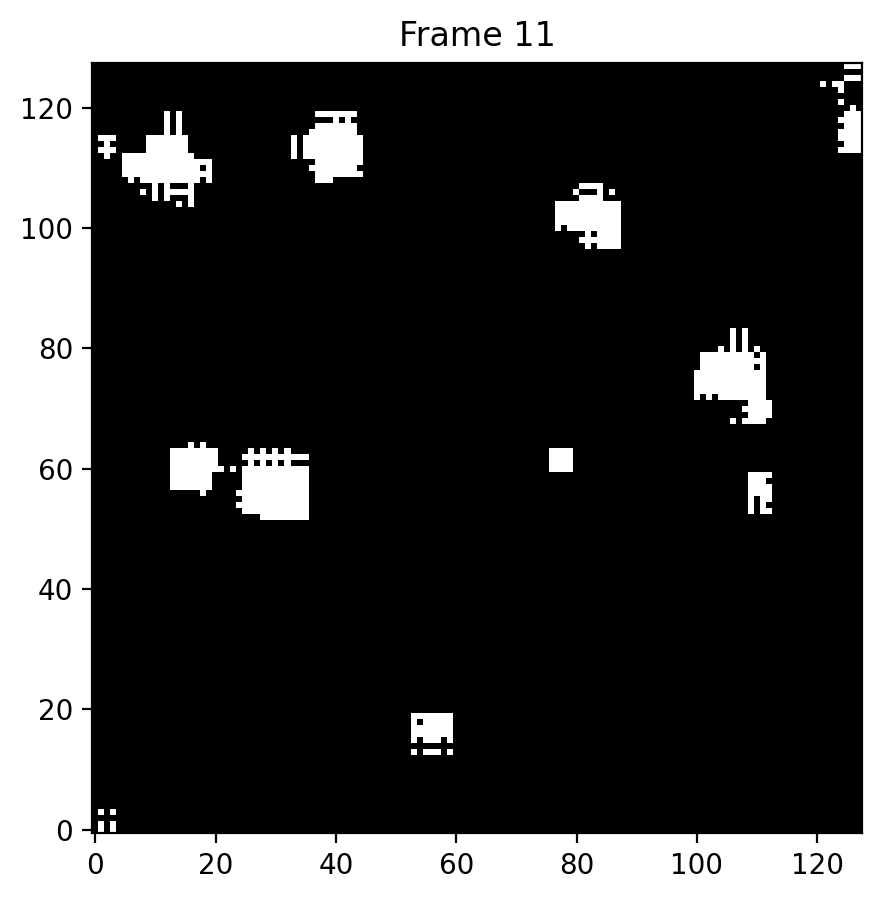

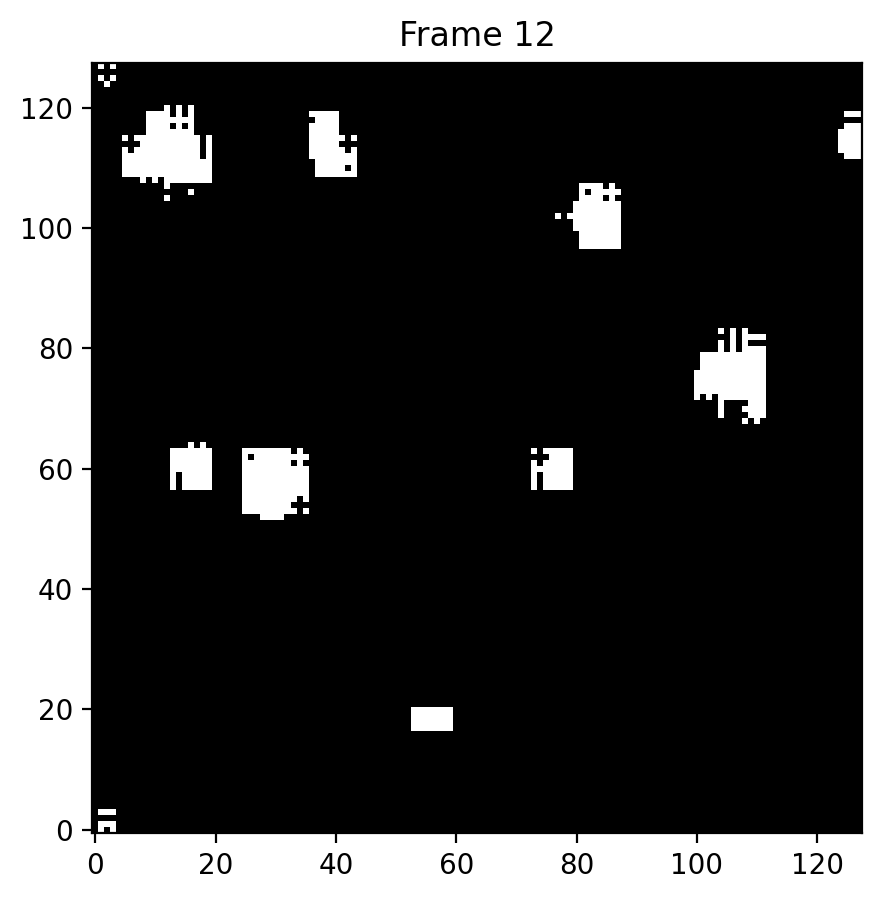

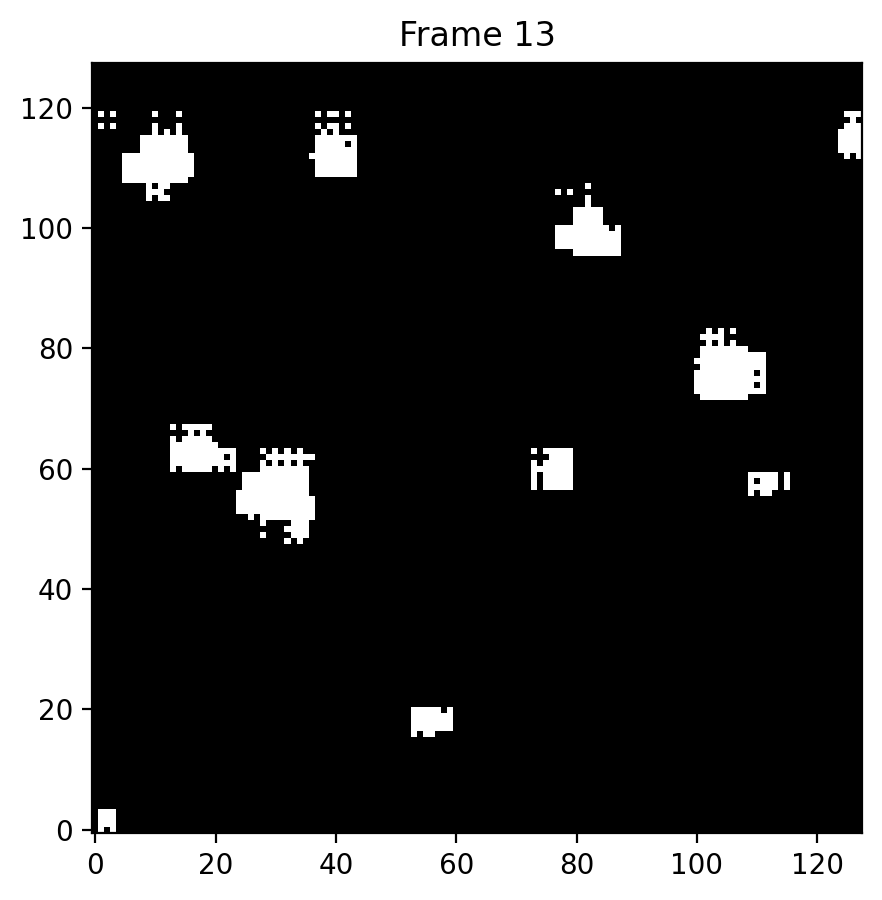

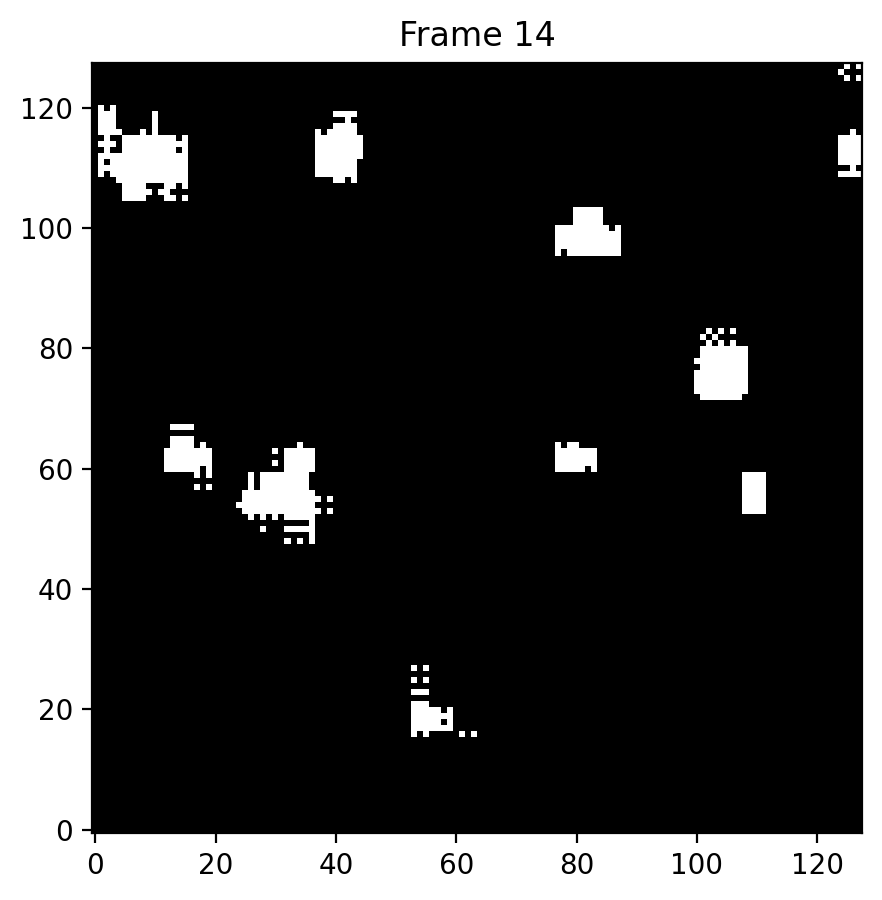

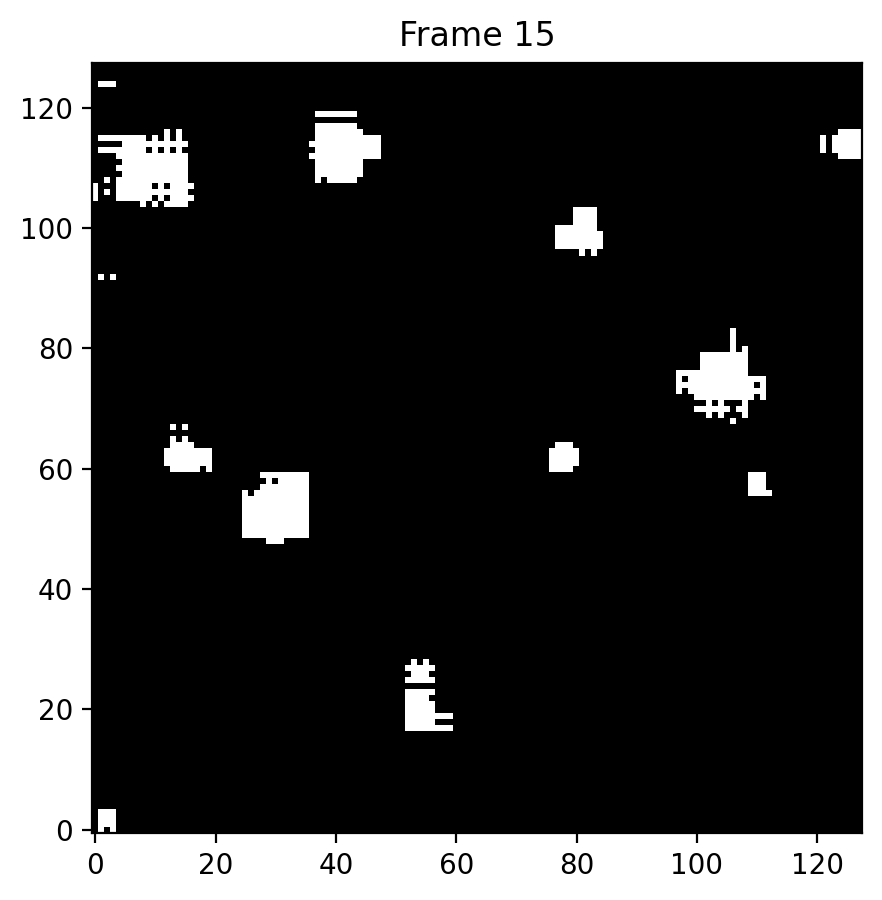

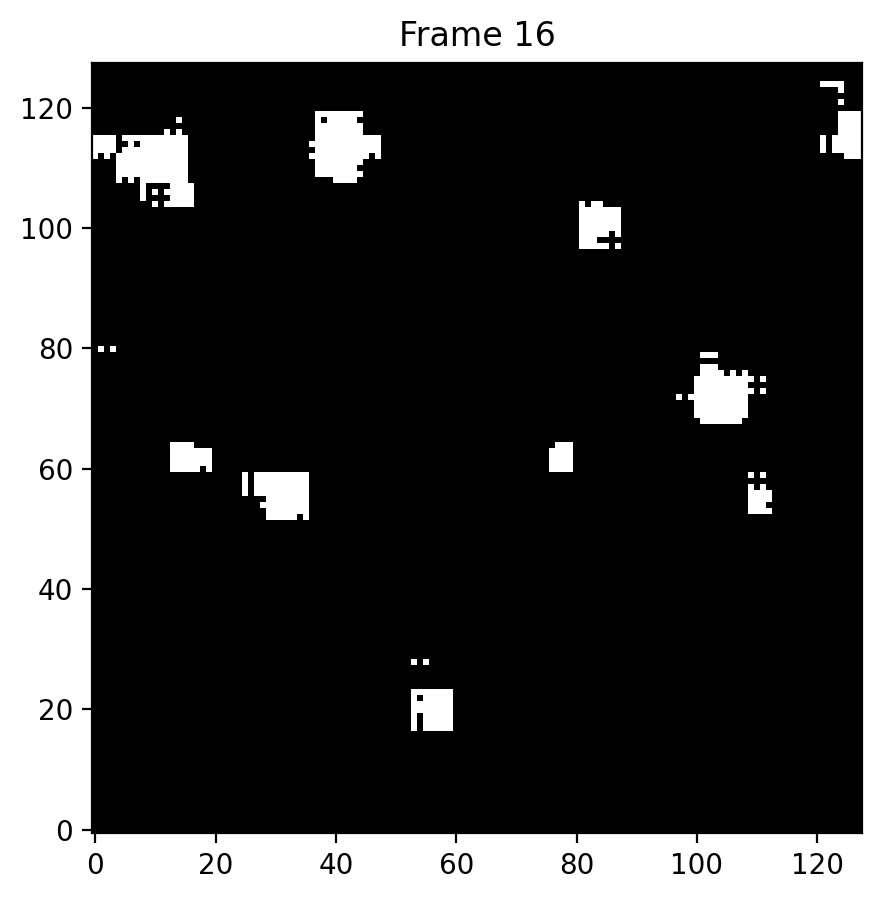

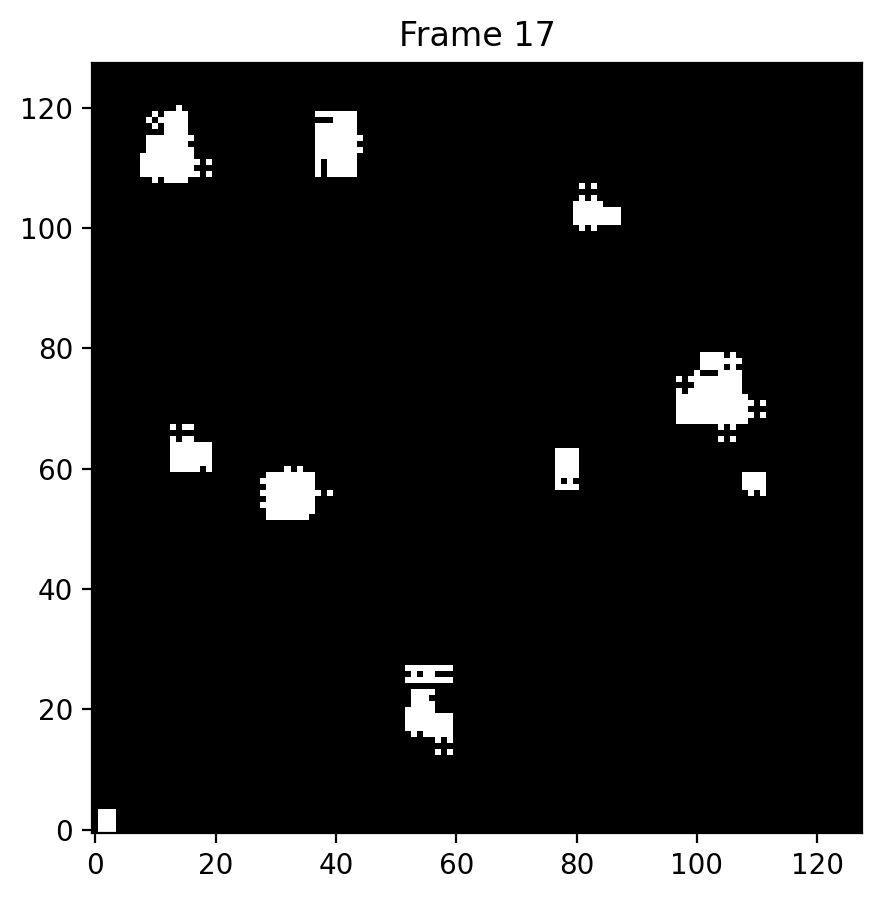

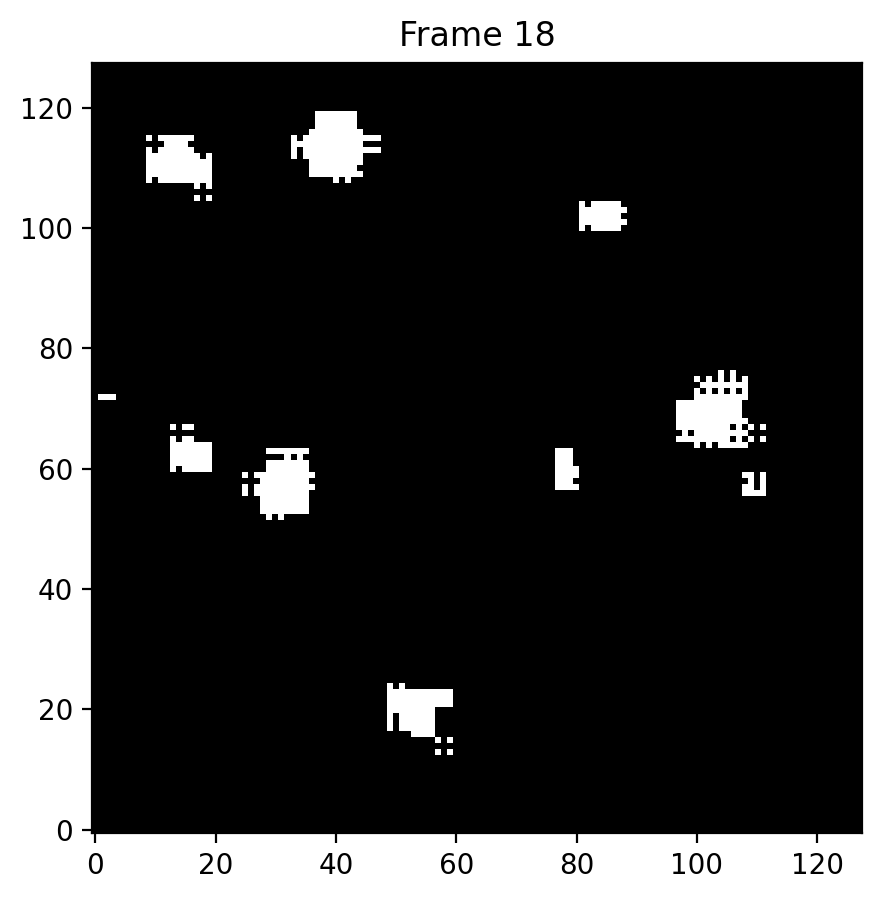

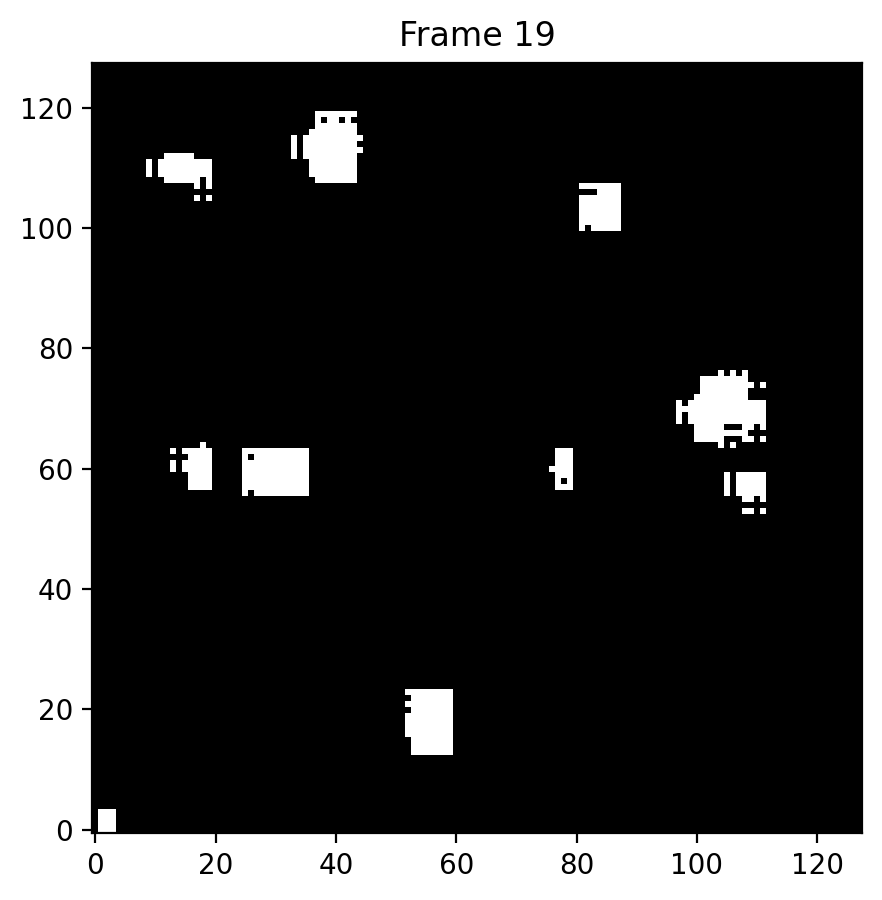

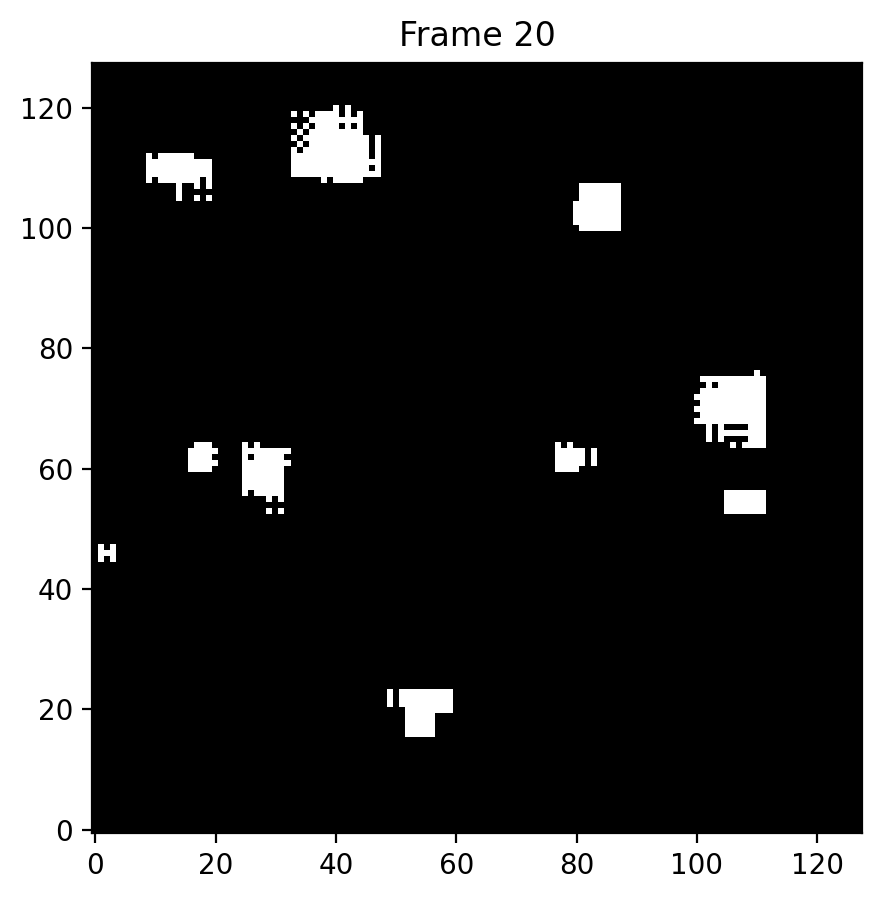

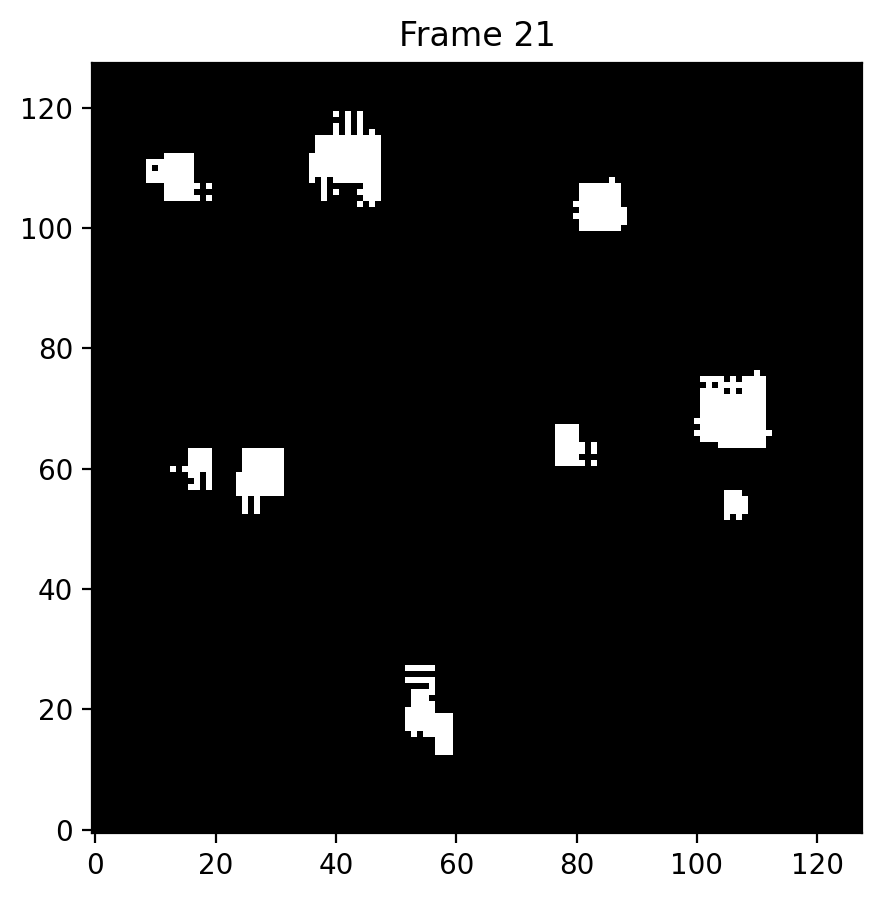

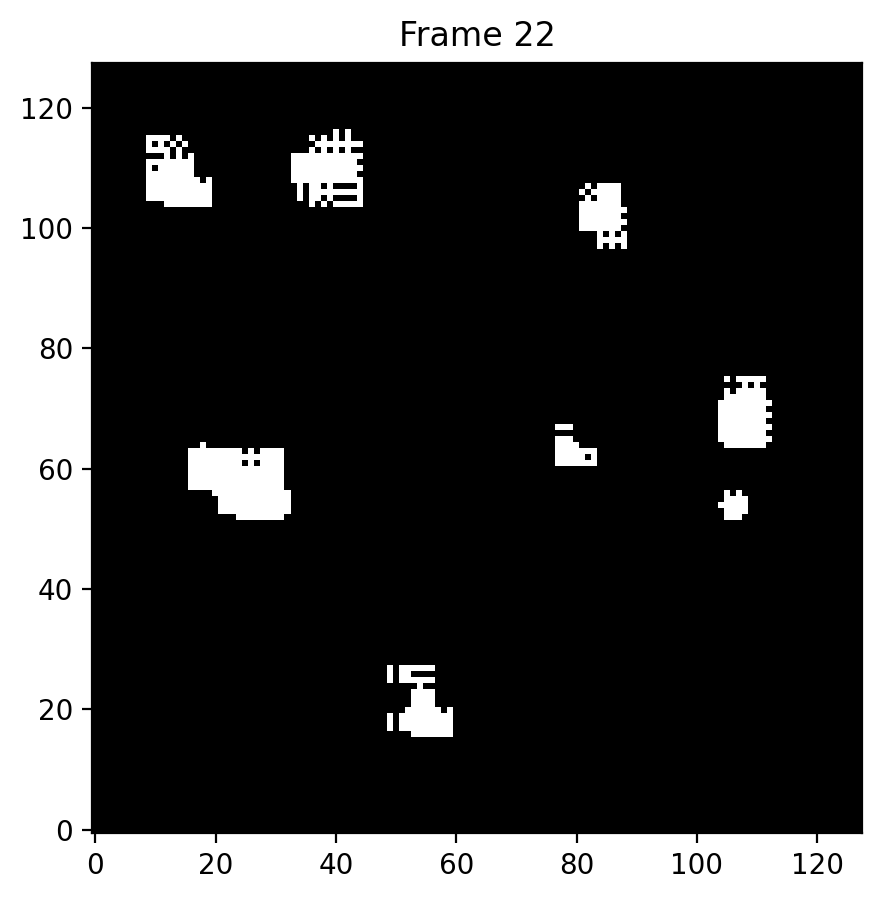

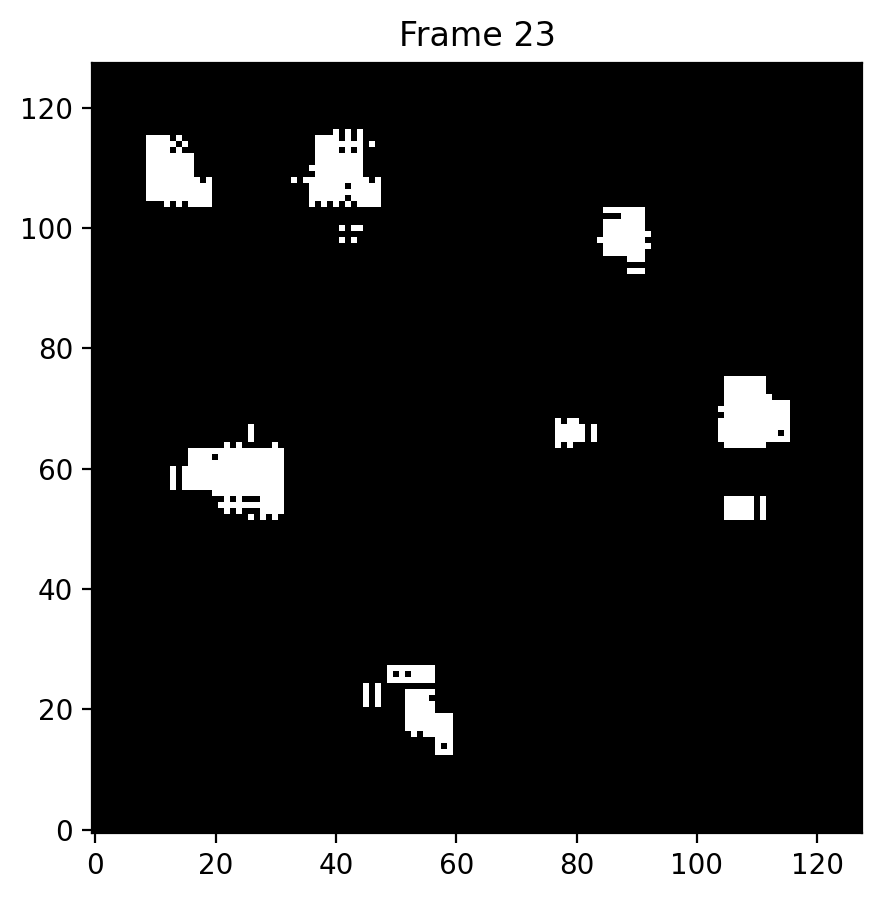

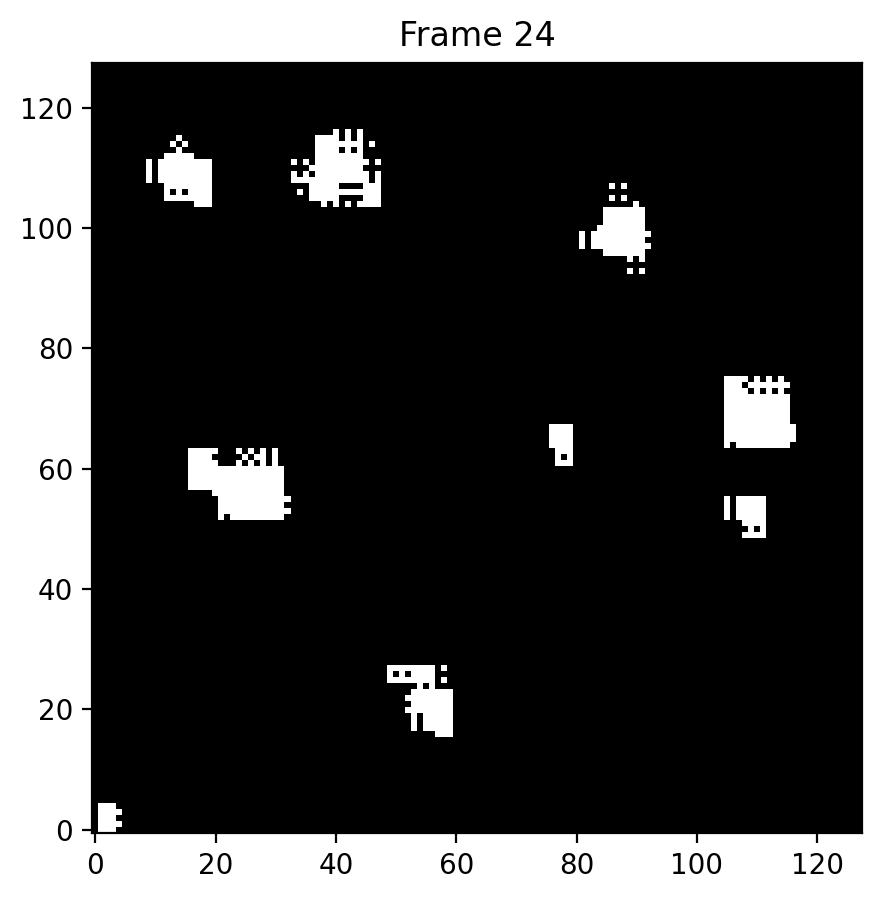

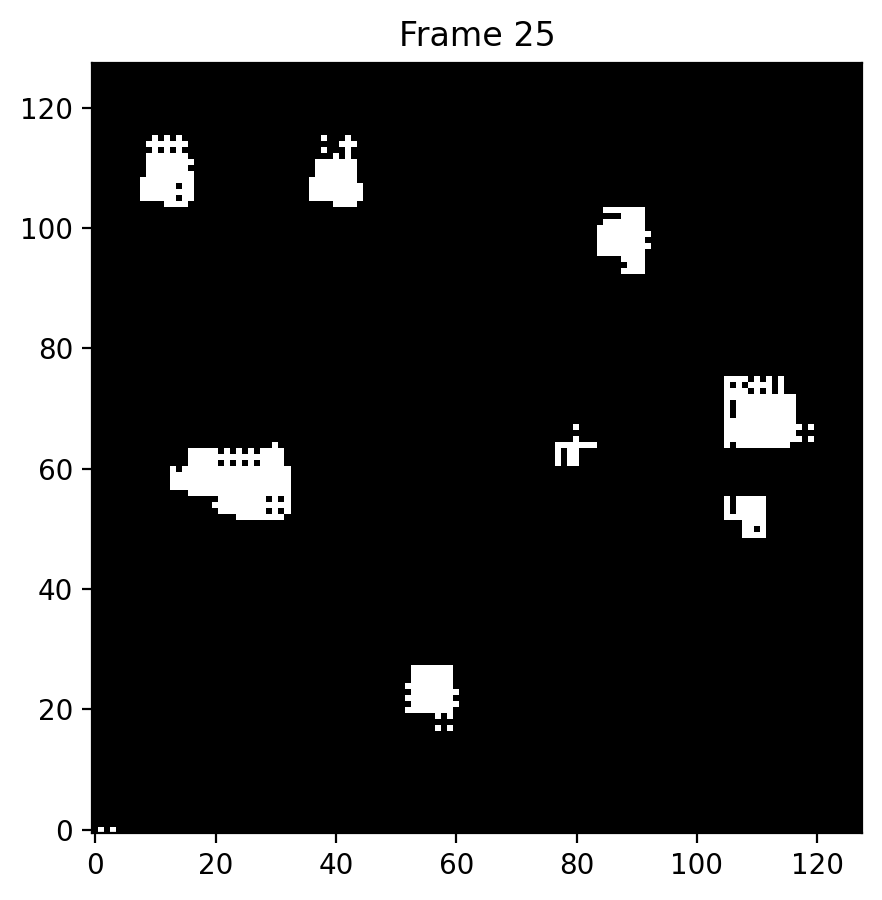

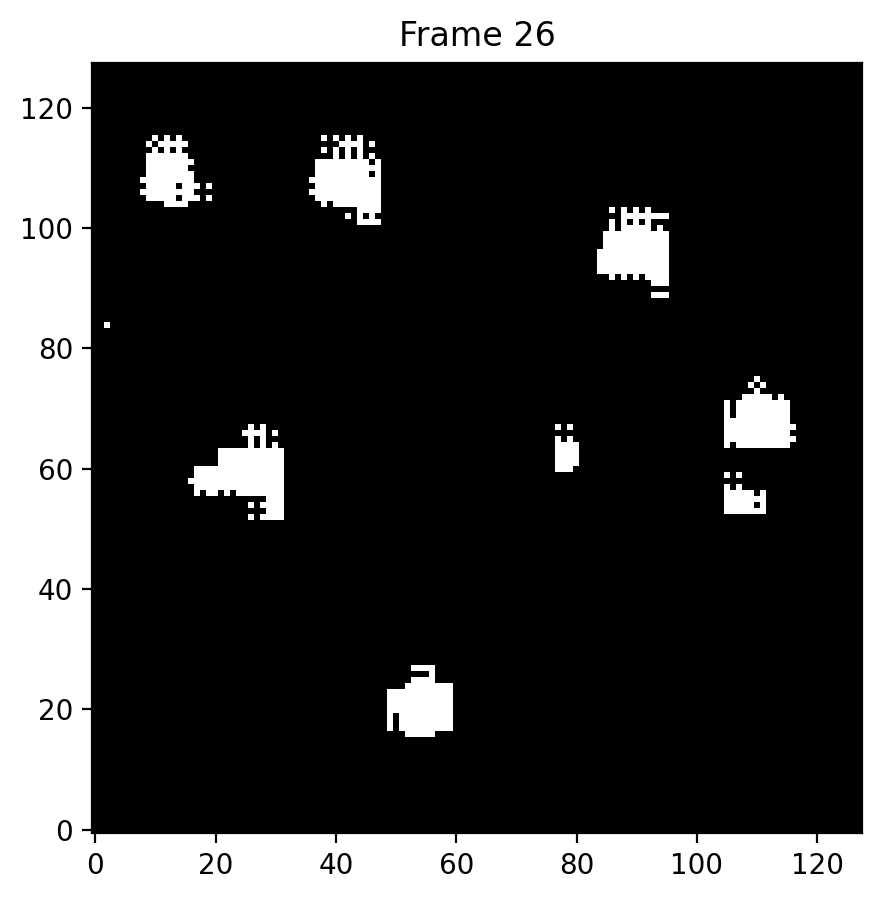

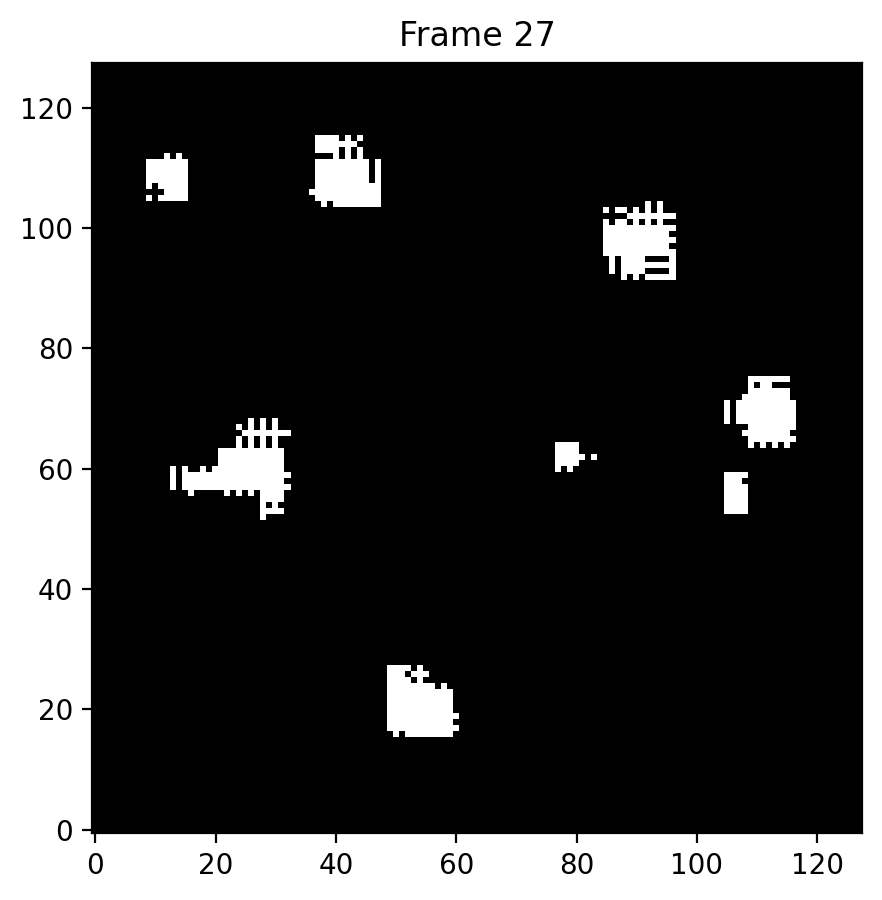

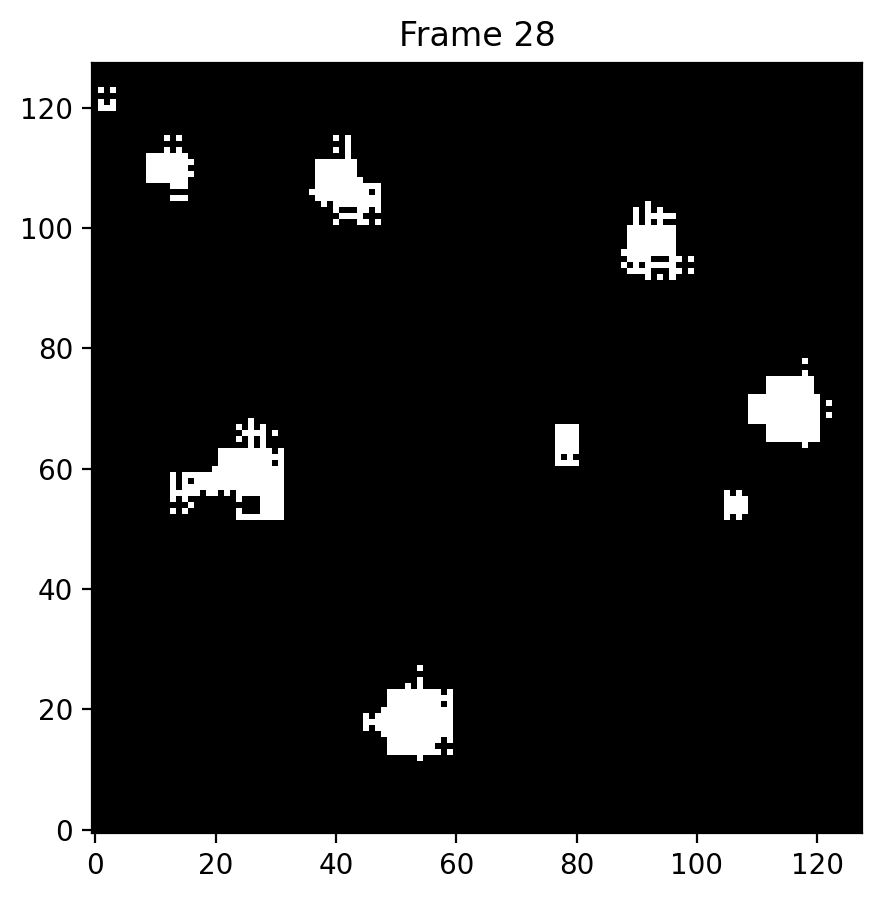

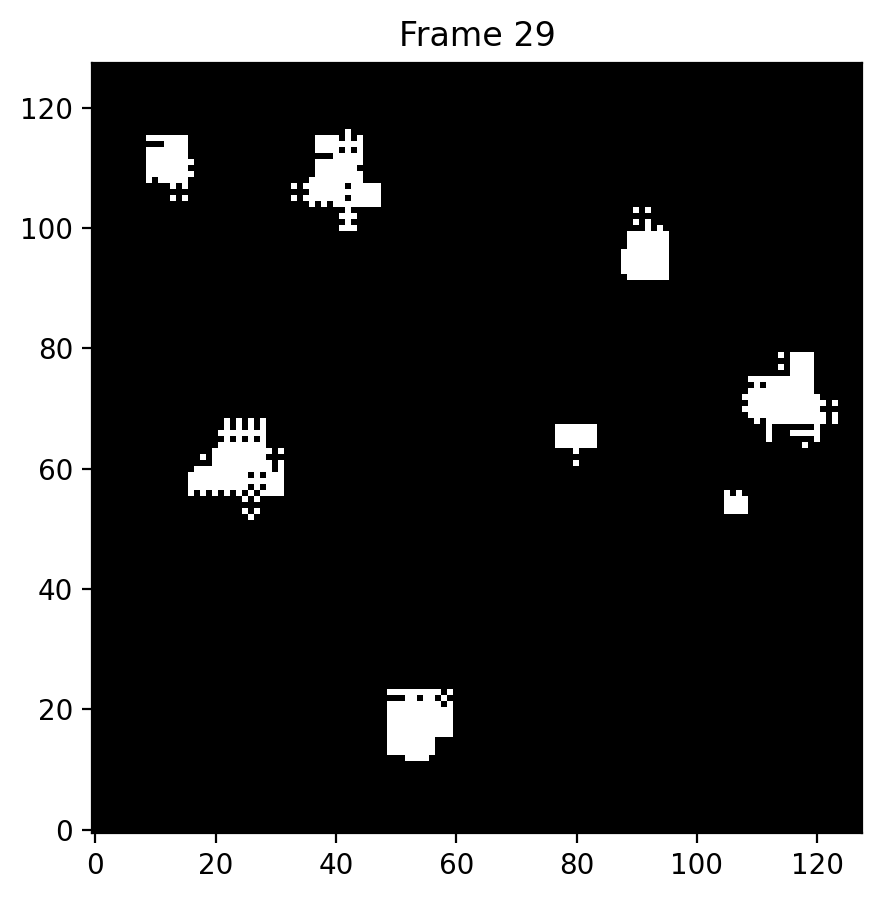

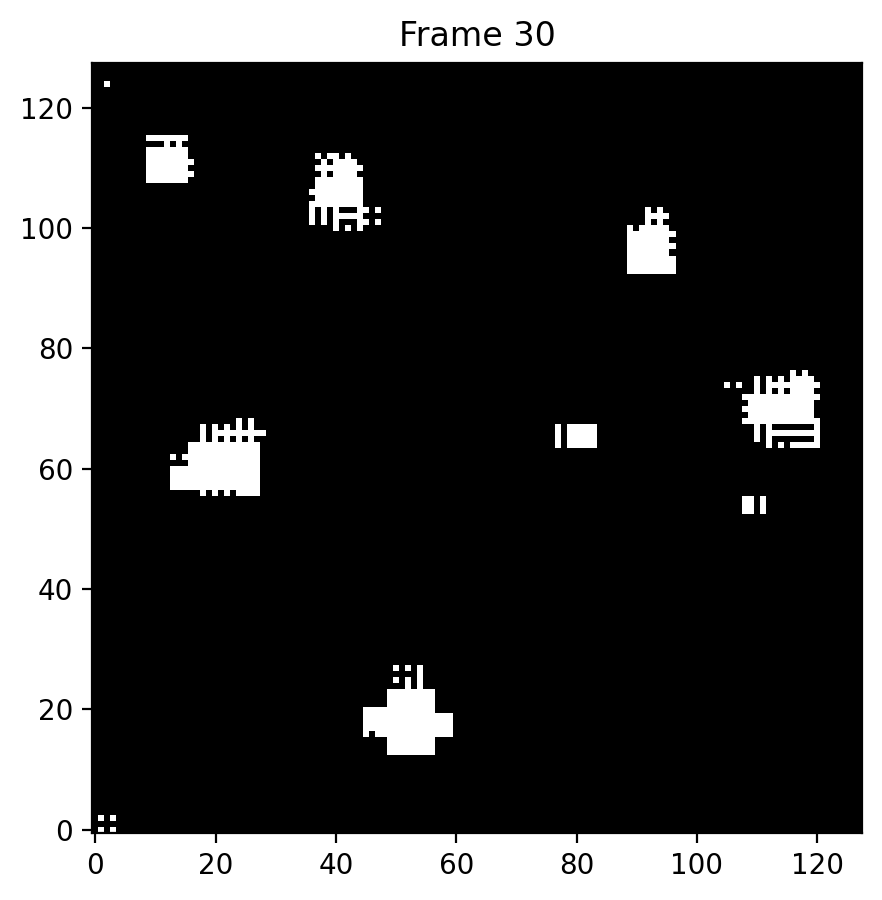

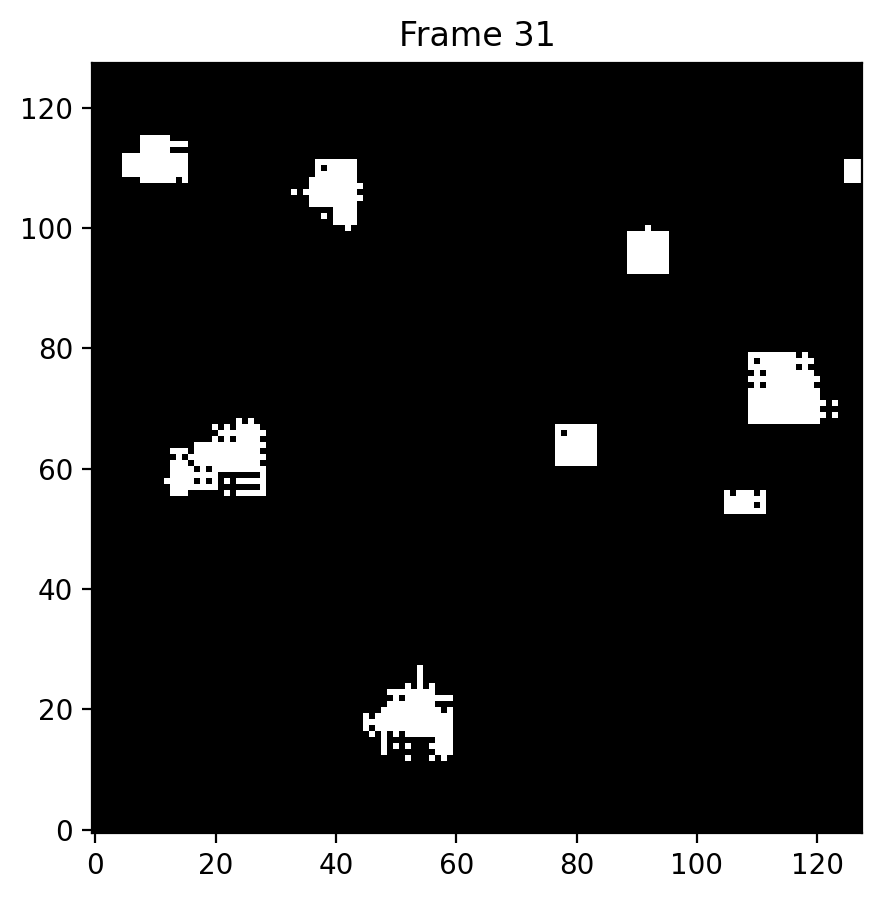

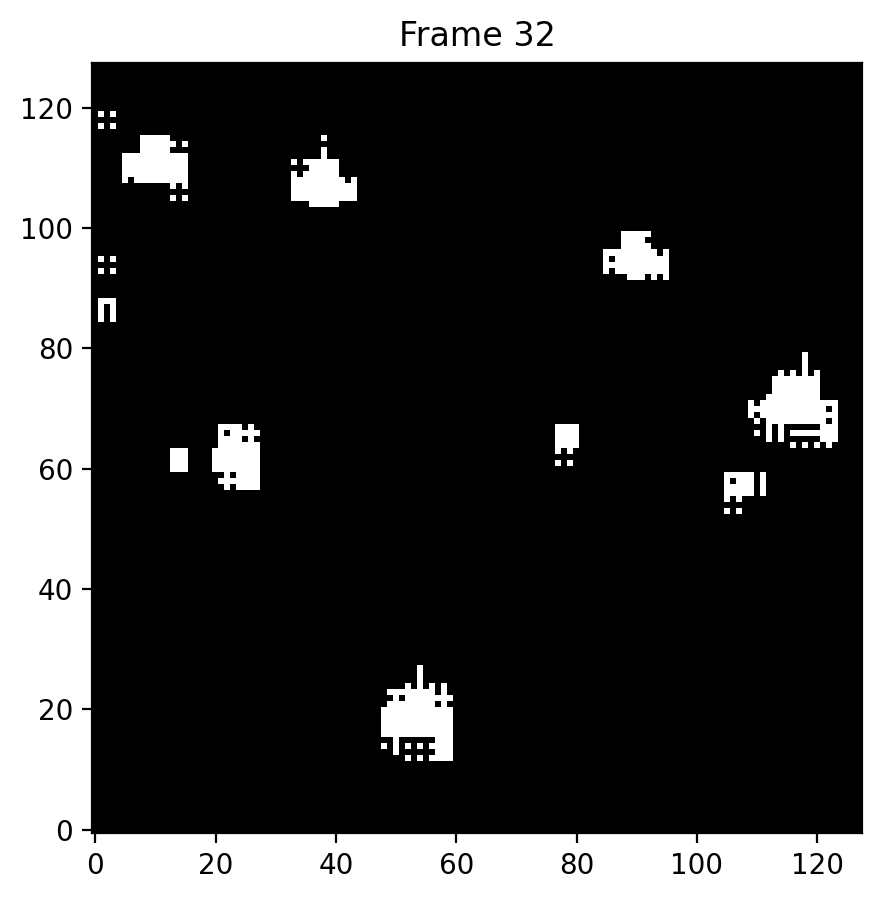

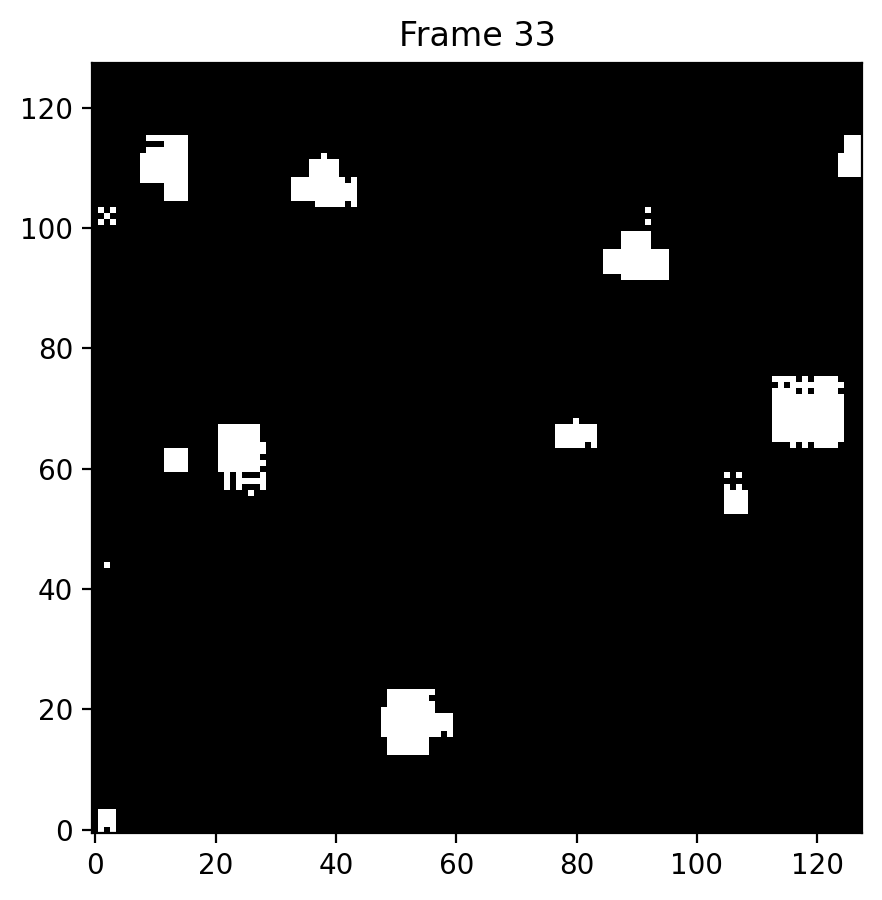

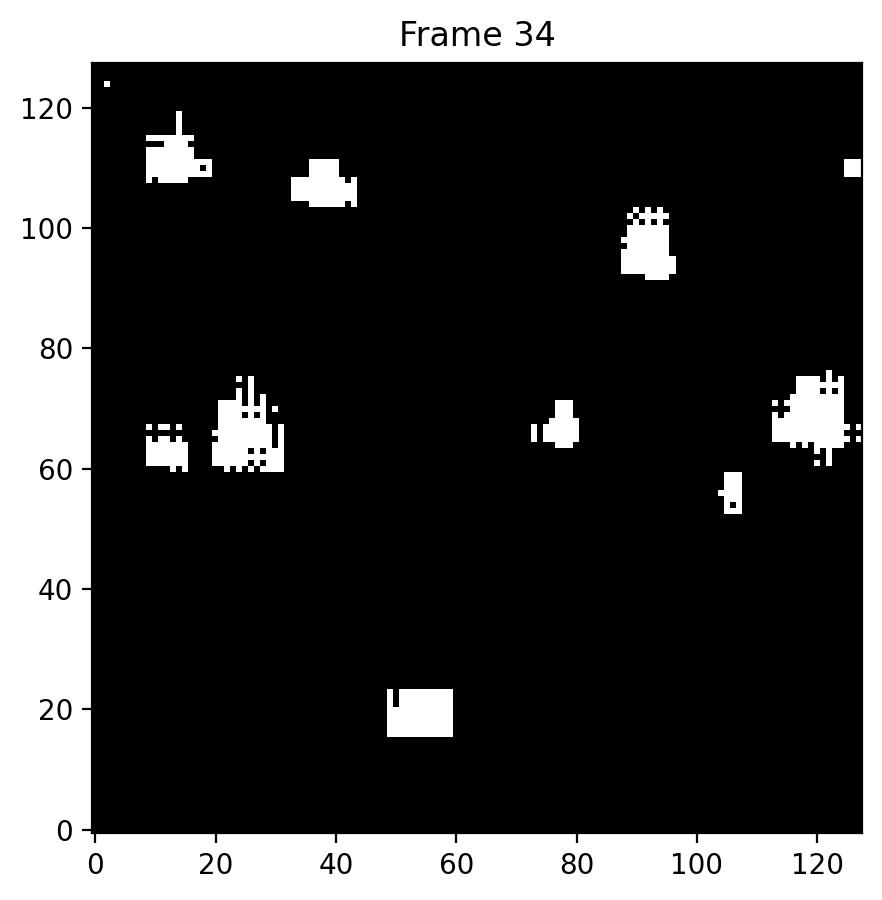

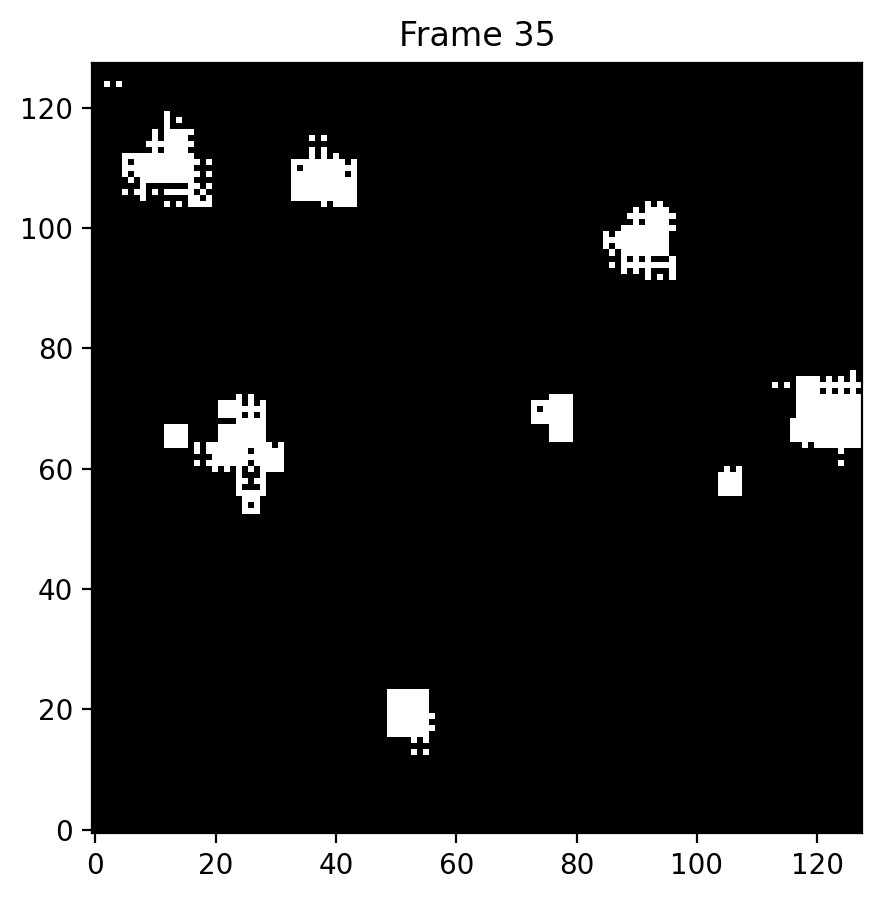

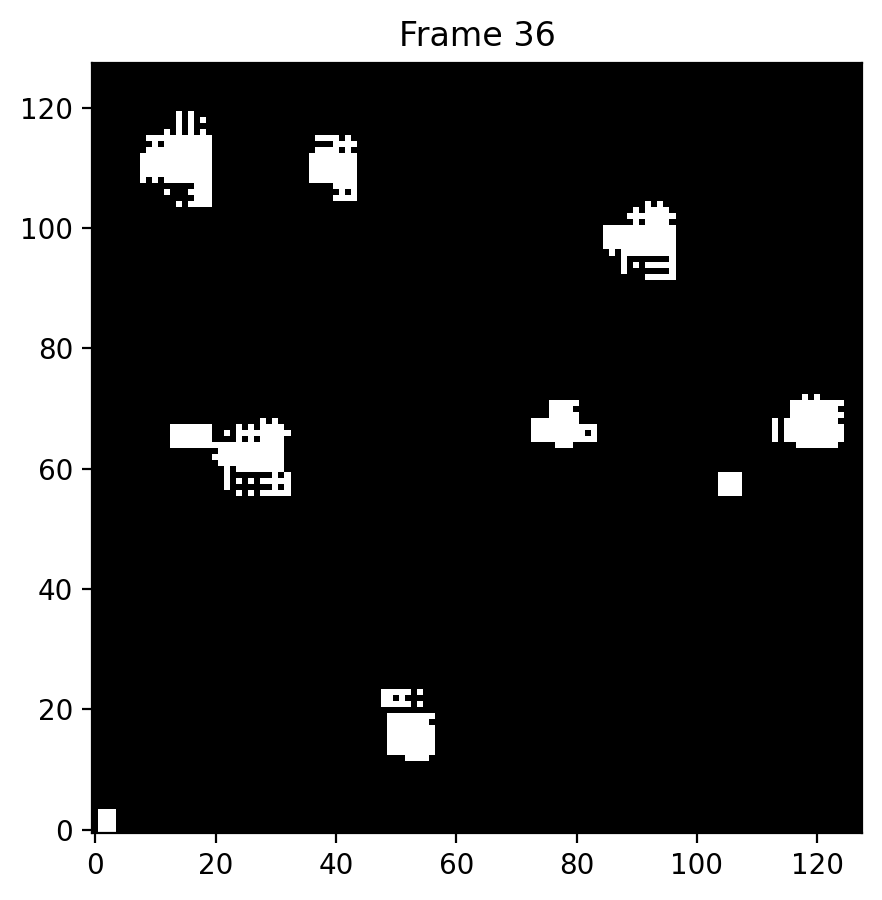

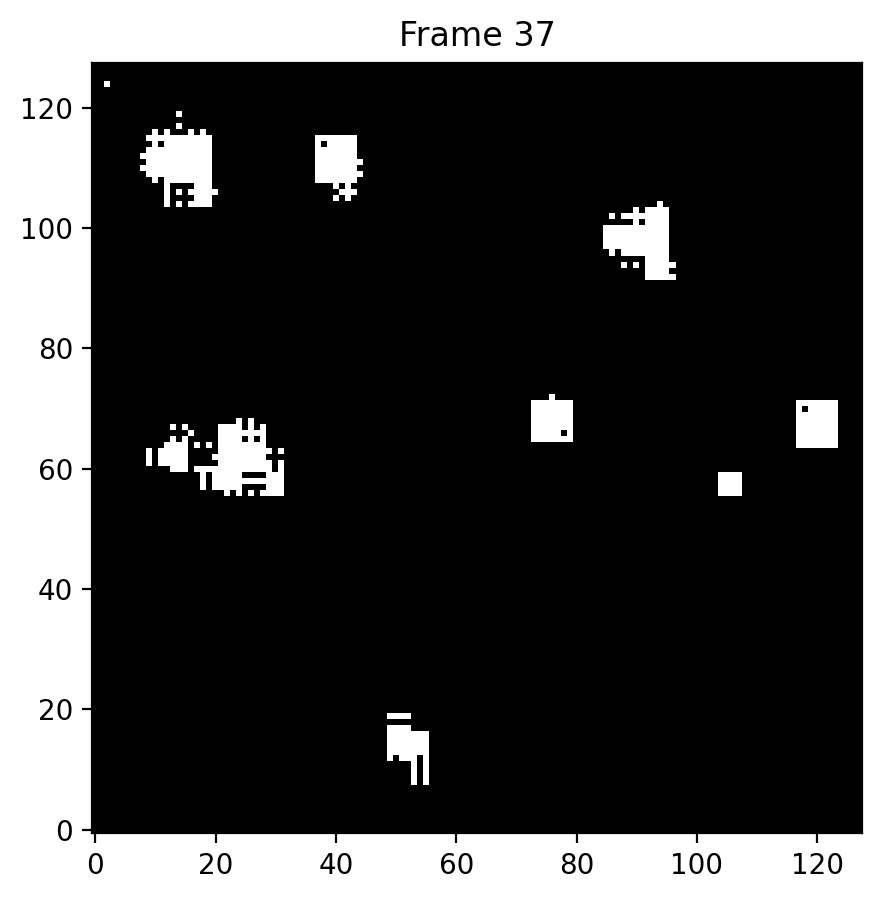

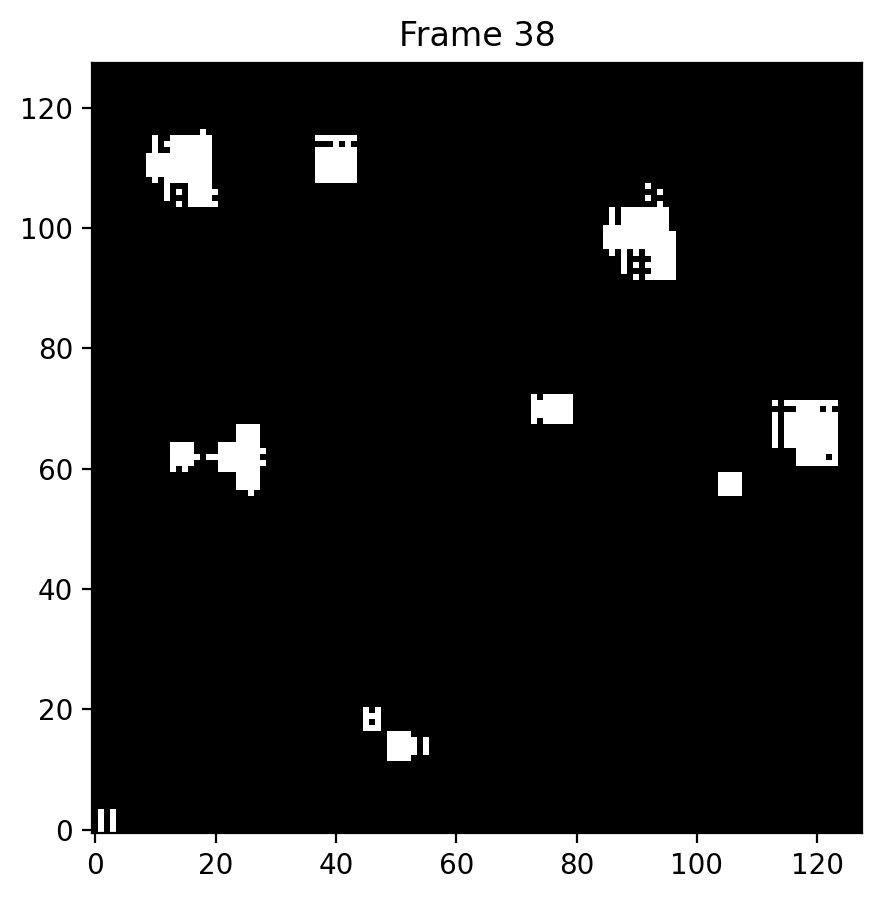

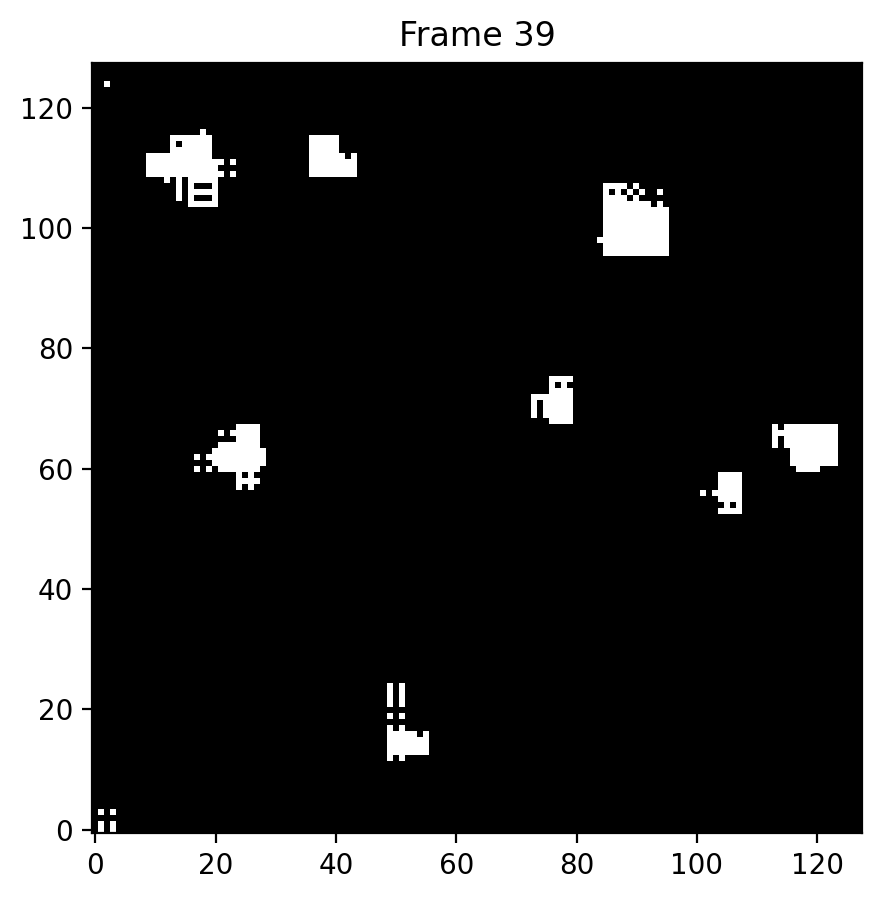

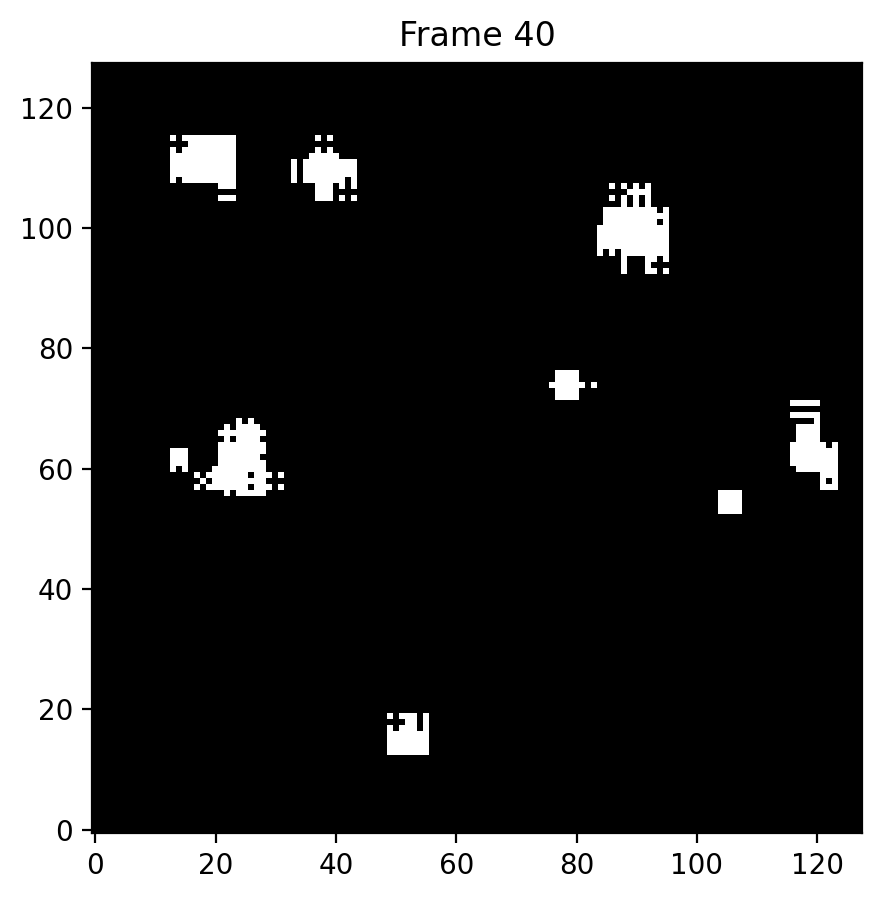

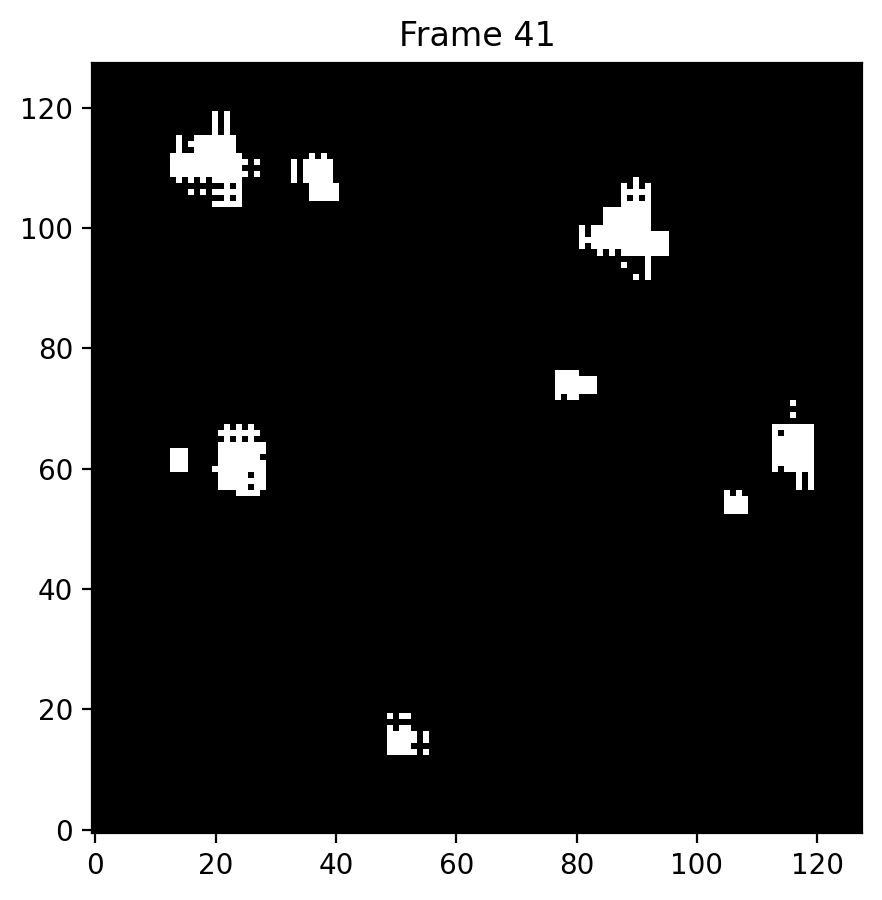

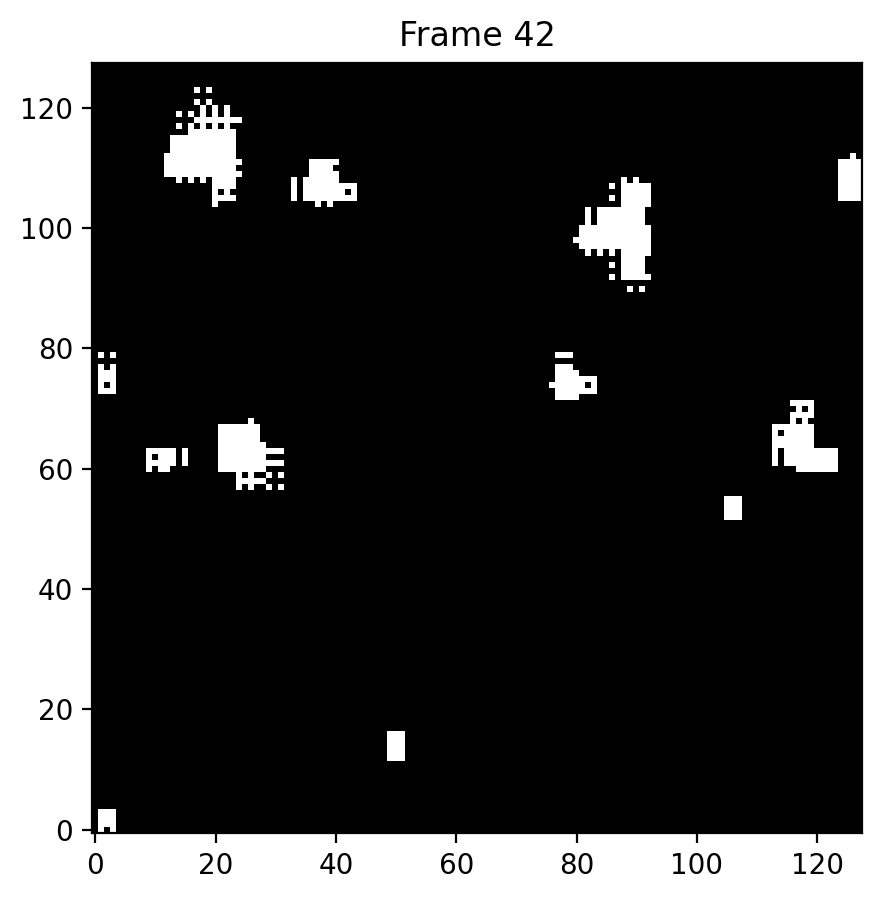

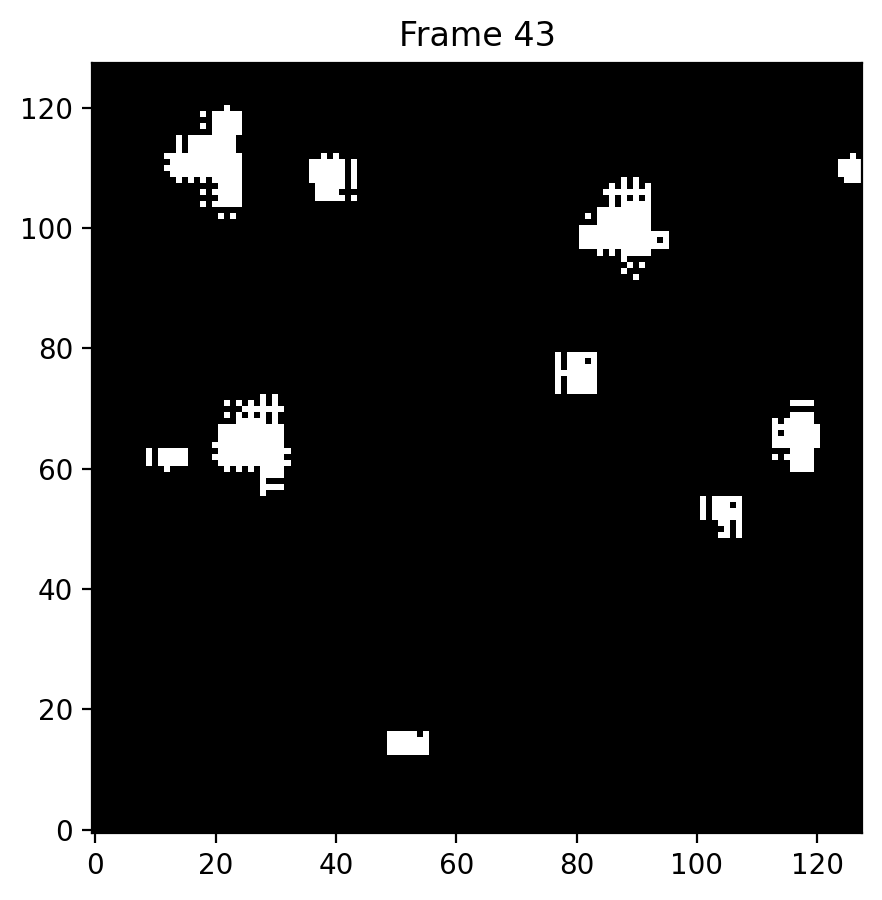

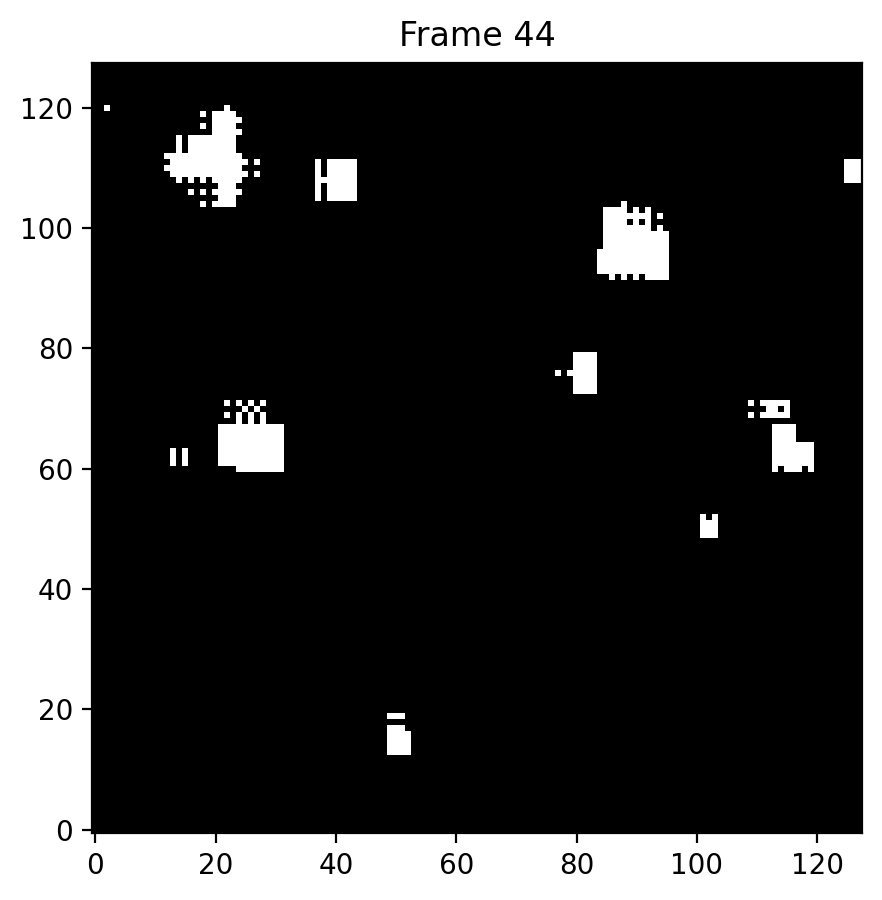

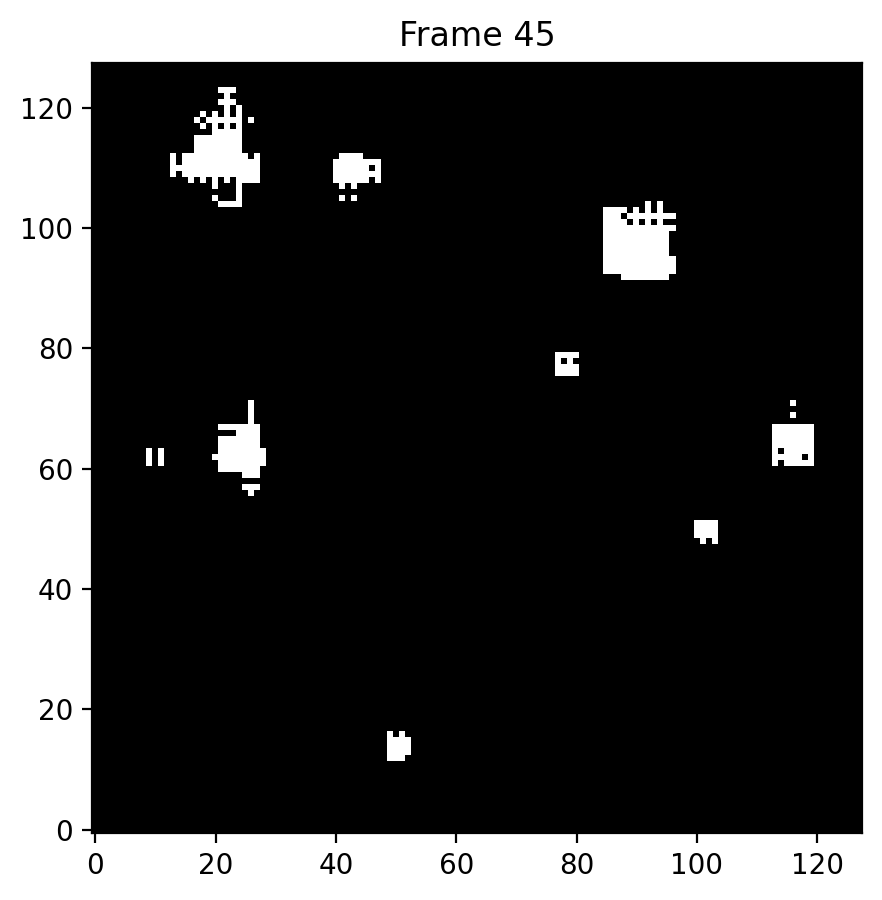

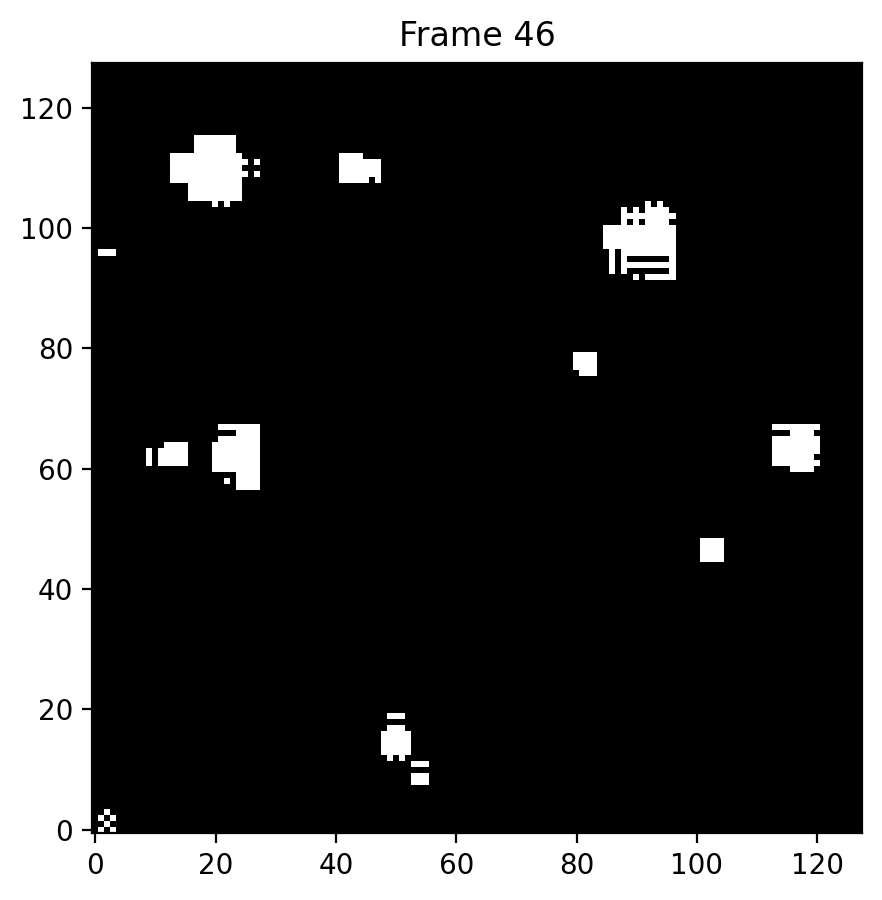

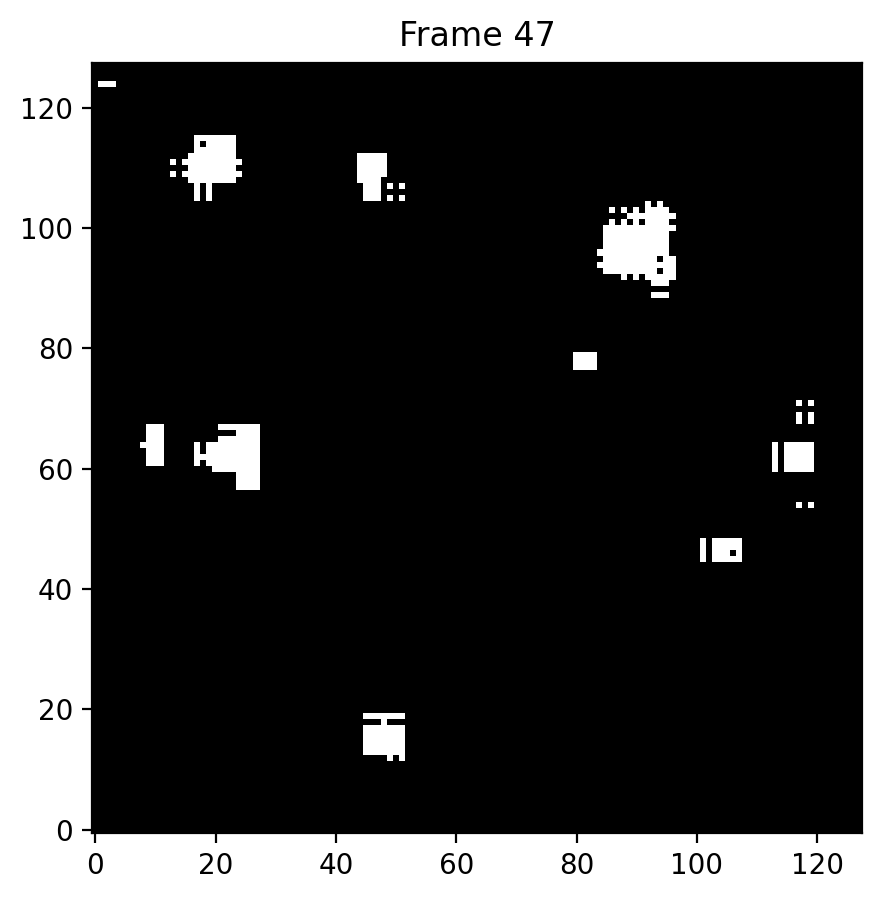

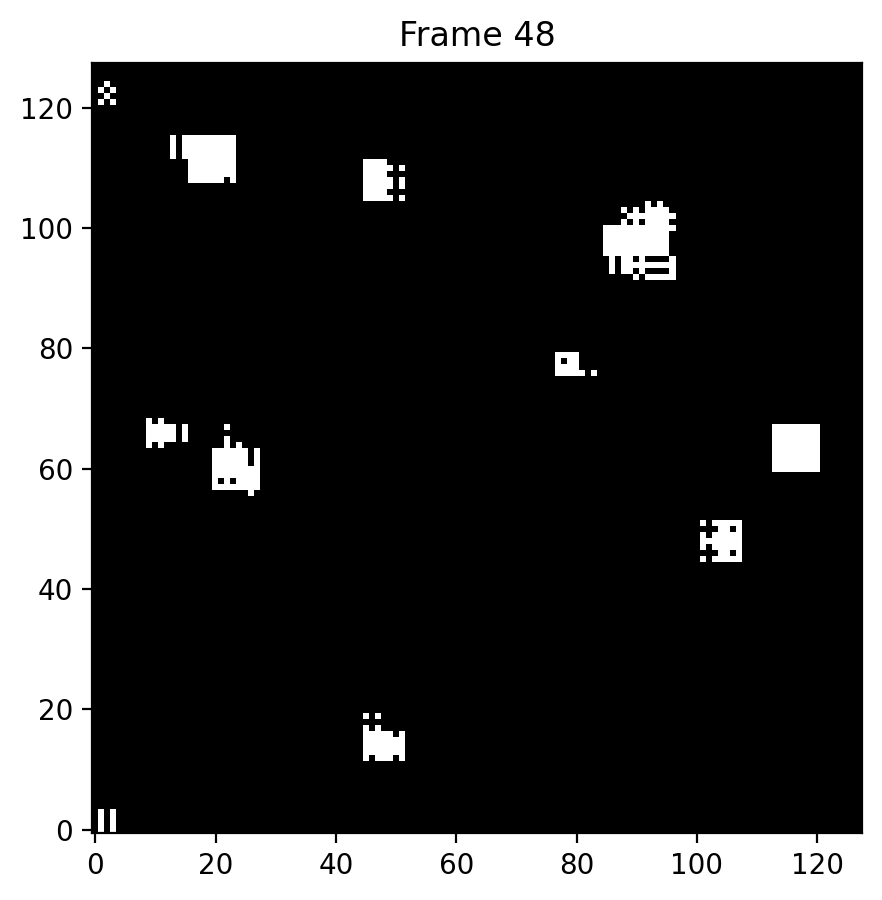

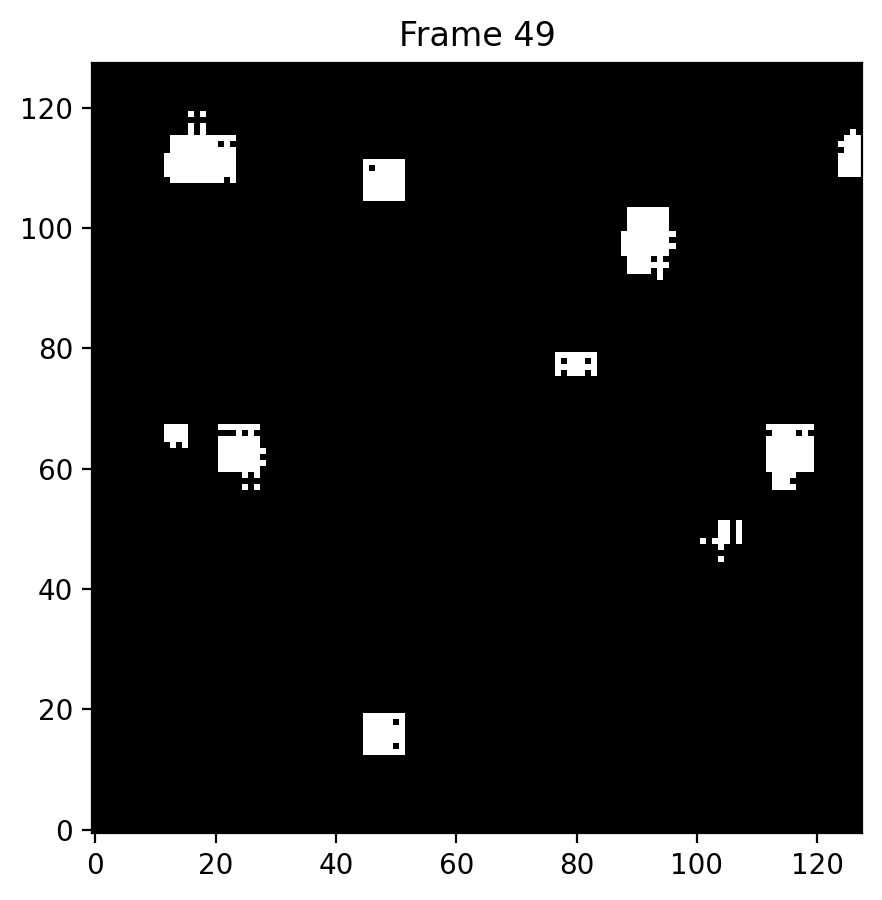

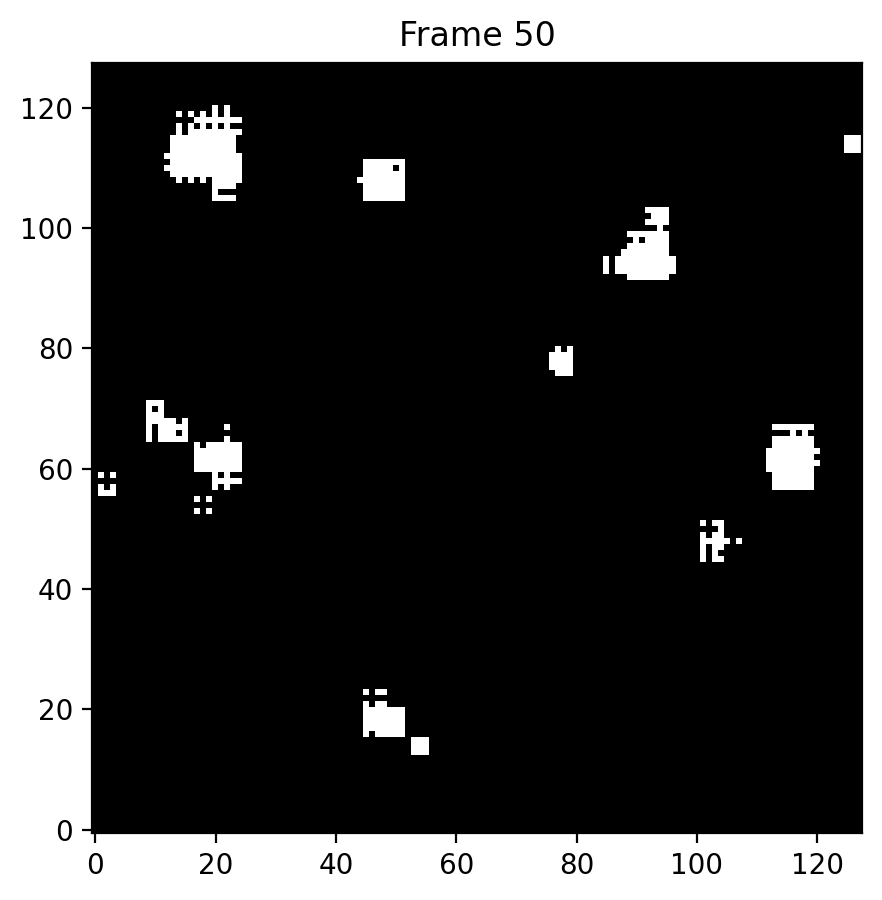

In [496]:
# Use our model
predictions = model.predict(test_vid)

# Label the particle
predicted_labels = predictions[..., 1] > 0.5

# Storage the position of particle
particle_positions_per_frame = []

# Go through every frame
for i in range(predicted_labels.shape[0]):

    particle_positions = np.where(predicted_labels[i])

    particle_positions_per_frame.append(particle_positions)

    plt.figure(figsize=(5, 5))
    plt.imshow(predicted_labels[i], cmap='gray', origin='lower')
    plt.title(f"Frame {i+1}")
    plt.show()

# Goal 2: Given ground truth labels, extract particle positions in each video frame
Simply stated, given `labels` approximate `tracks`. So this project essentially ignores the training videos.

## Does your method work for hypothetical neural network output?
The neural network output is a probability distribution with values between zero and one.

# DBSCAN

In [497]:
# Initialize a list to store the coordinates of marked points for each frame
particle_positions_per_frame = []

# Iterate through each frame
for frame_index in range(predicted_labels.shape[0]):
    # Find the coordinates of all points marked as True in the current frame
    y_positions, x_positions = np.where(predicted_labels[frame_index])

    # For each marked point, record its coordinates
    frame_particle_positions = list(zip(y_positions, x_positions))

    # Add the list of coordinates for all marked points in the current frame to the total list
    particle_positions_per_frame.append(frame_particle_positions)

# particle_positions_per_frame now contains the coordinates of all marked points in each frame, in the form of (y, x)

In [498]:
from sklearn.cluster import DBSCAN
import numpy as np

centers_per_frame = []  # Store the center positions of particles for each frame

for frame_positions in particle_positions_per_frame:
    # Ensure frame_positions is a NumPy array
    frame_positions_np = np.array(frame_positions)

    # Apply DBSCAN algorithm
    dbscan = DBSCAN(eps=10, min_samples=3)
    clusters = dbscan.fit_predict(frame_positions_np)

    # Find the center positions of each cluster (particle)
    centers = []
    for label in set(clusters):
        if label != -1:  # Exclude noise points
            # Calculate the centroid for each cluster
            center = frame_positions_np[clusters == label].mean(axis=0)
            centers.append(center)
    
    centers_per_frame.append(centers)

# centers_per_frame now contains the center positions of each particle for every frame

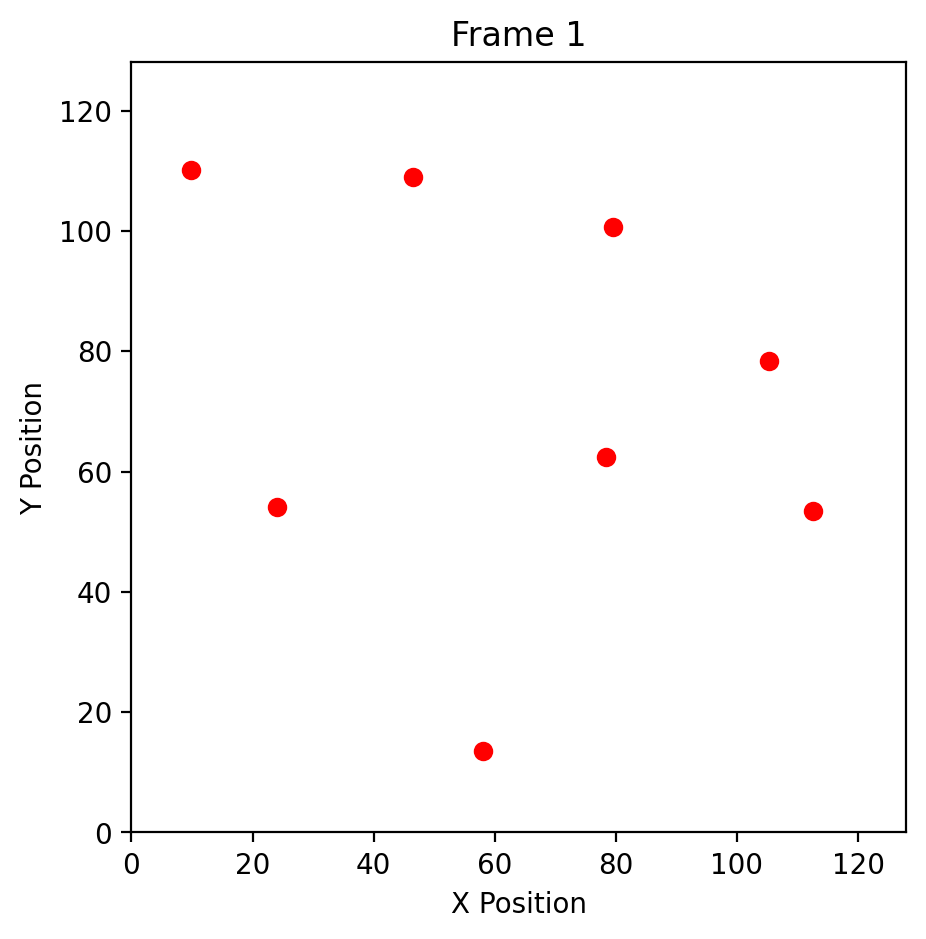

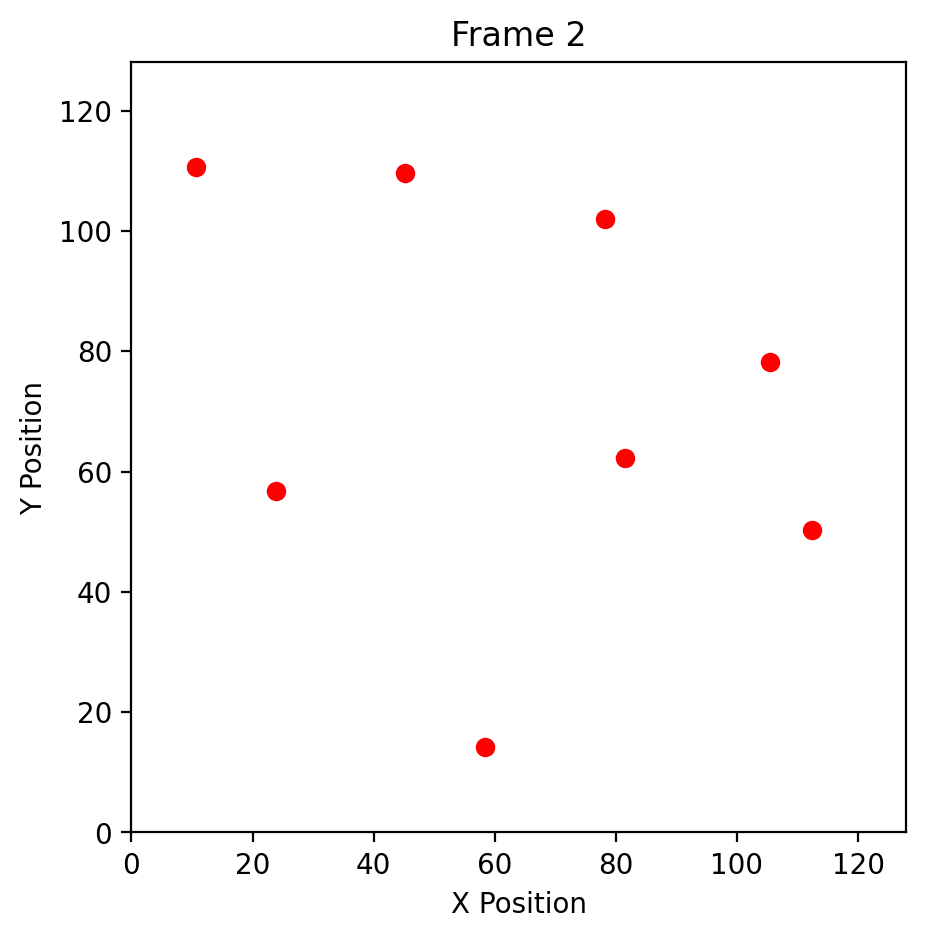

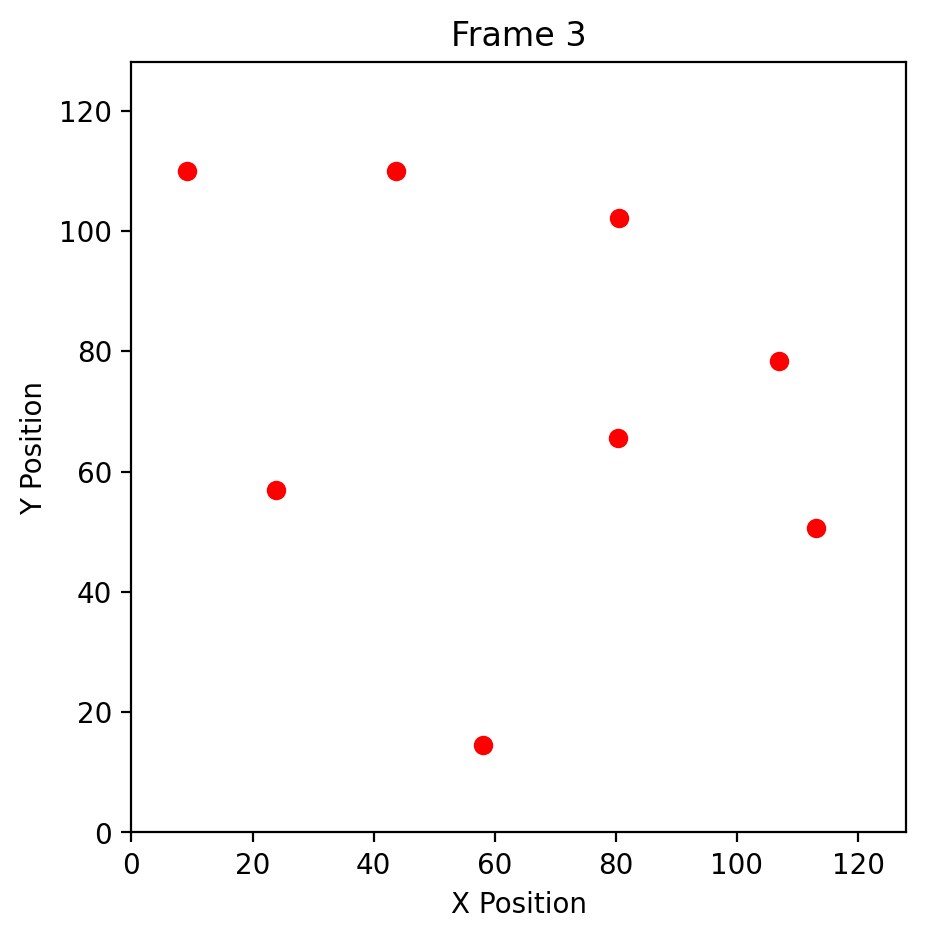

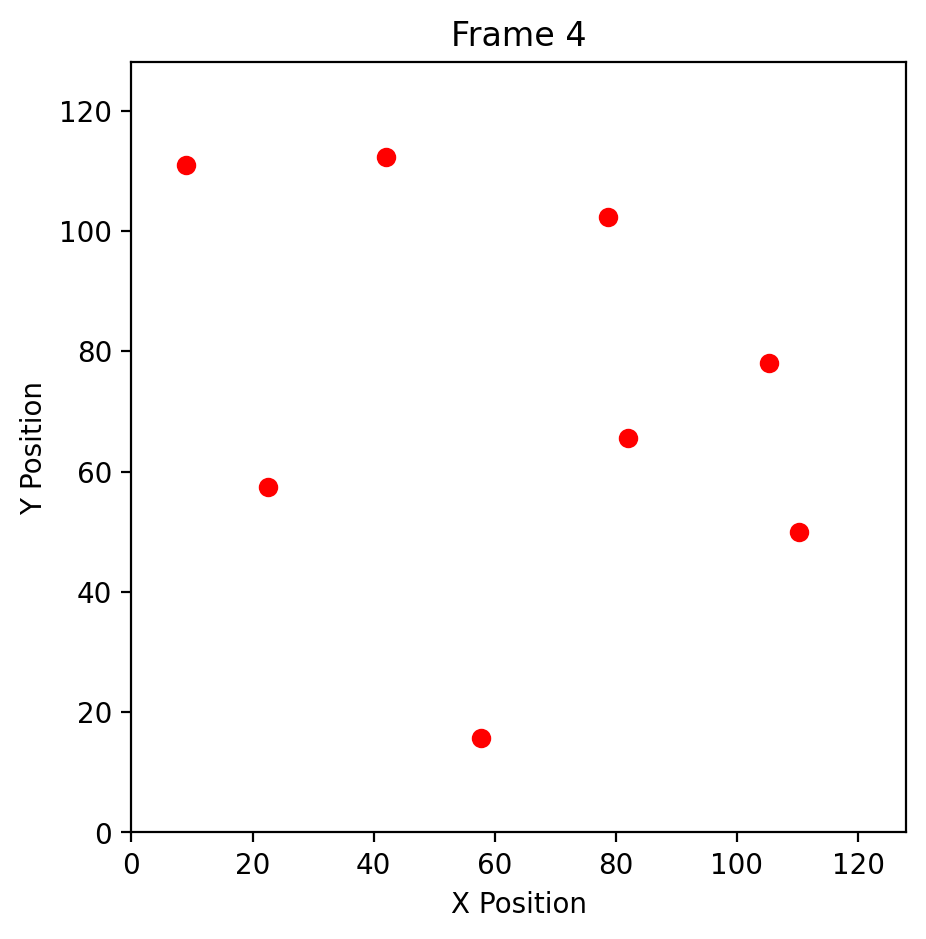

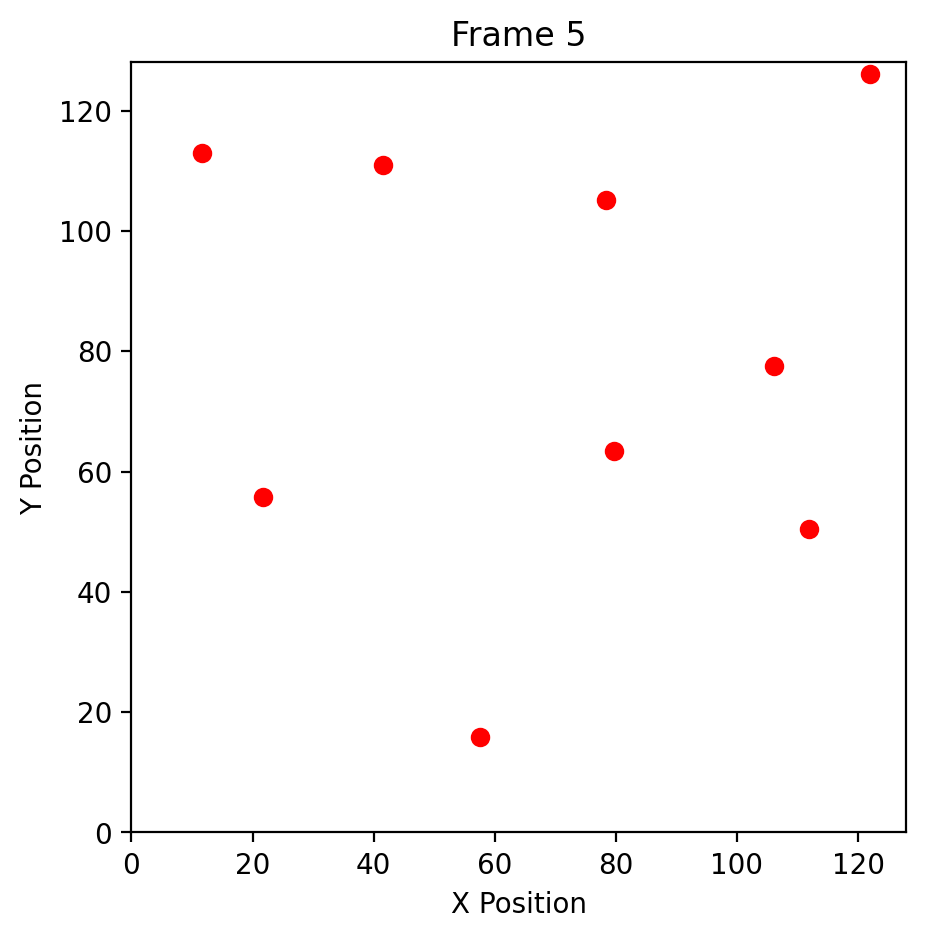

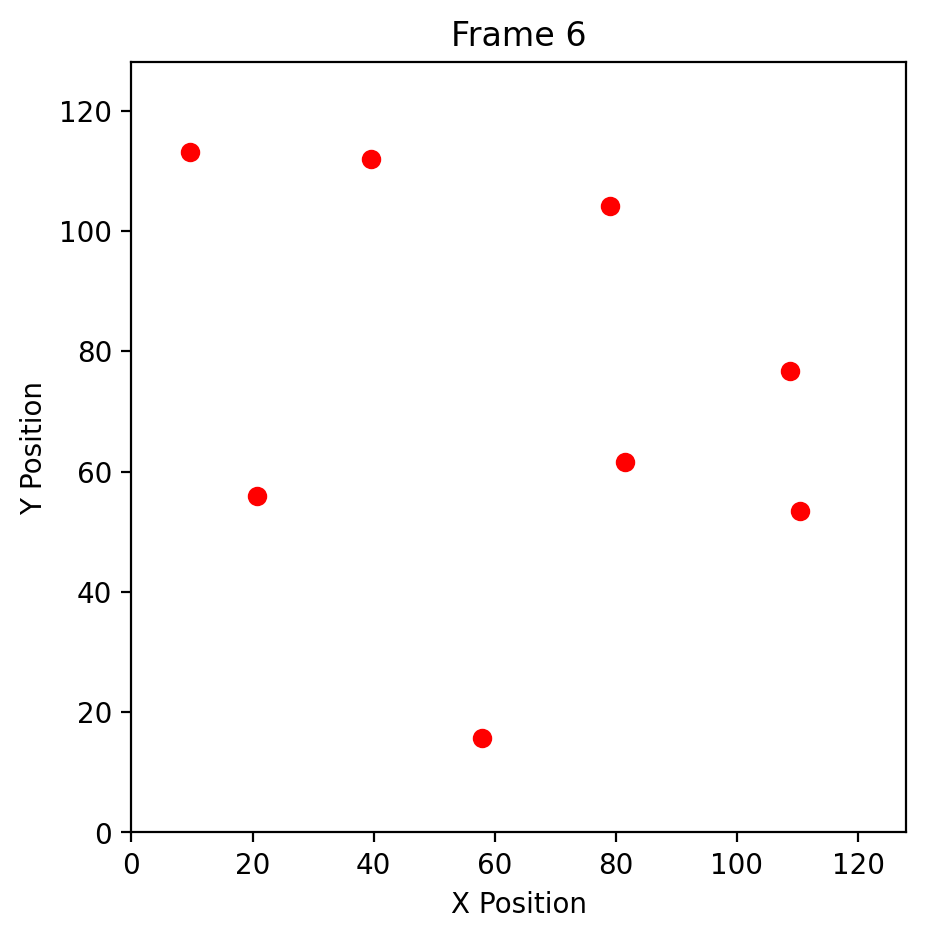

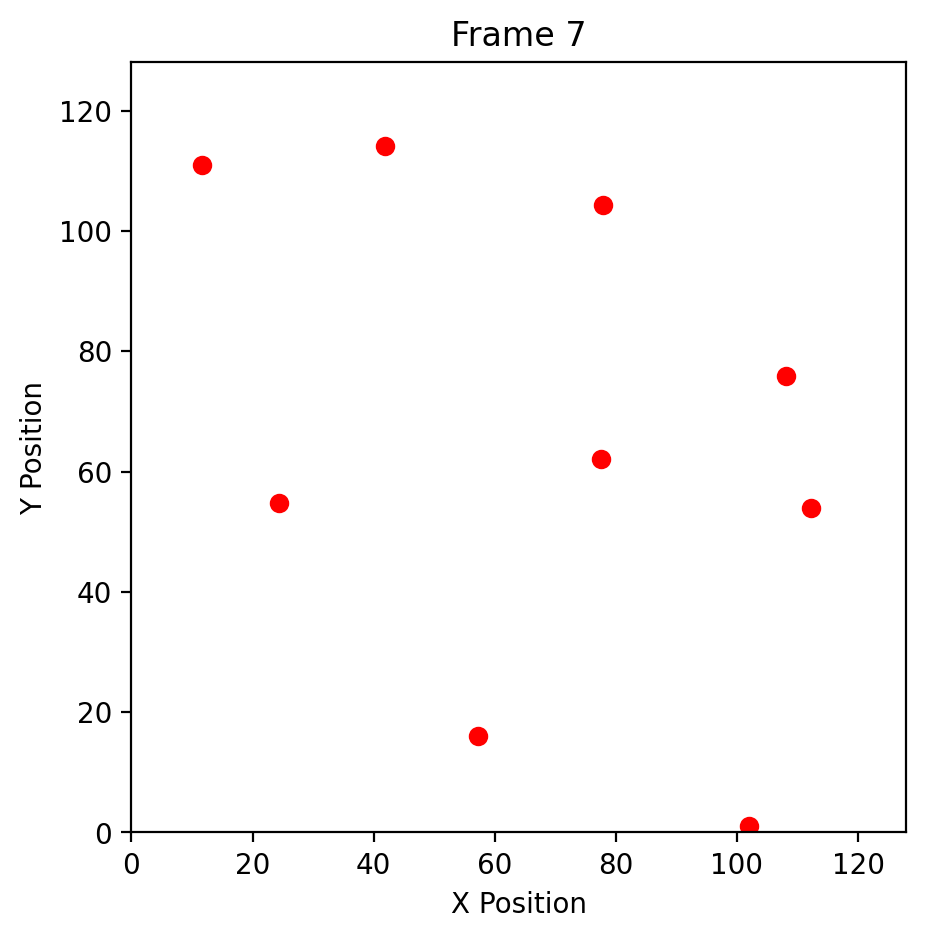

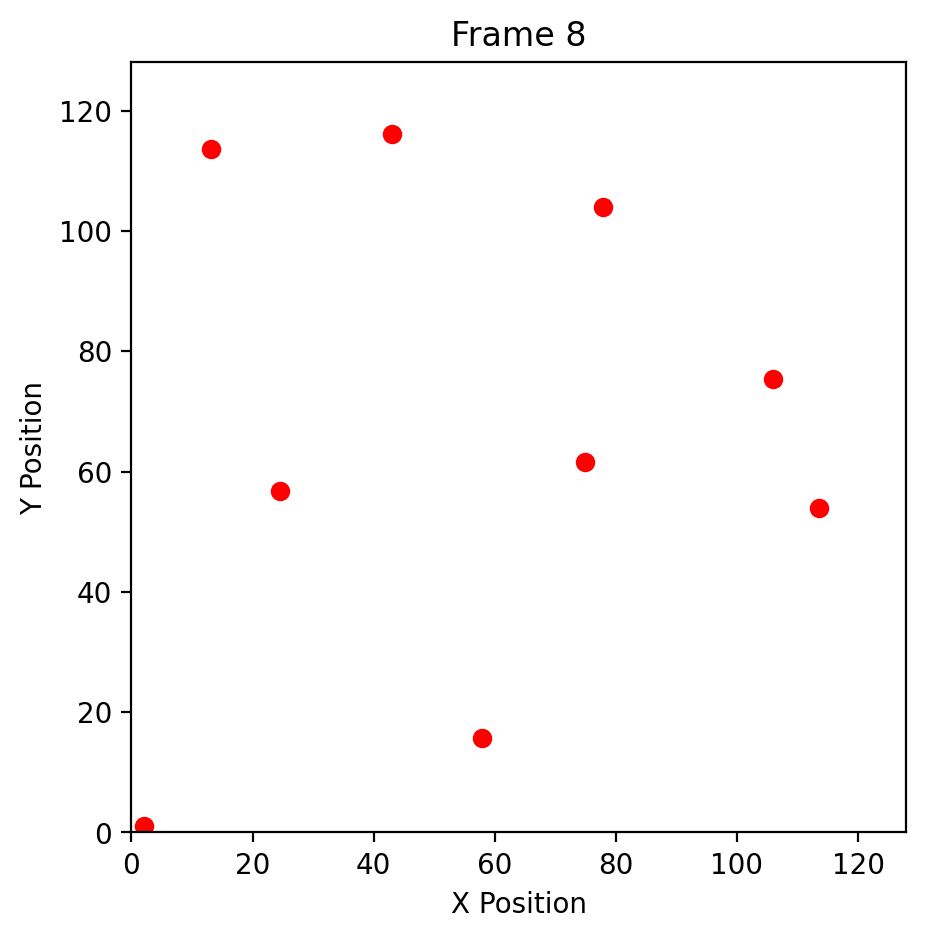

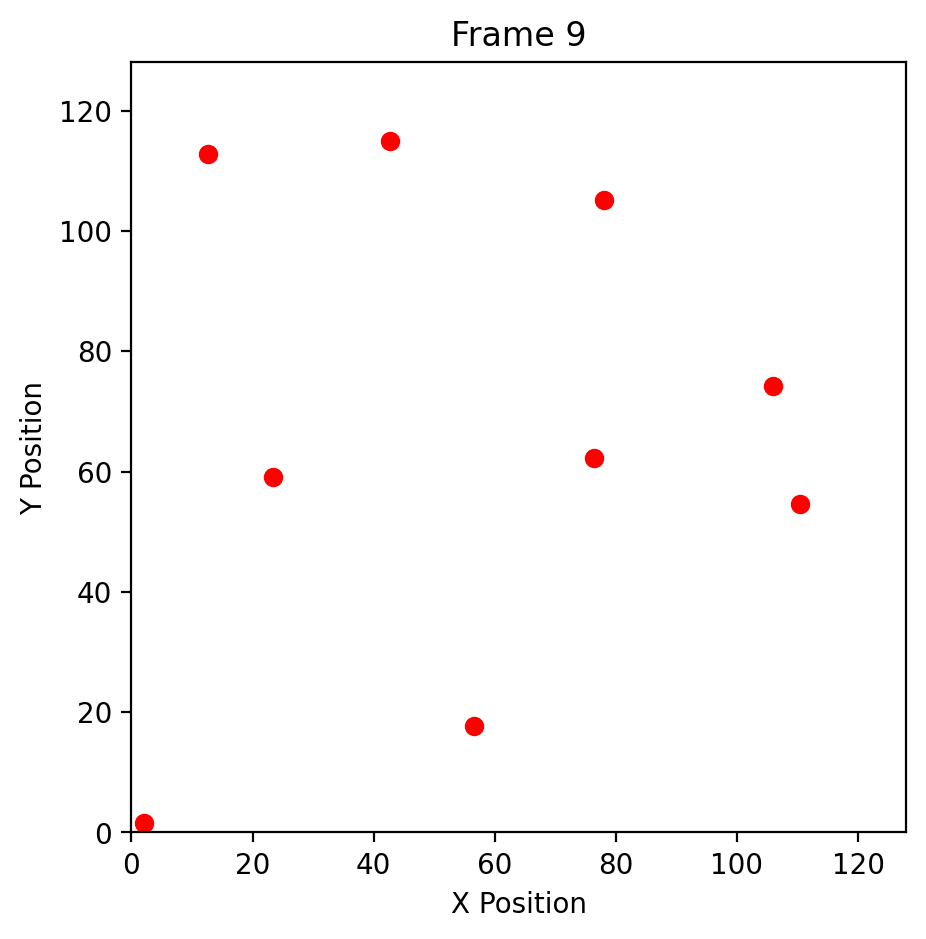

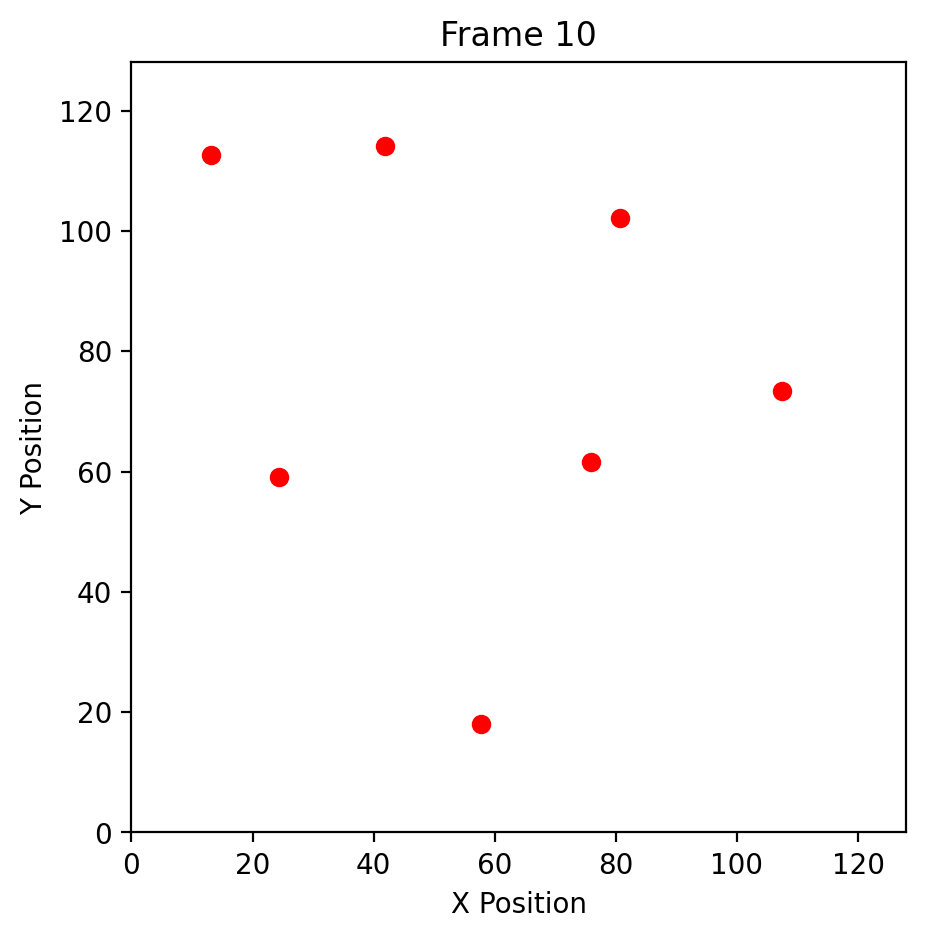

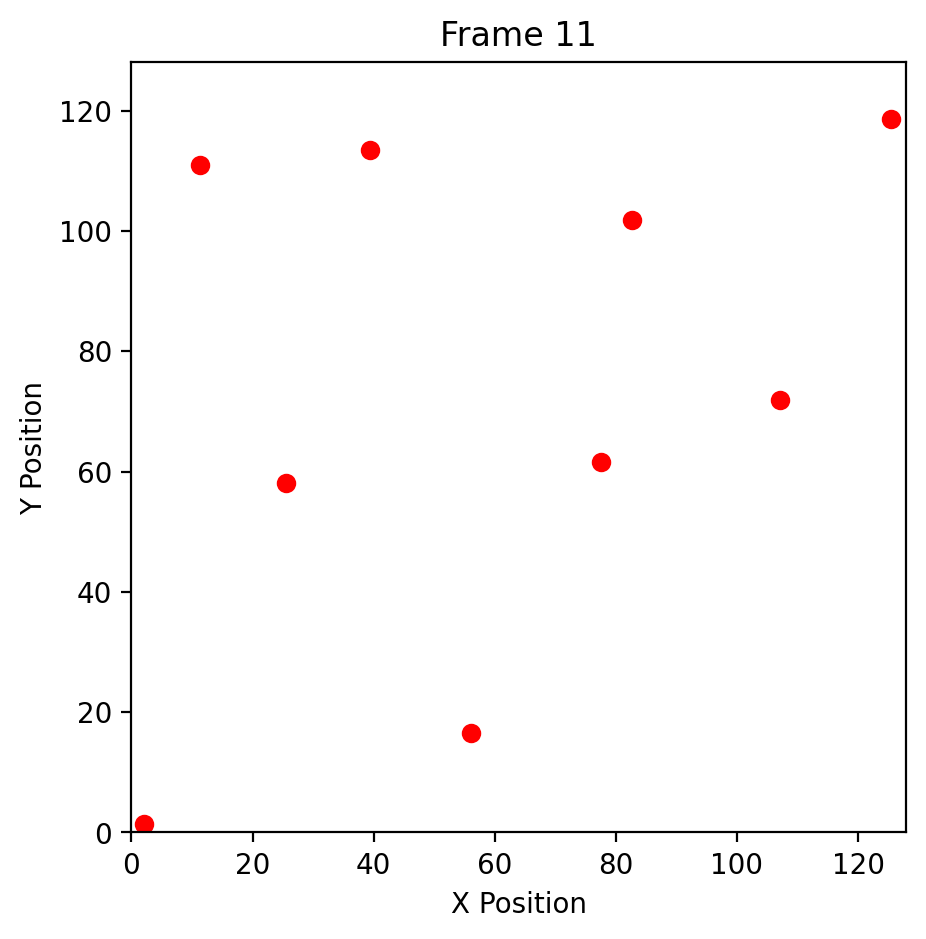

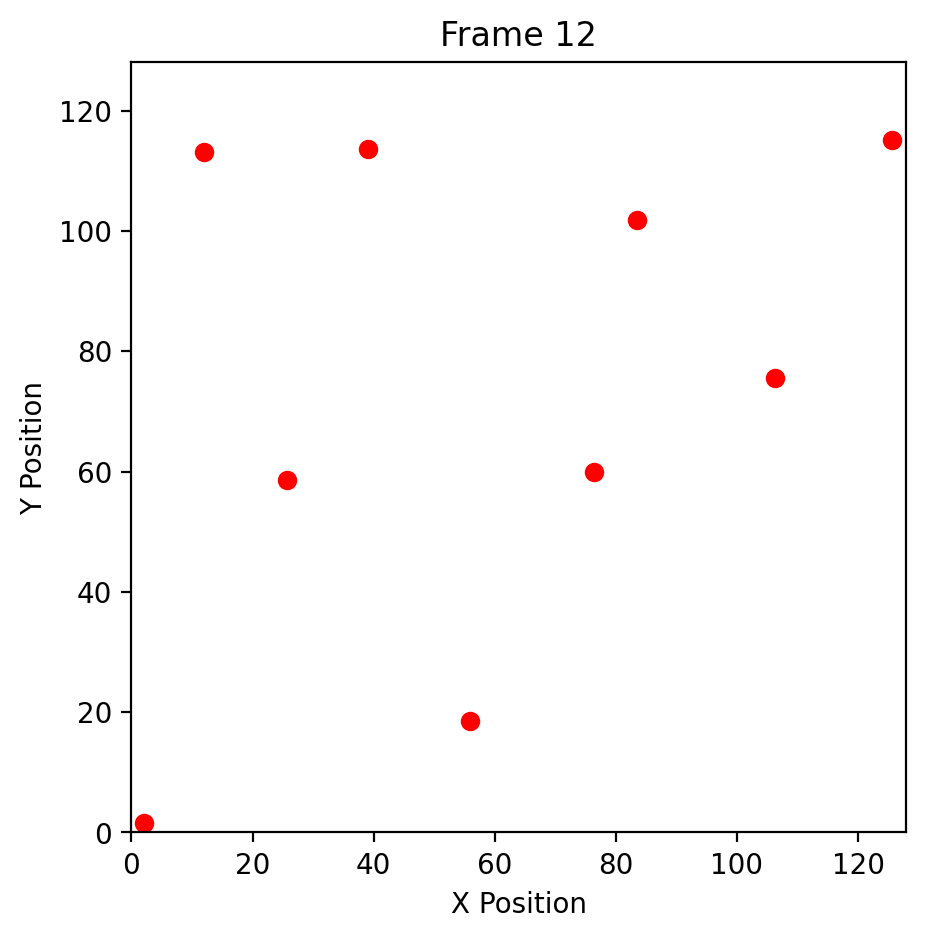

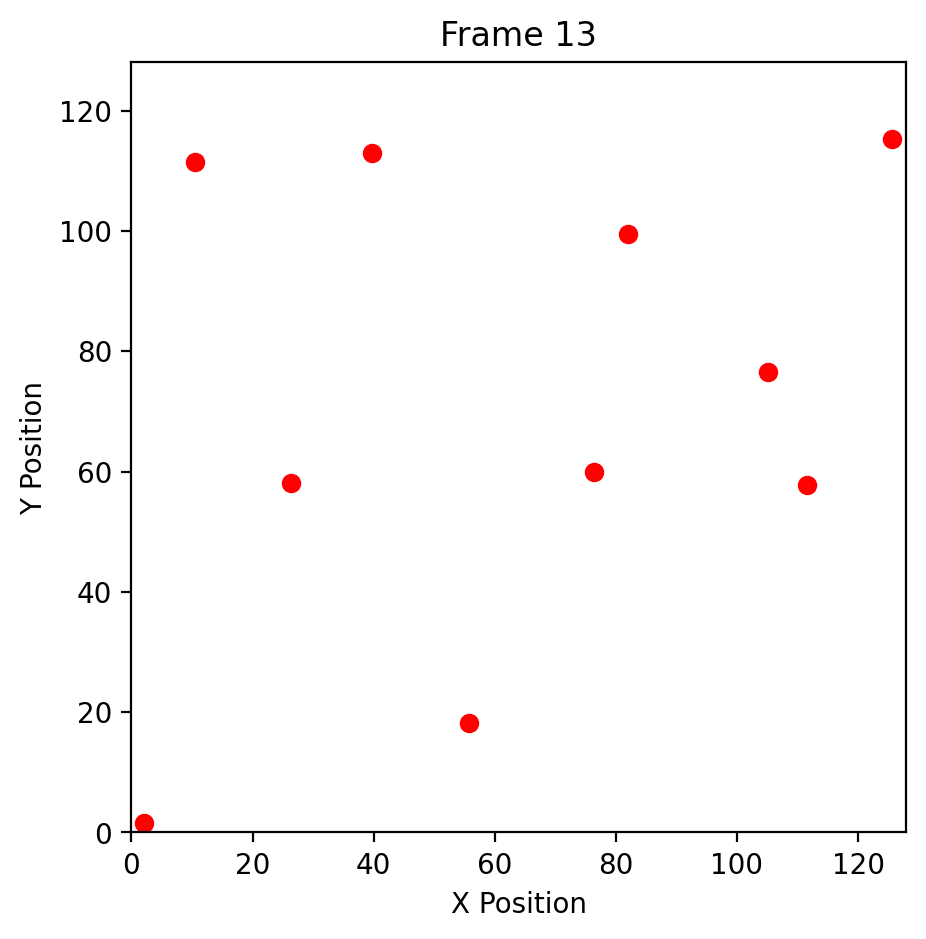

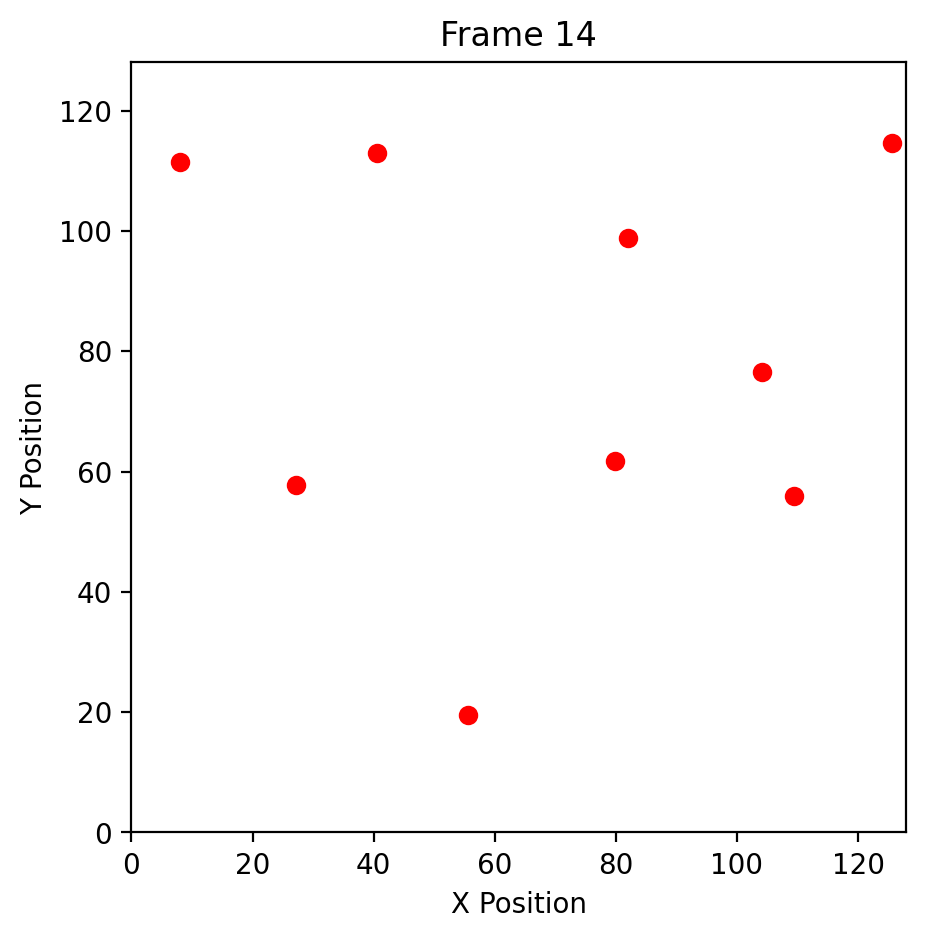

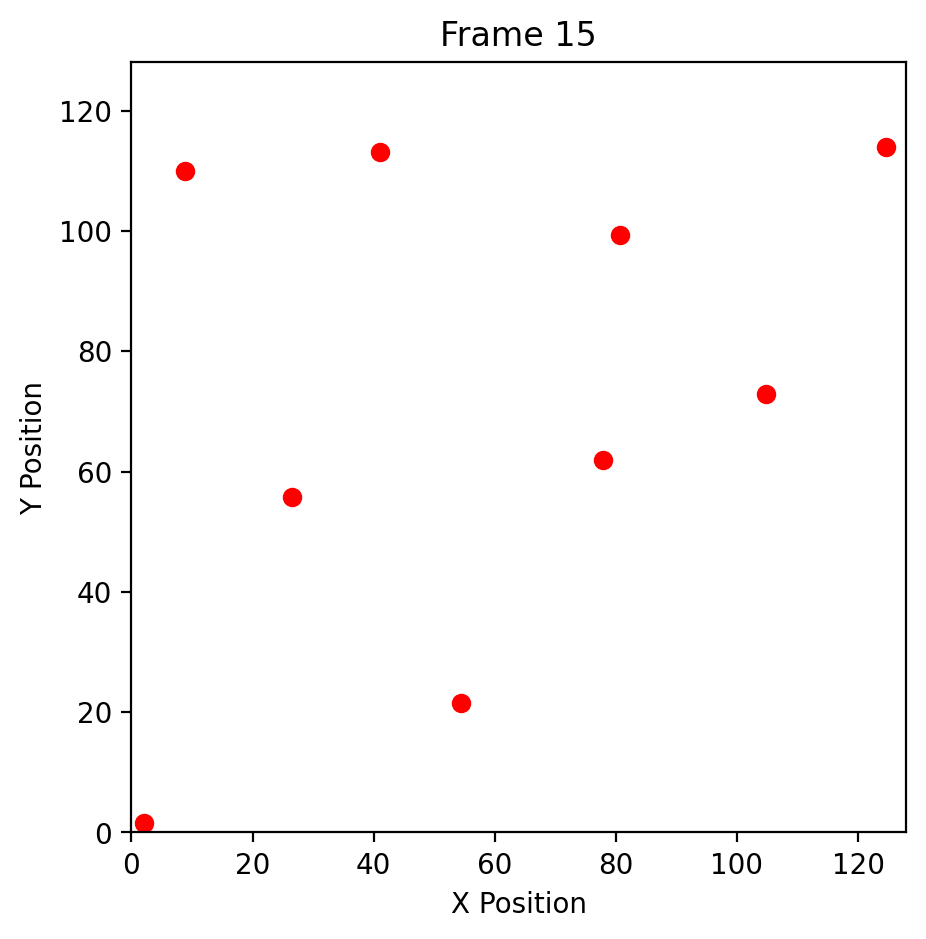

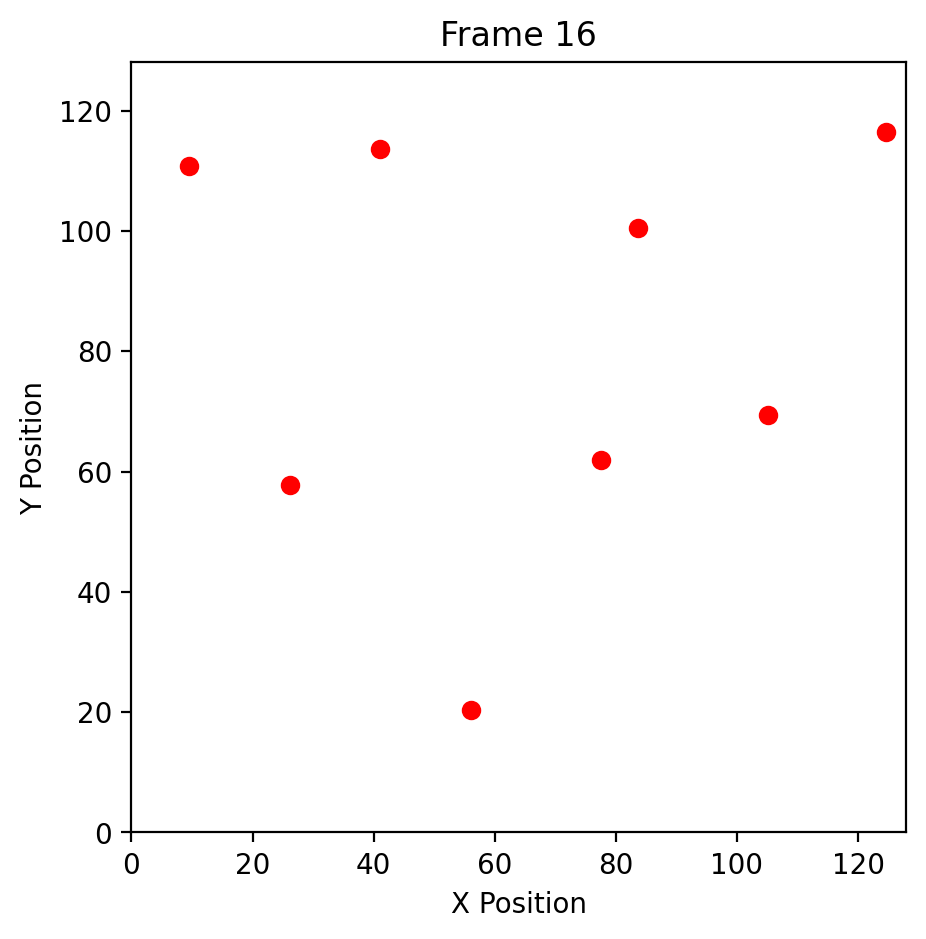

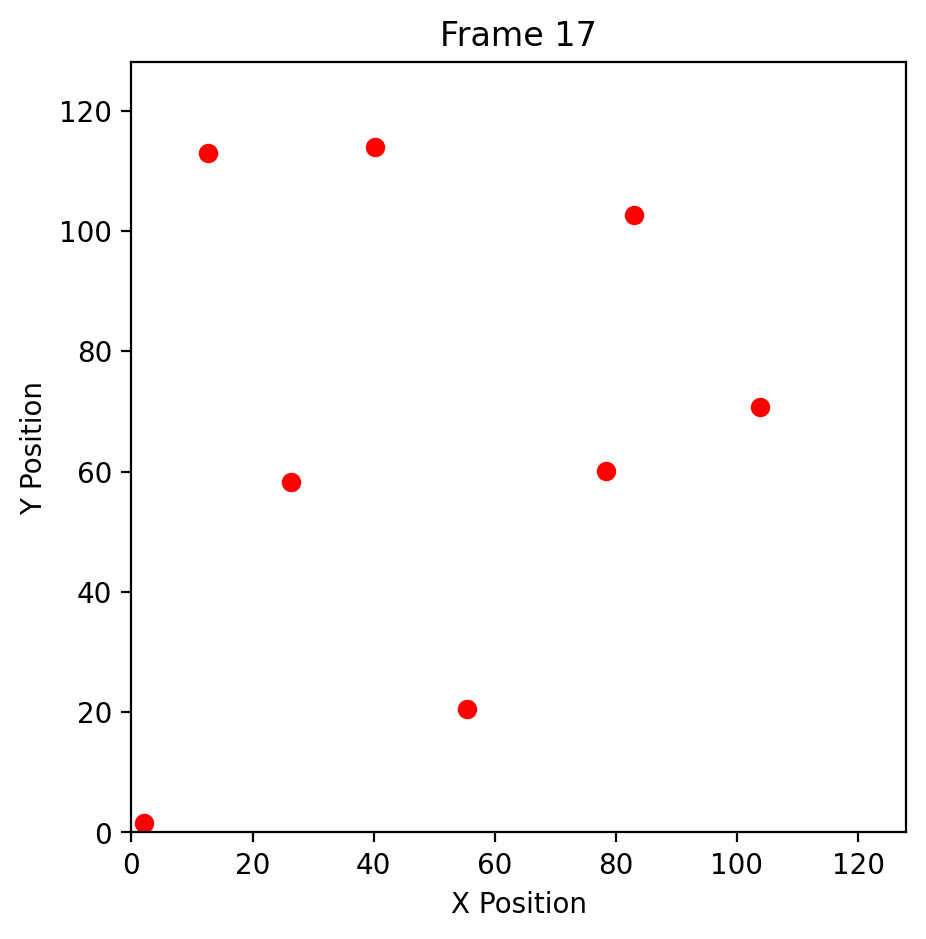

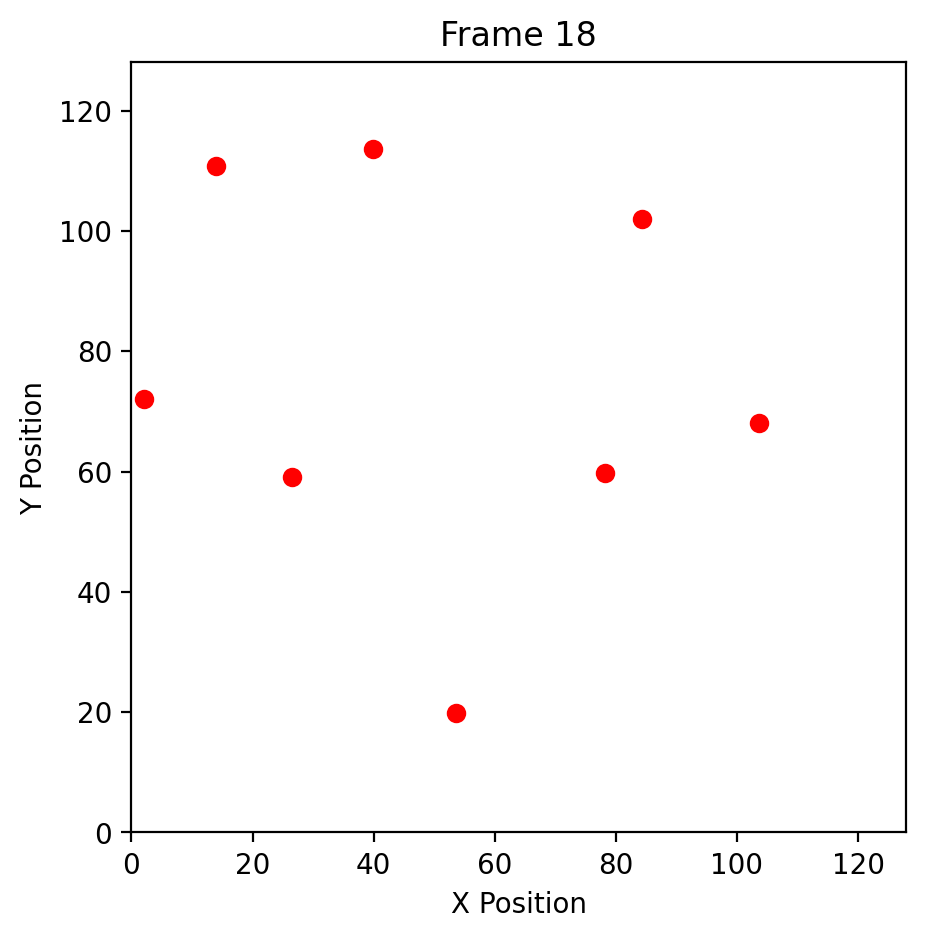

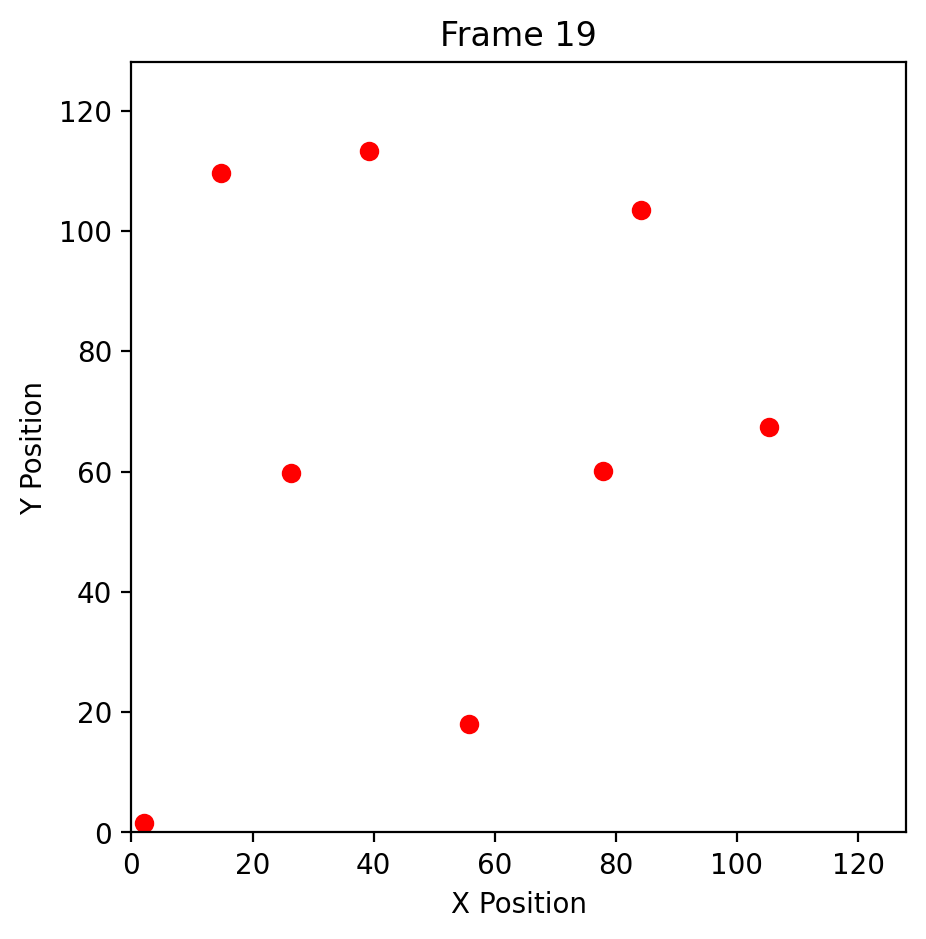

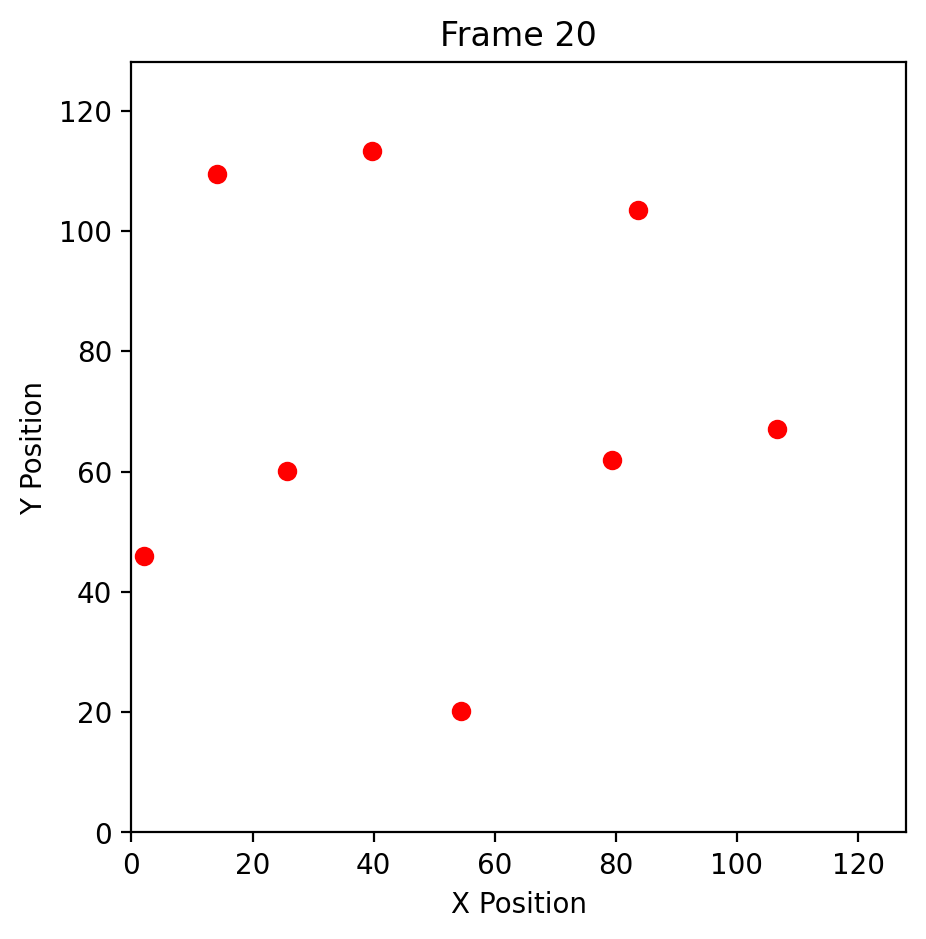

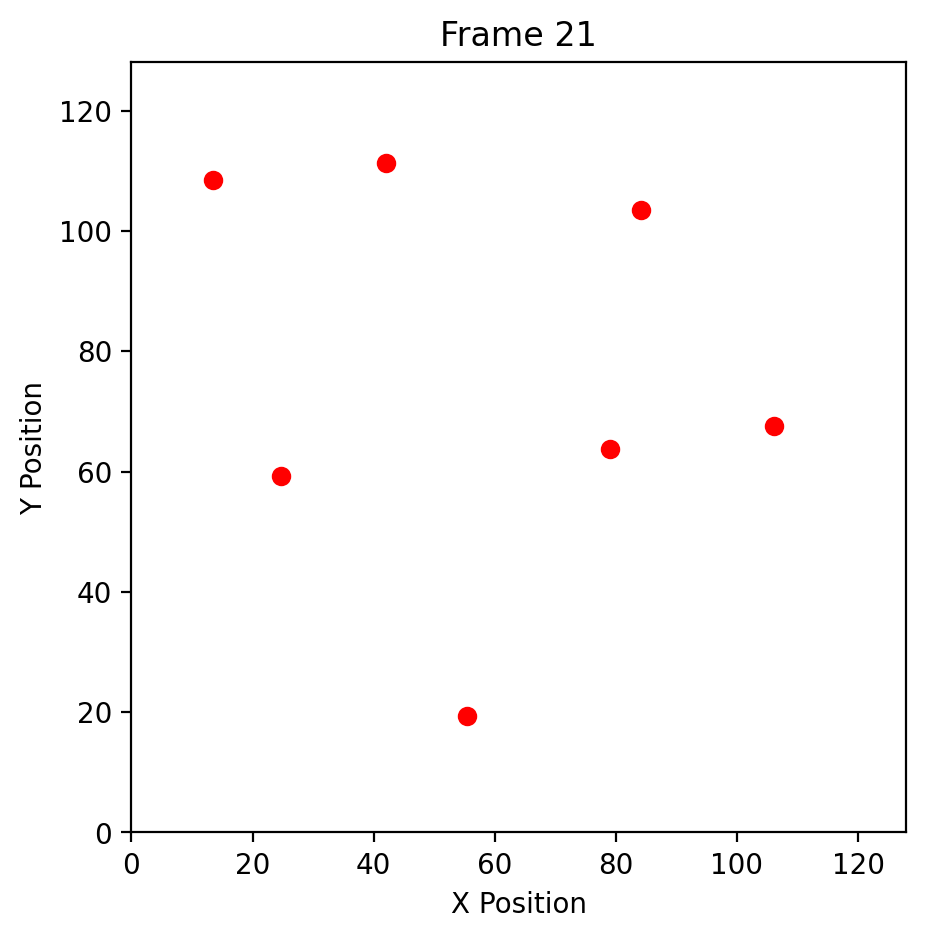

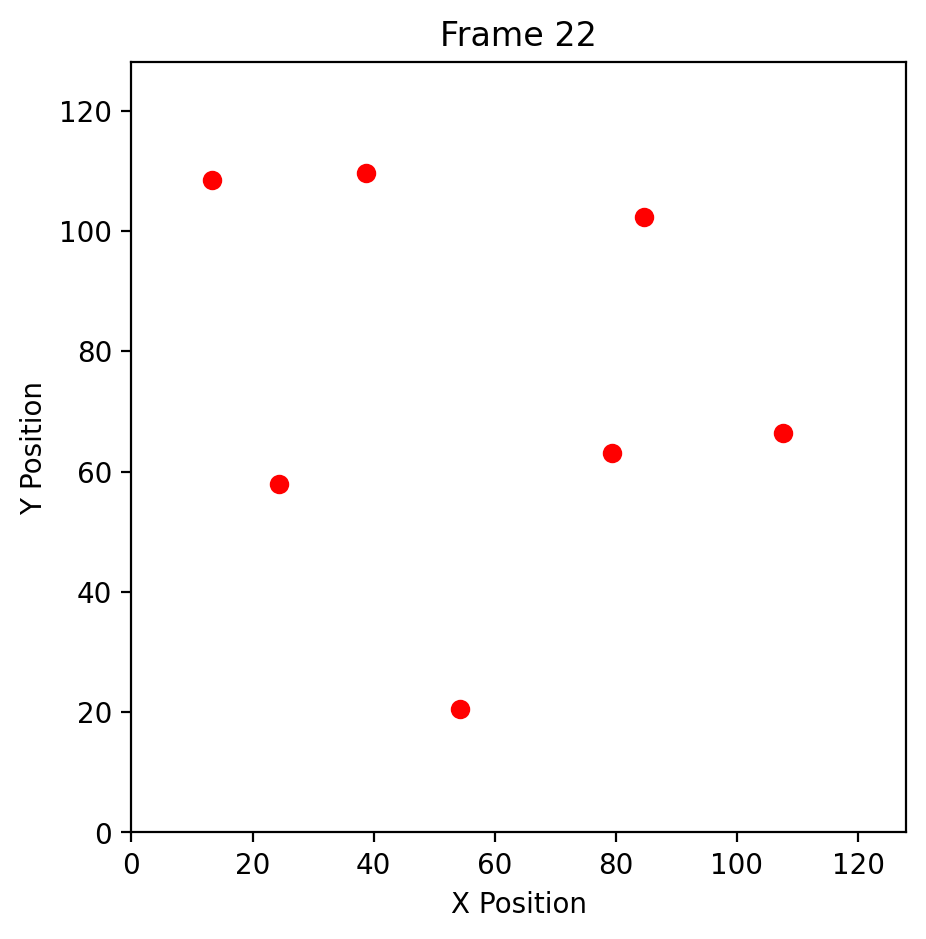

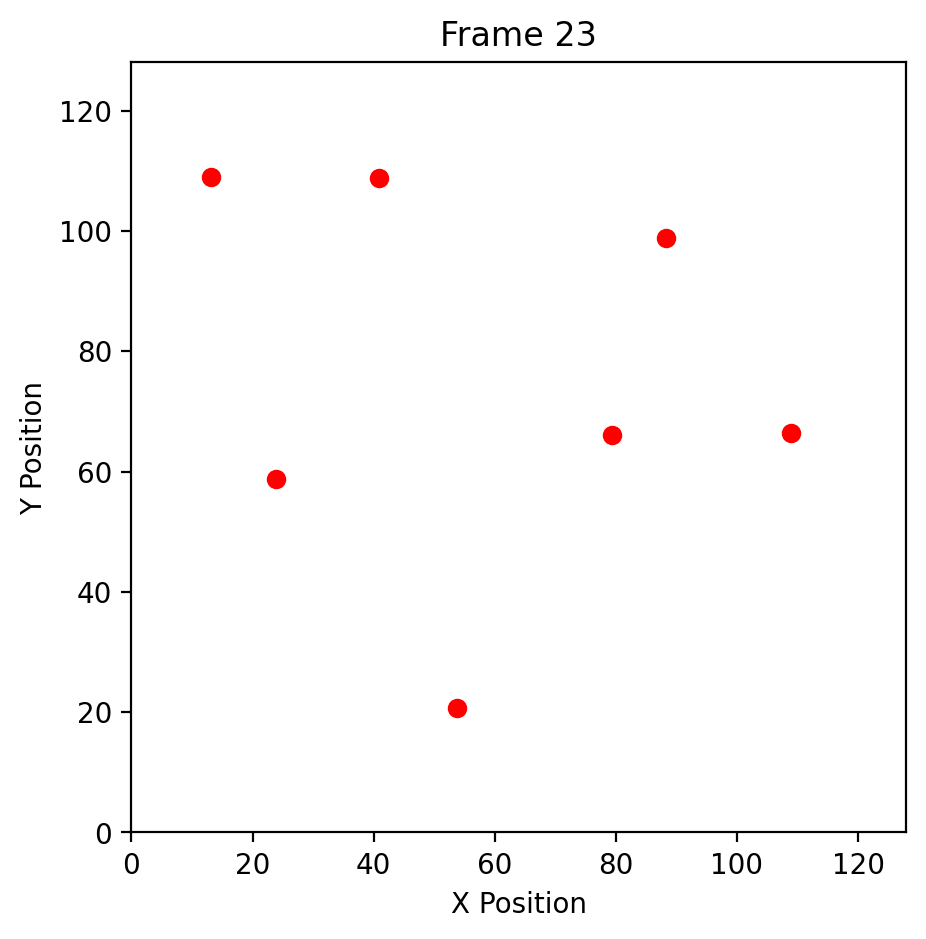

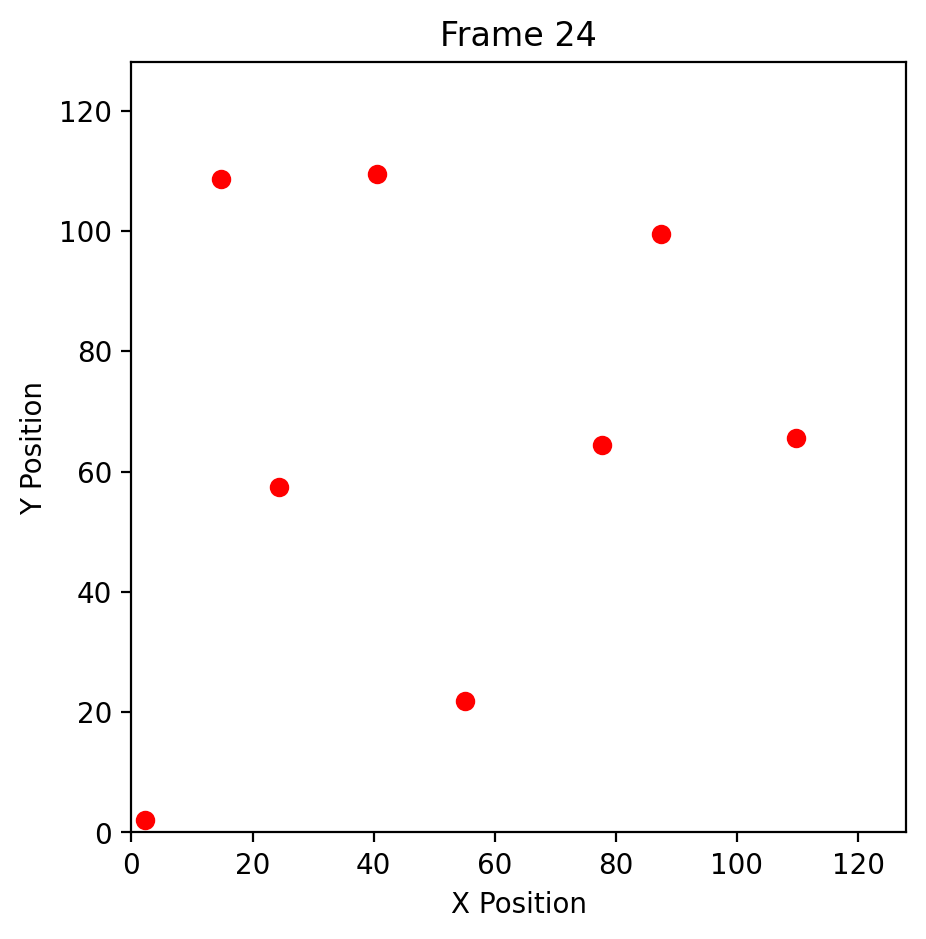

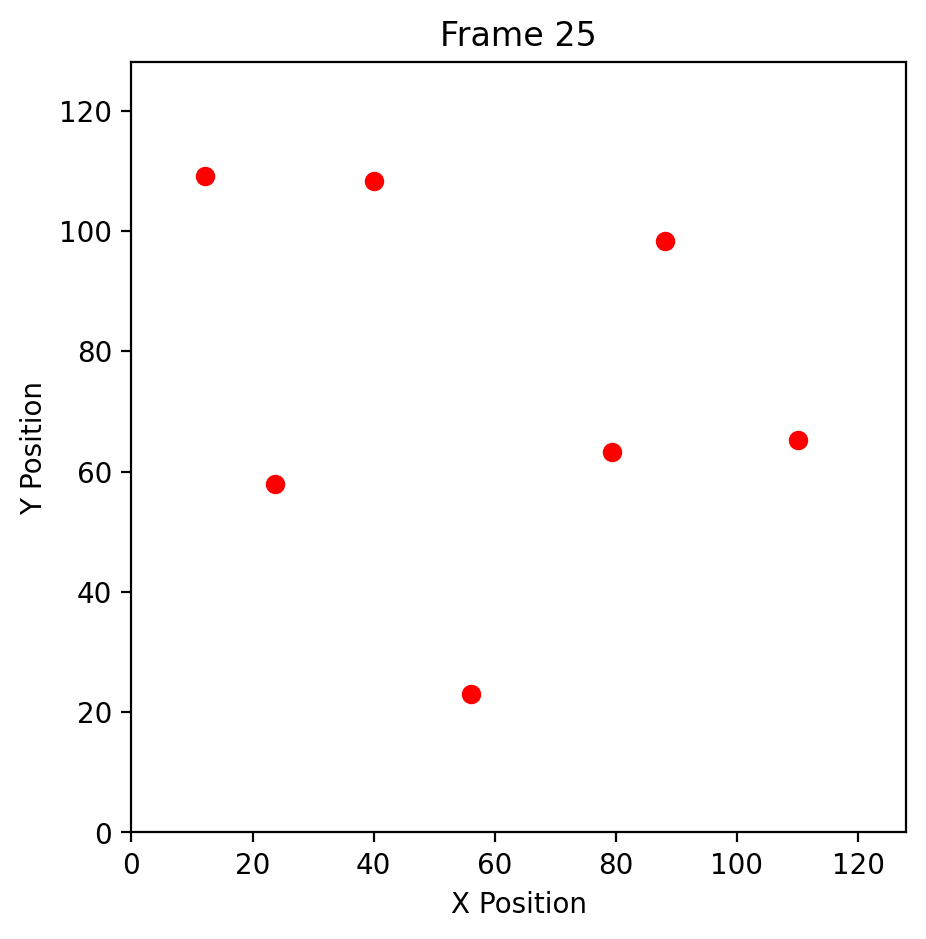

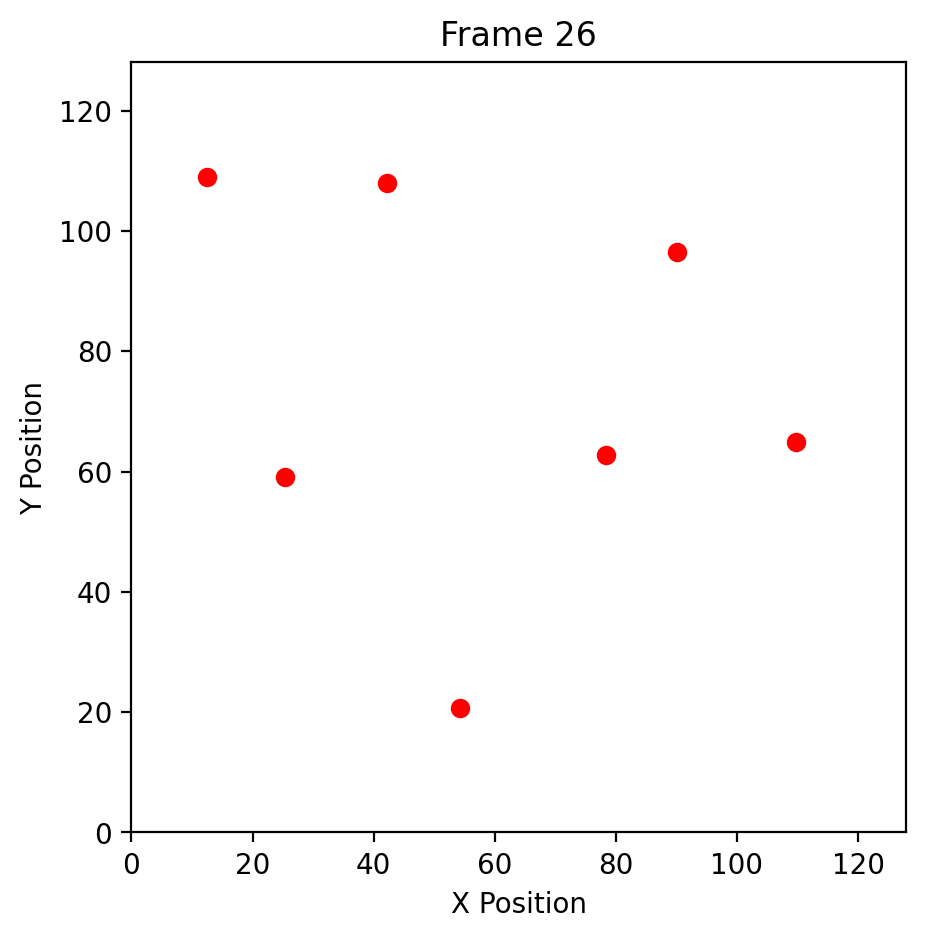

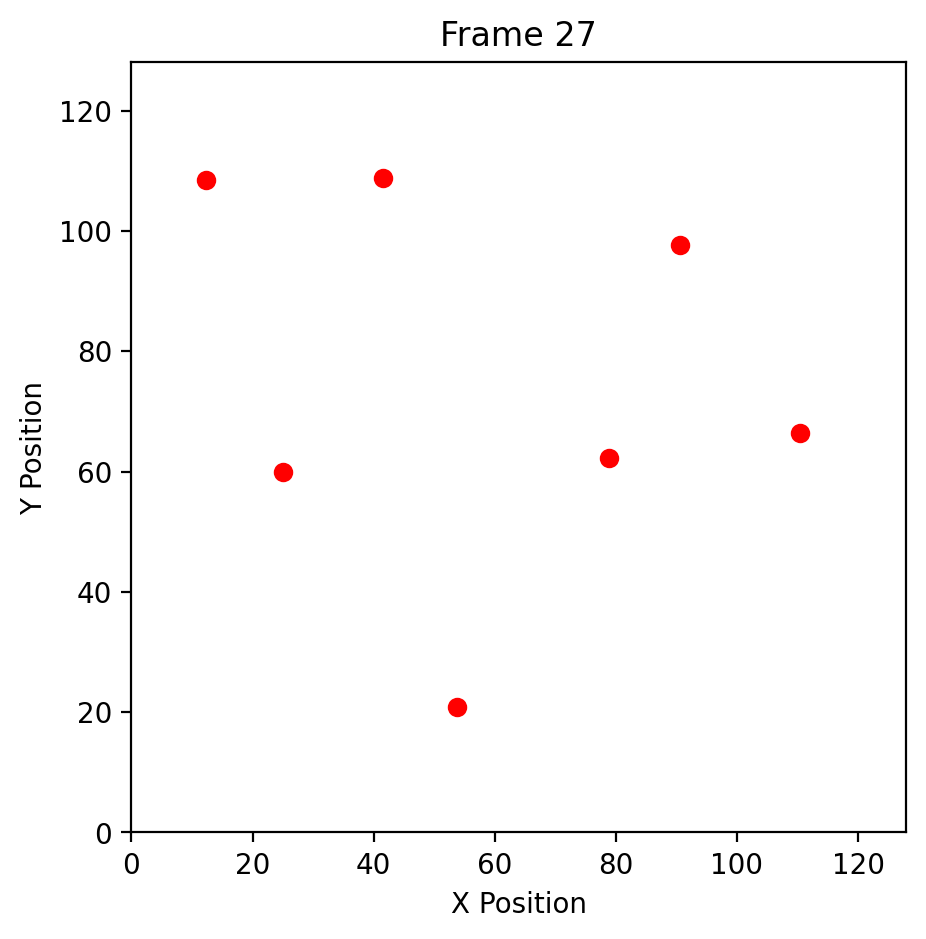

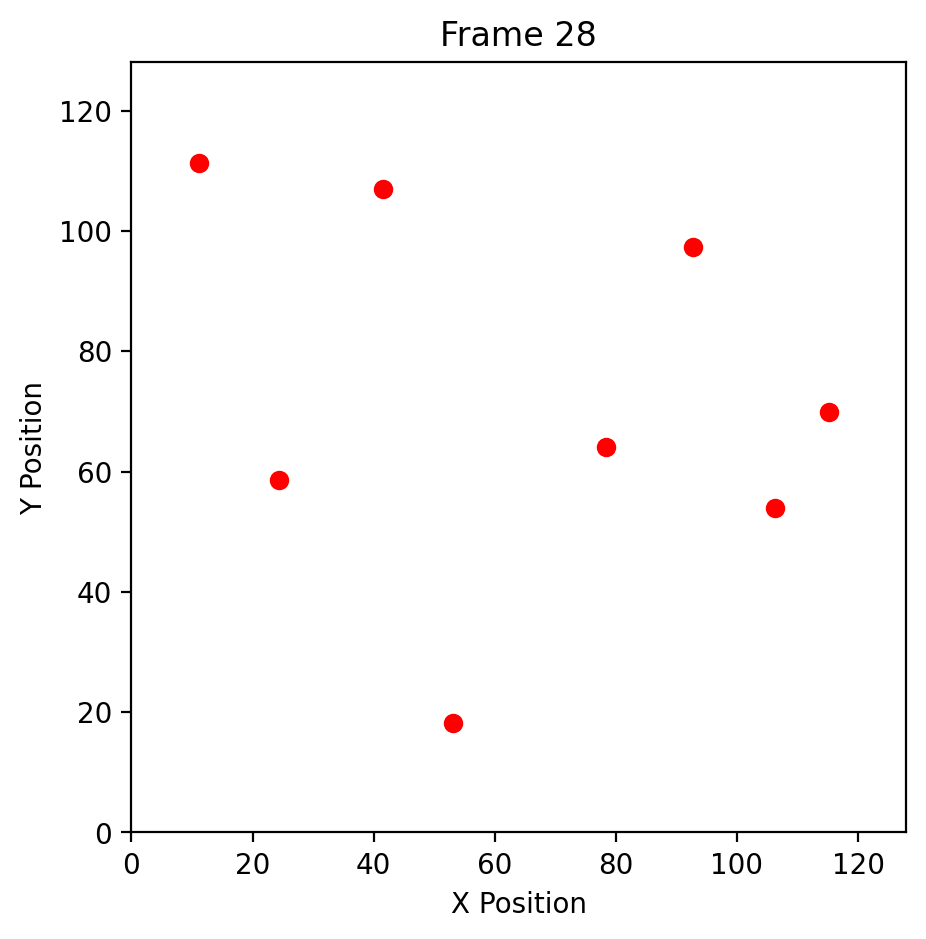

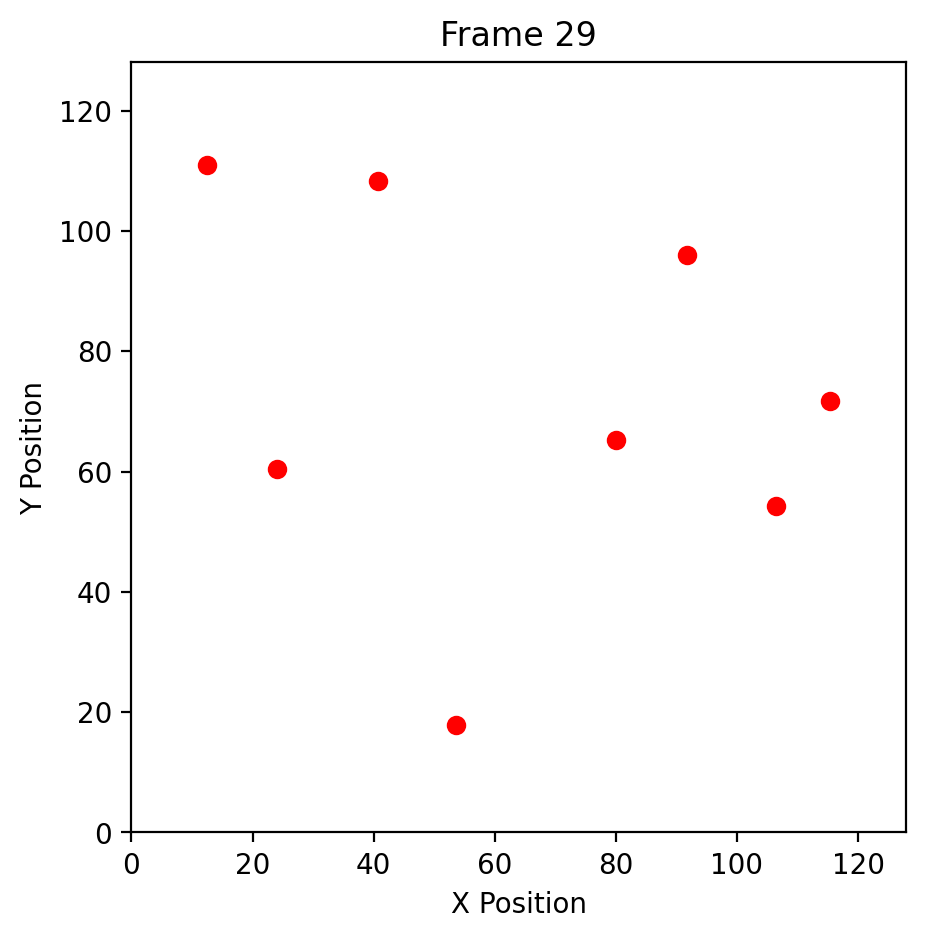

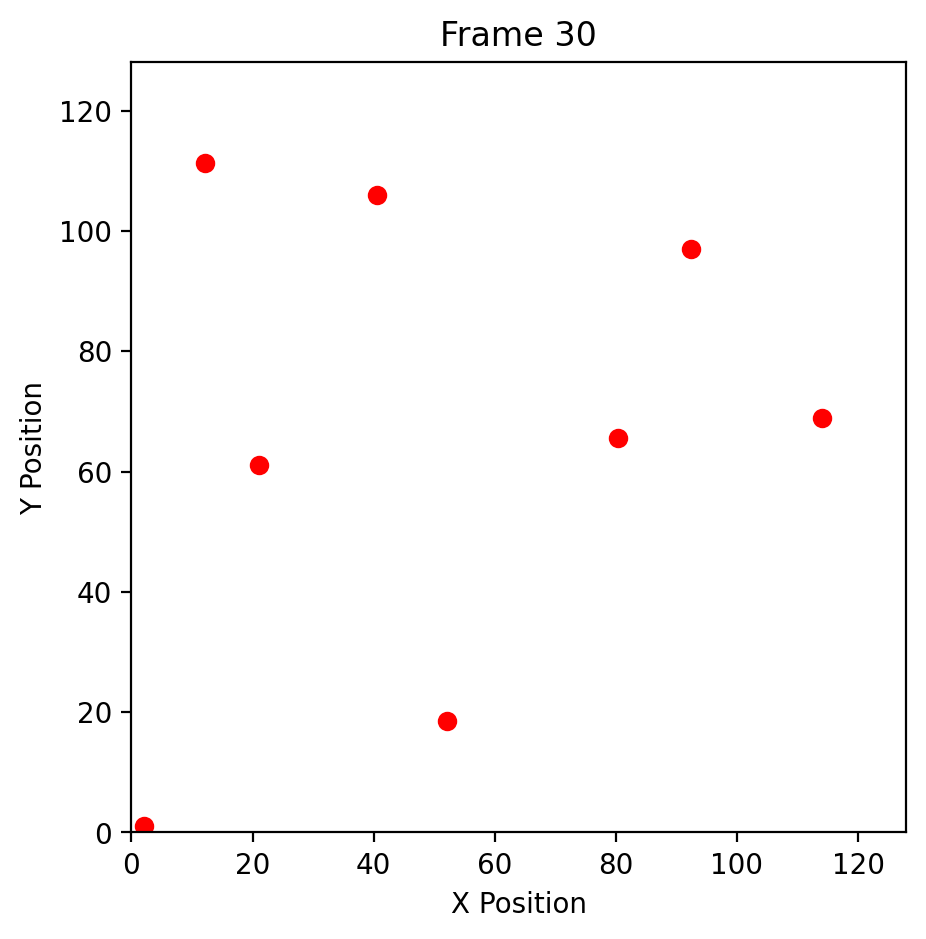

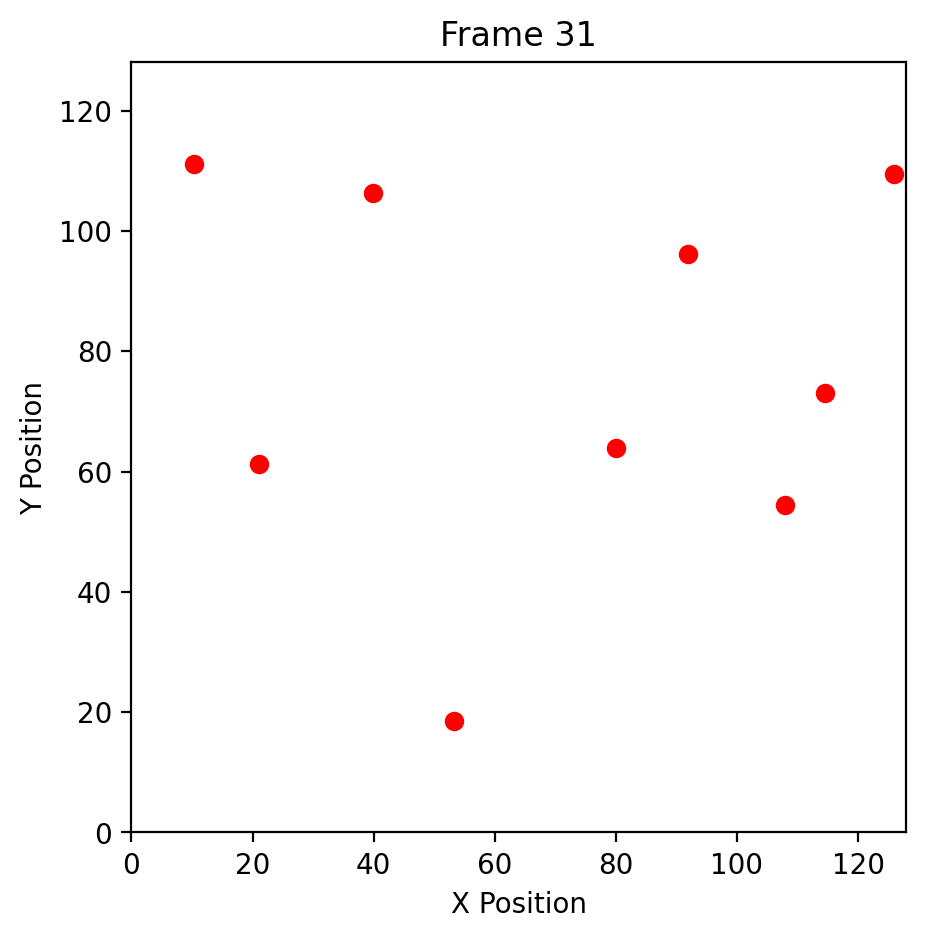

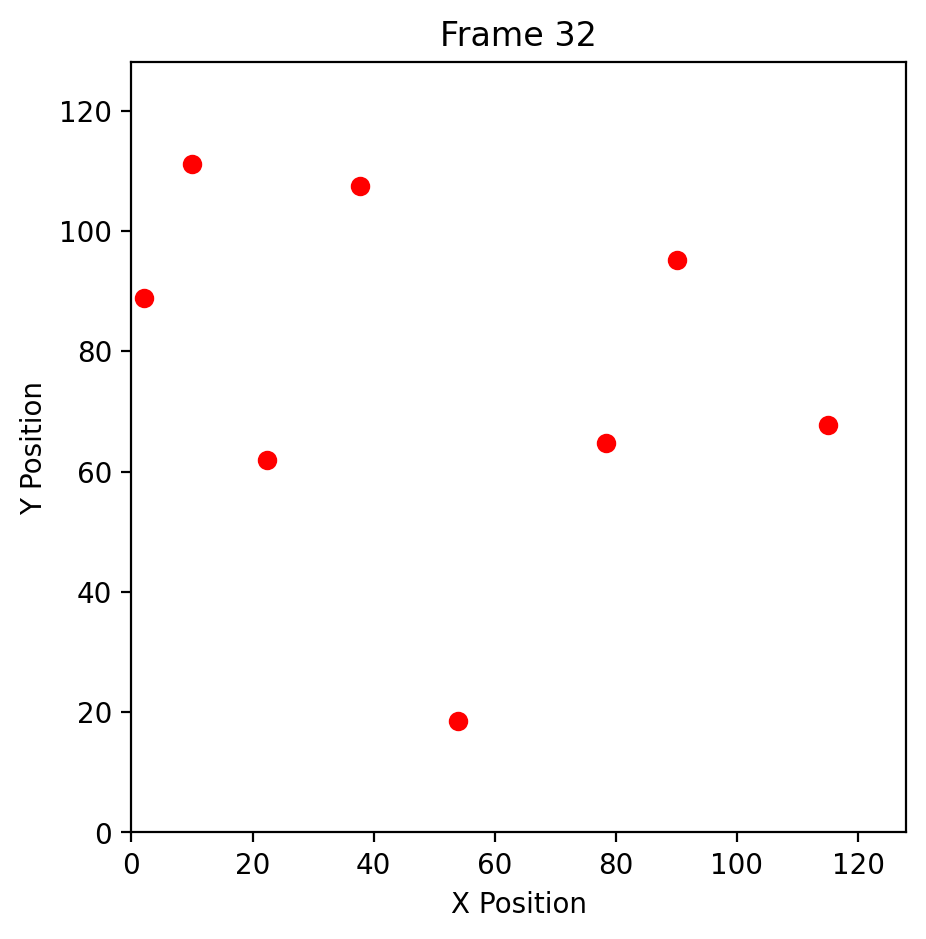

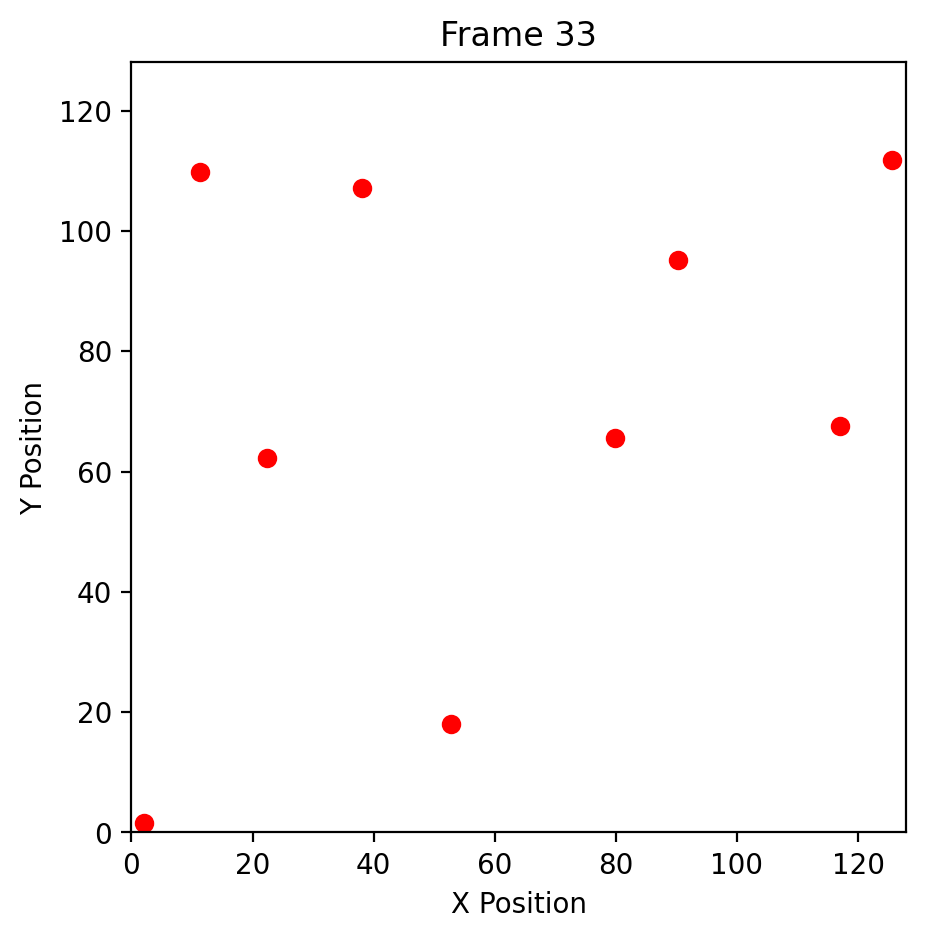

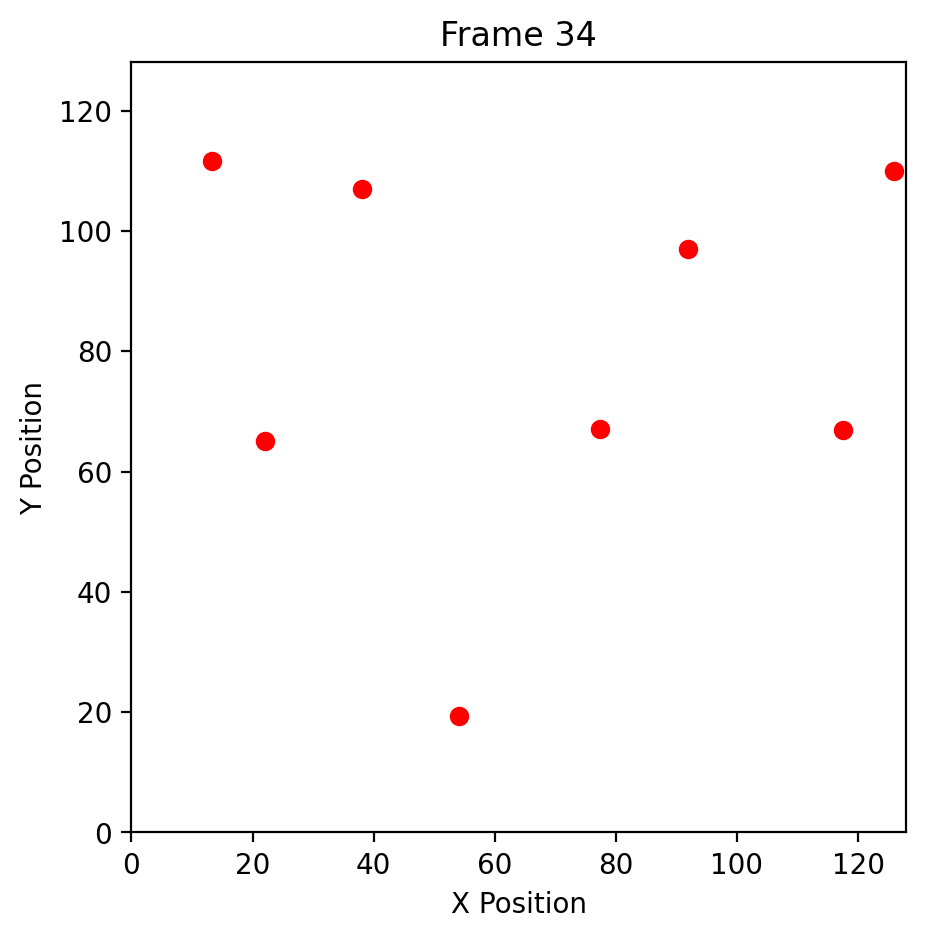

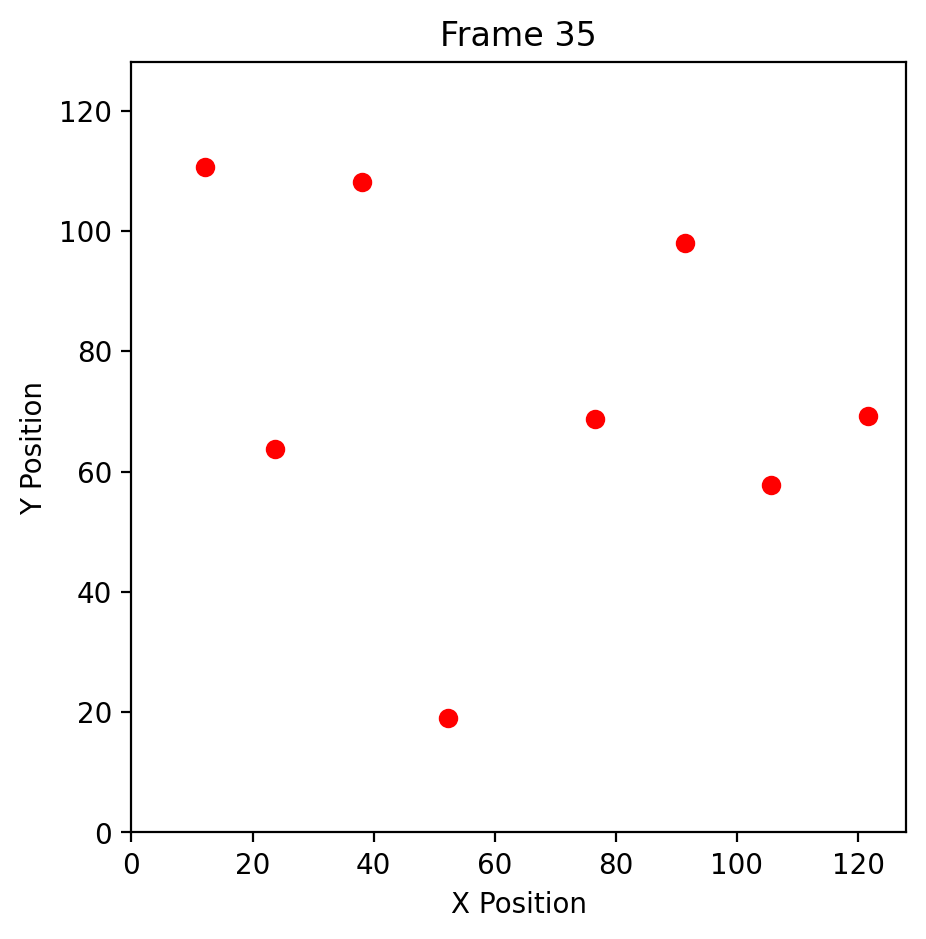

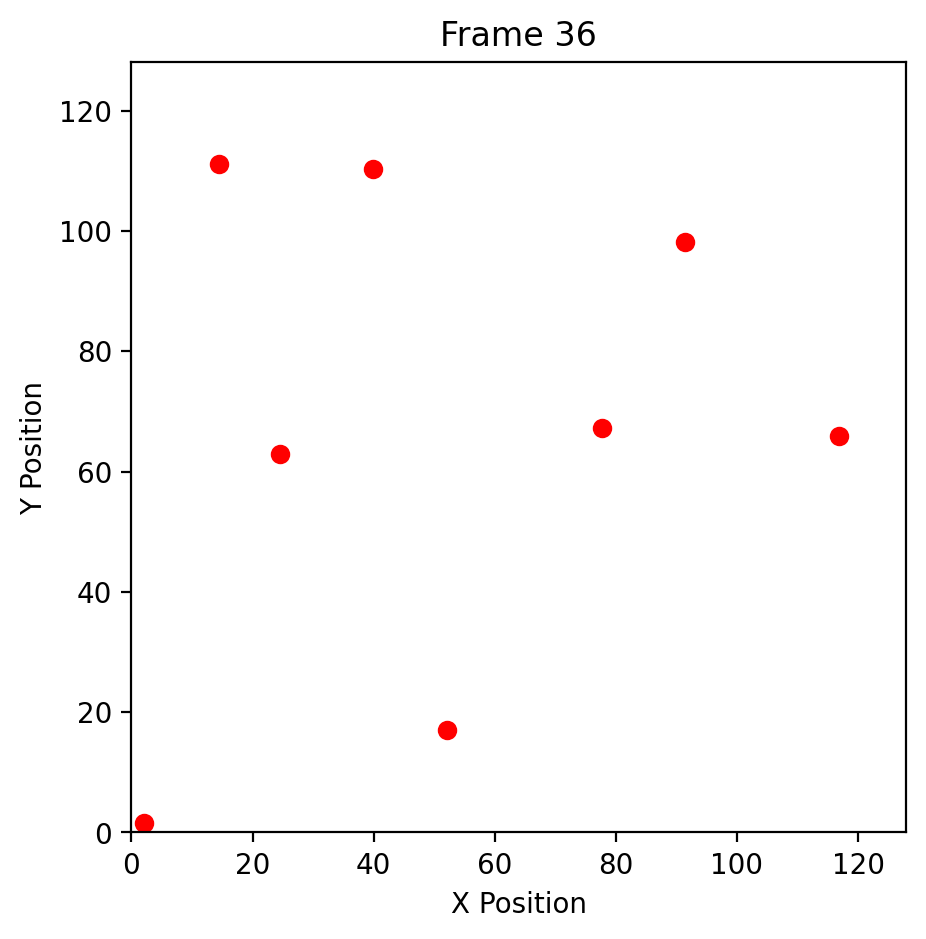

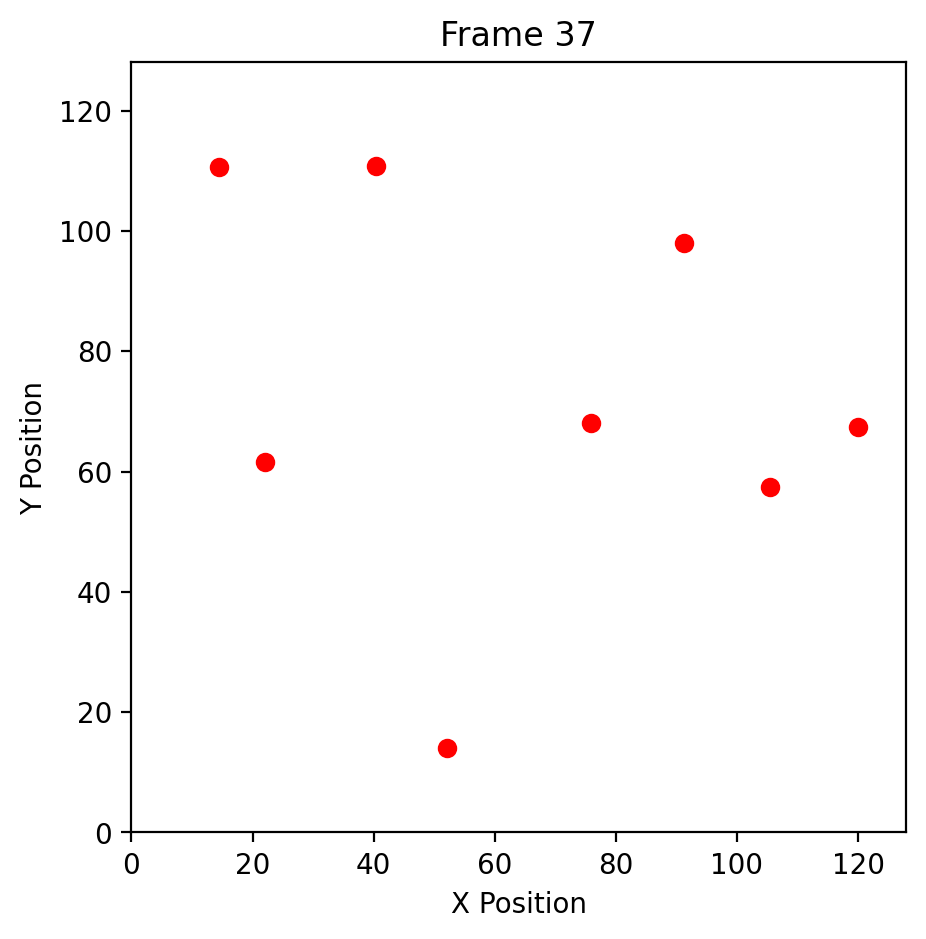

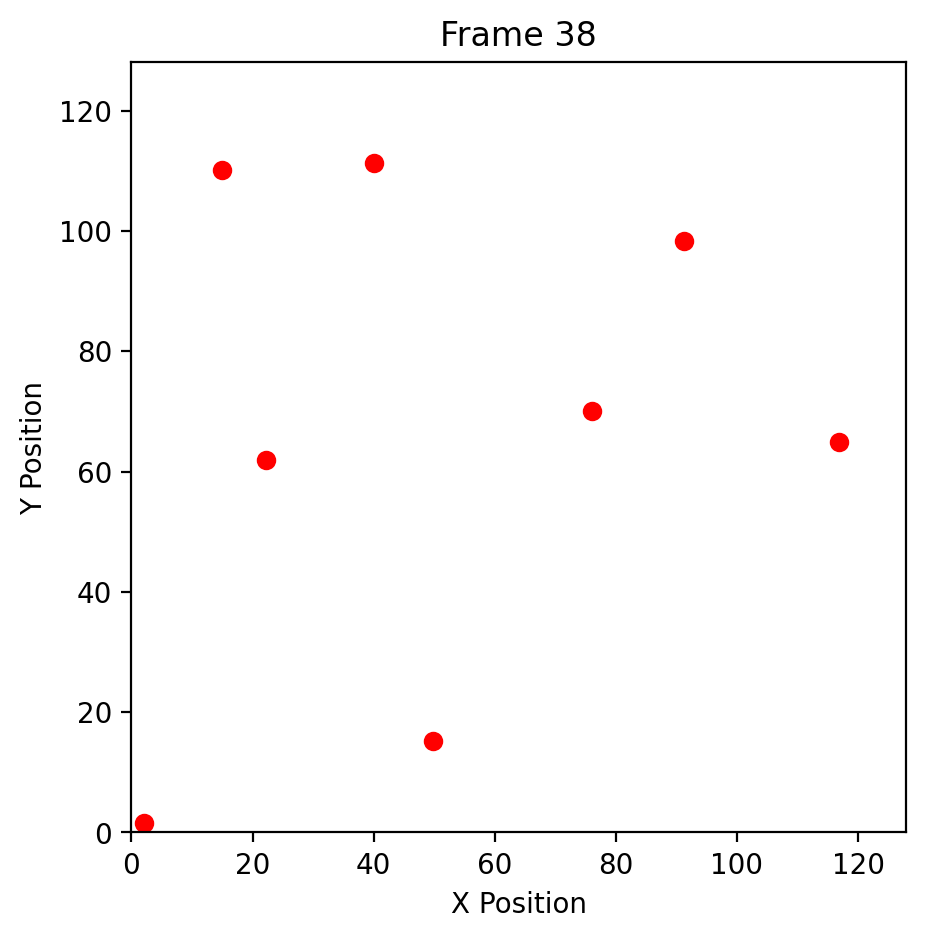

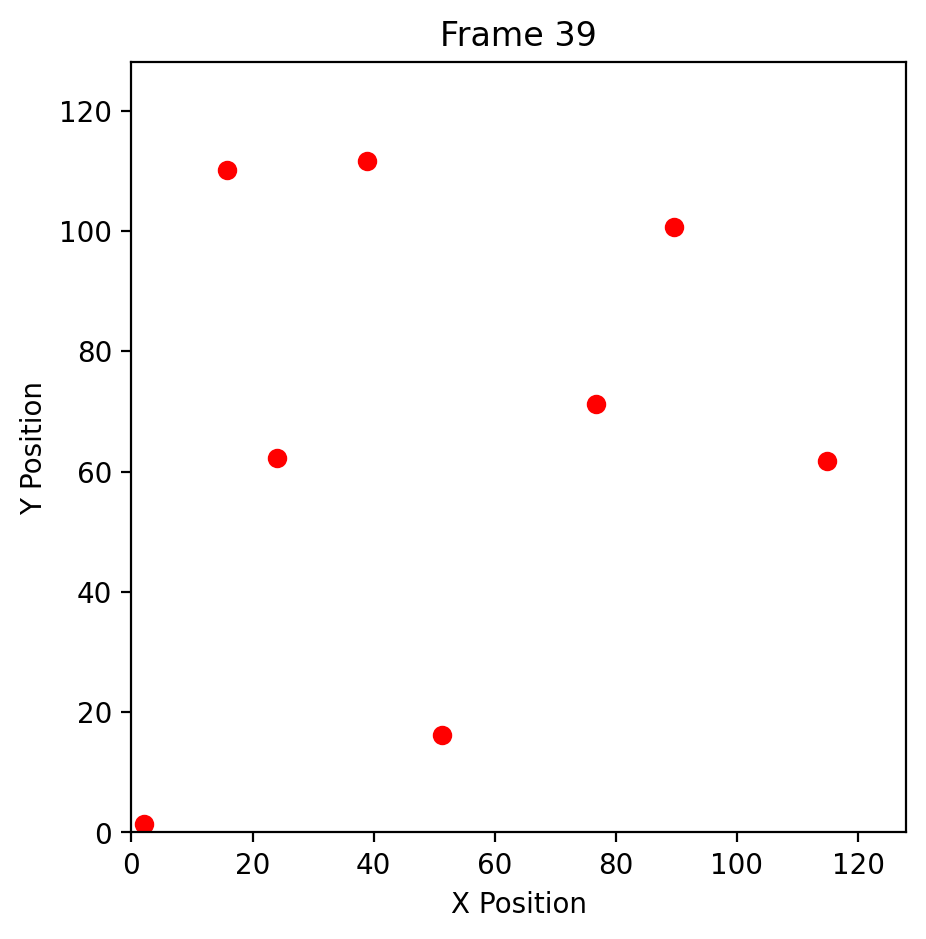

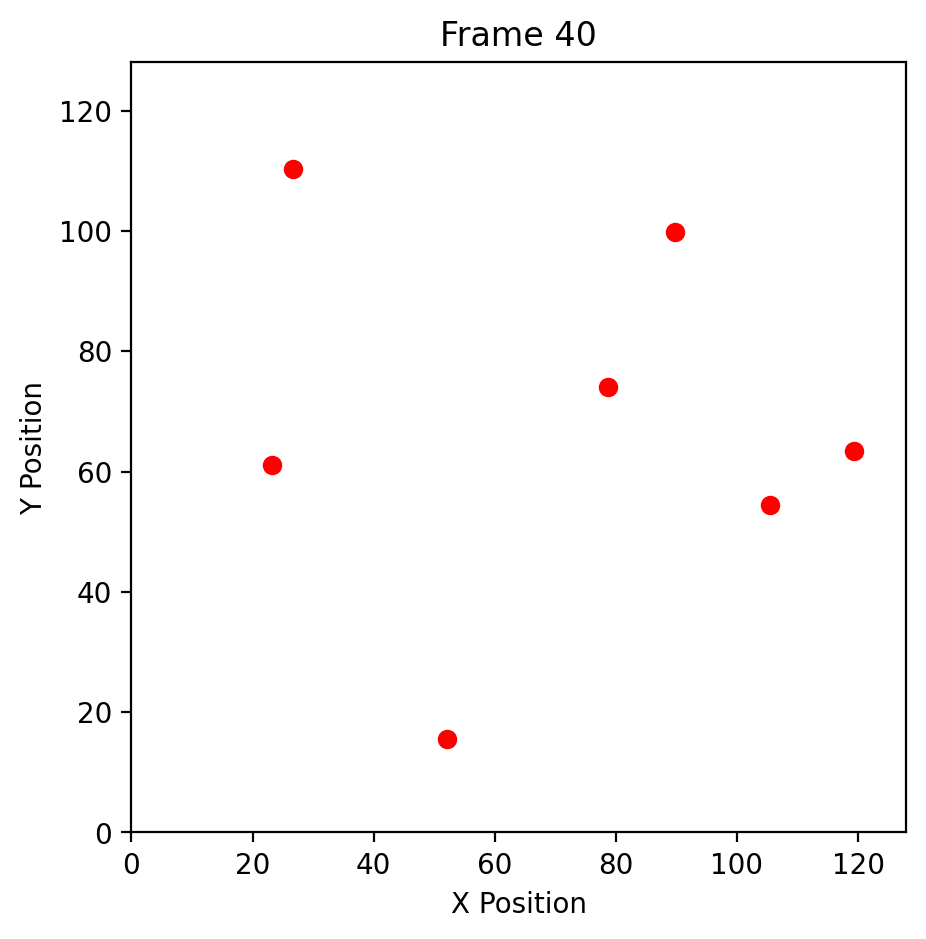

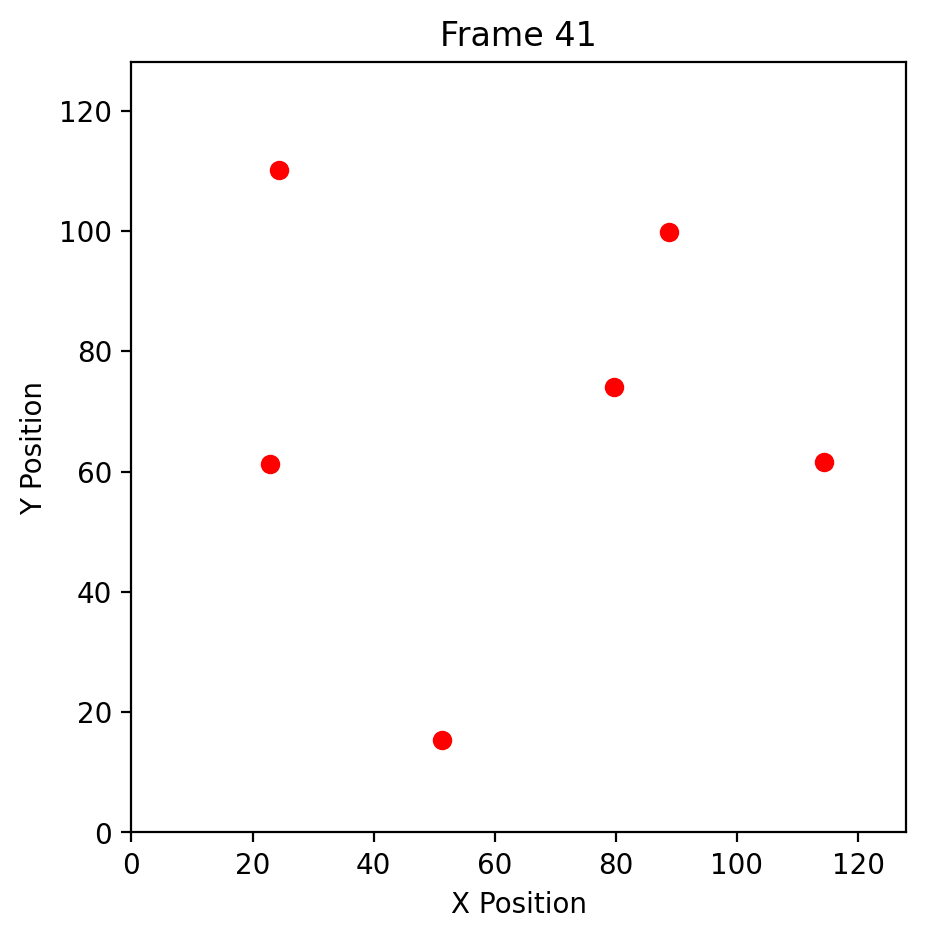

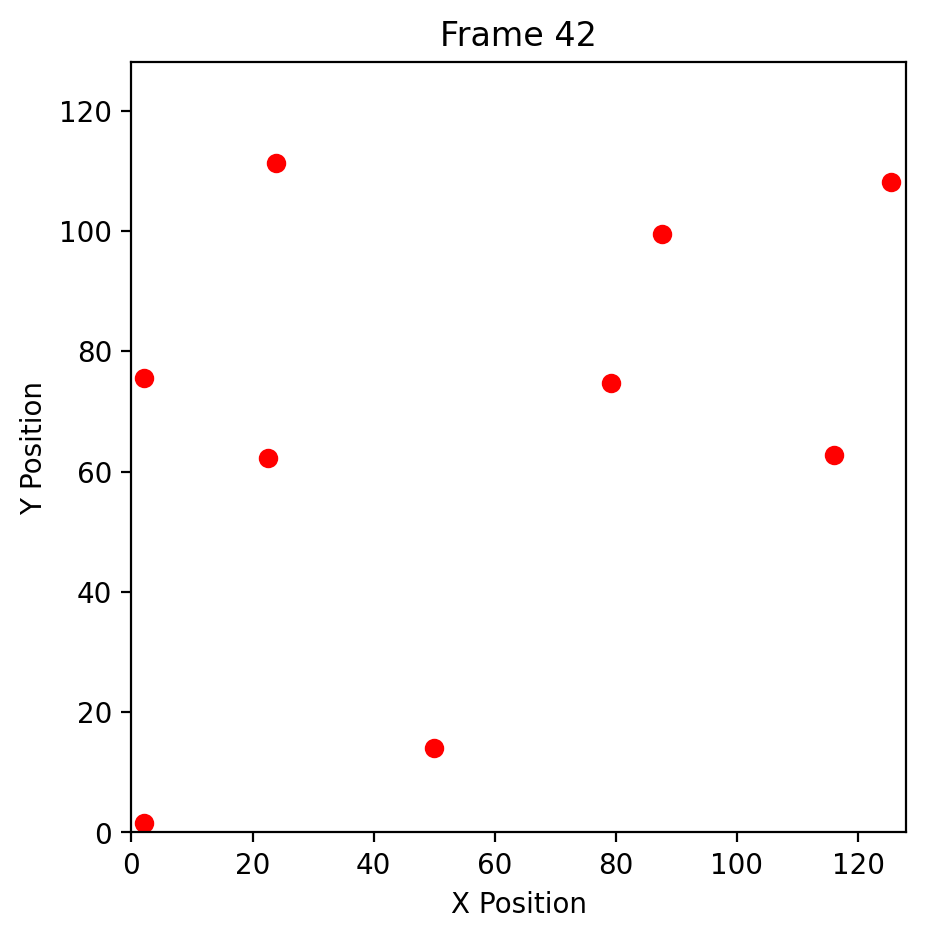

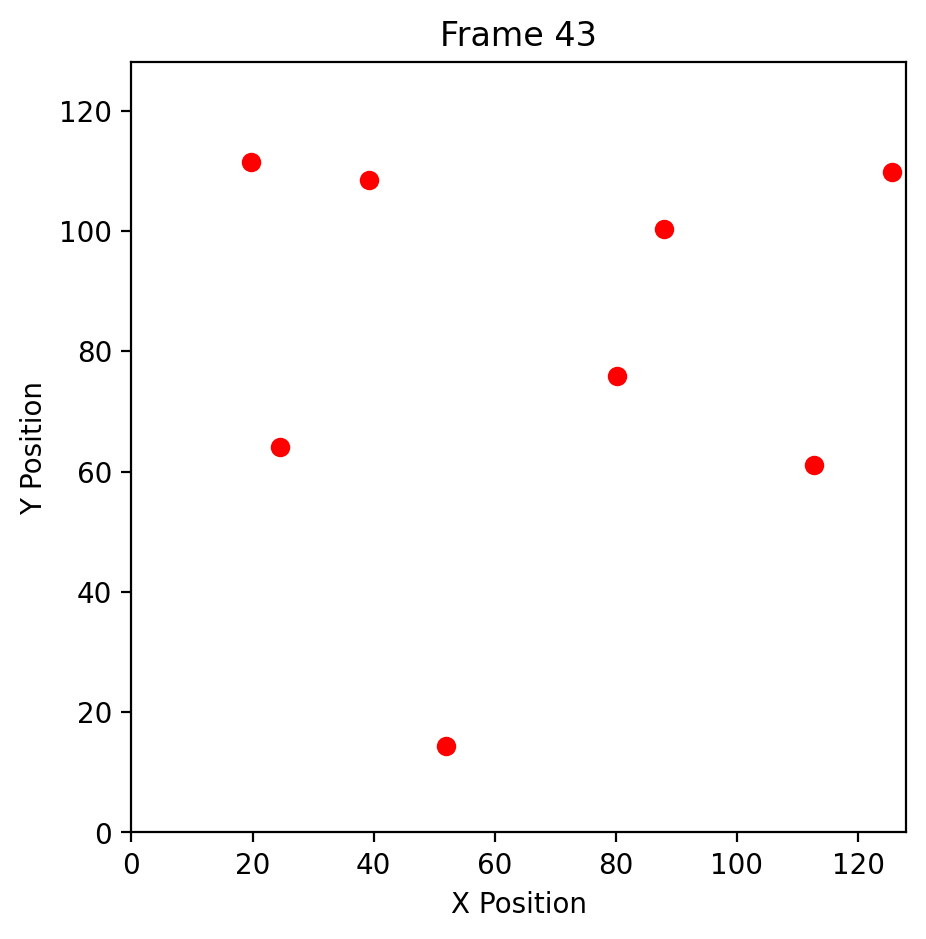

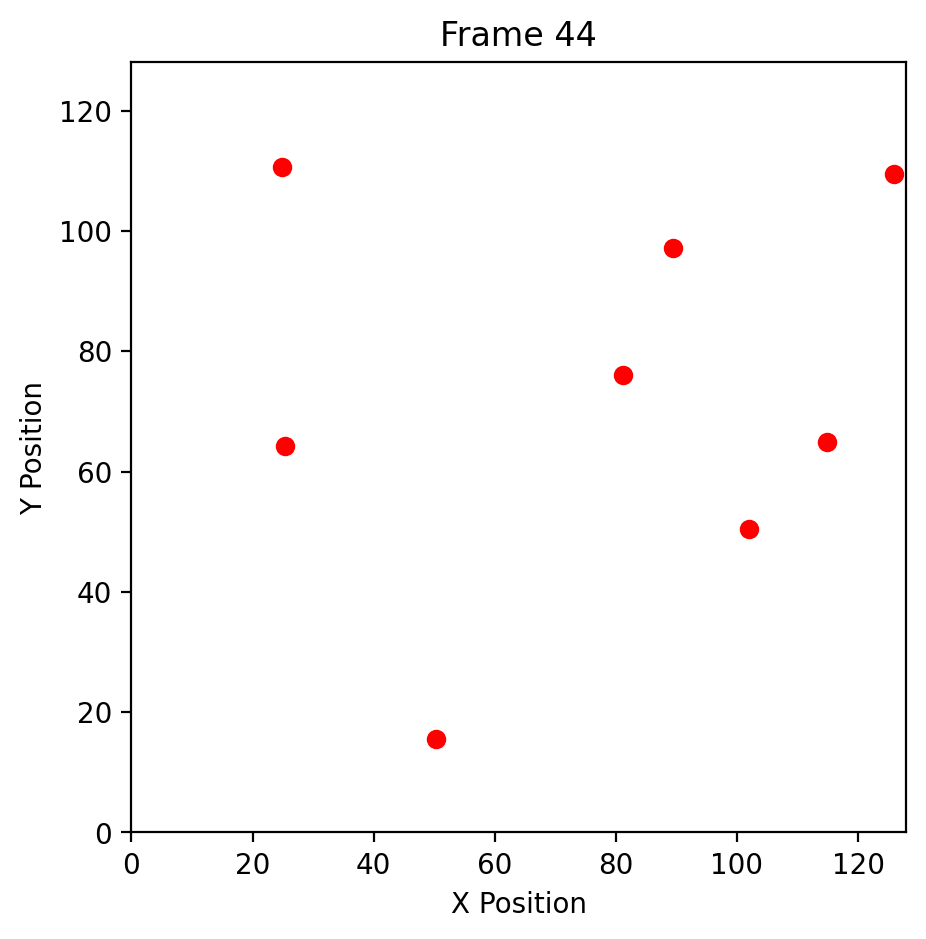

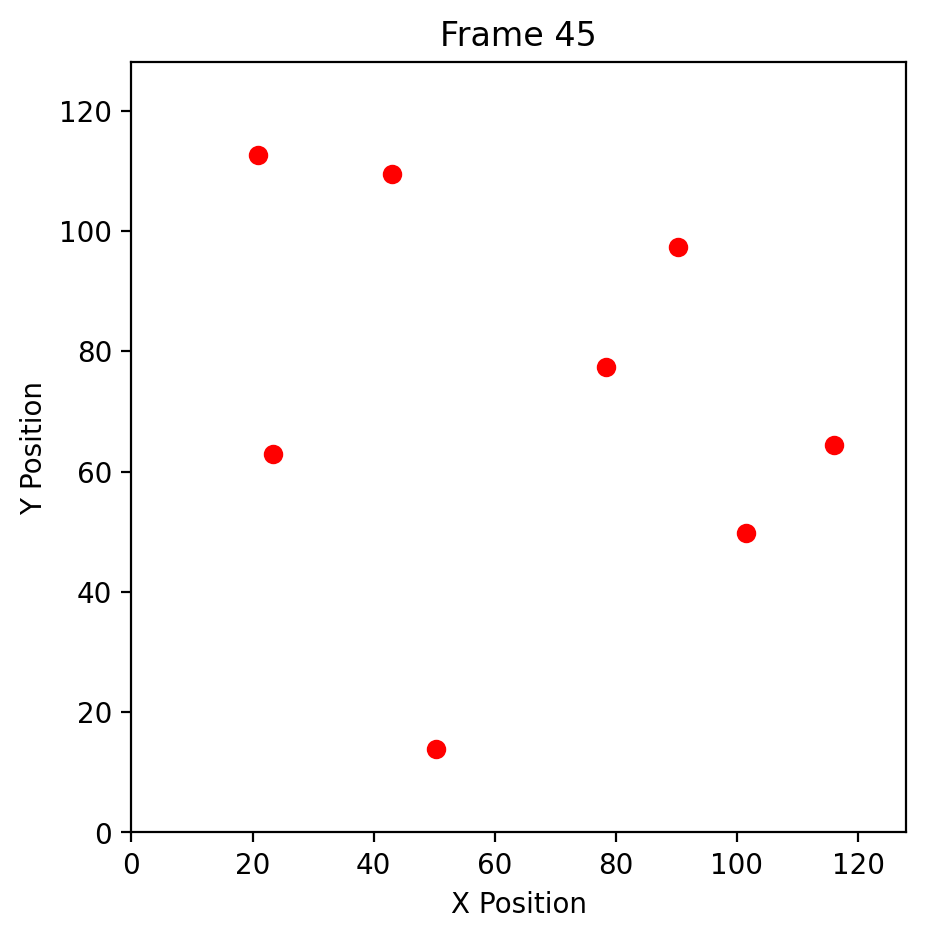

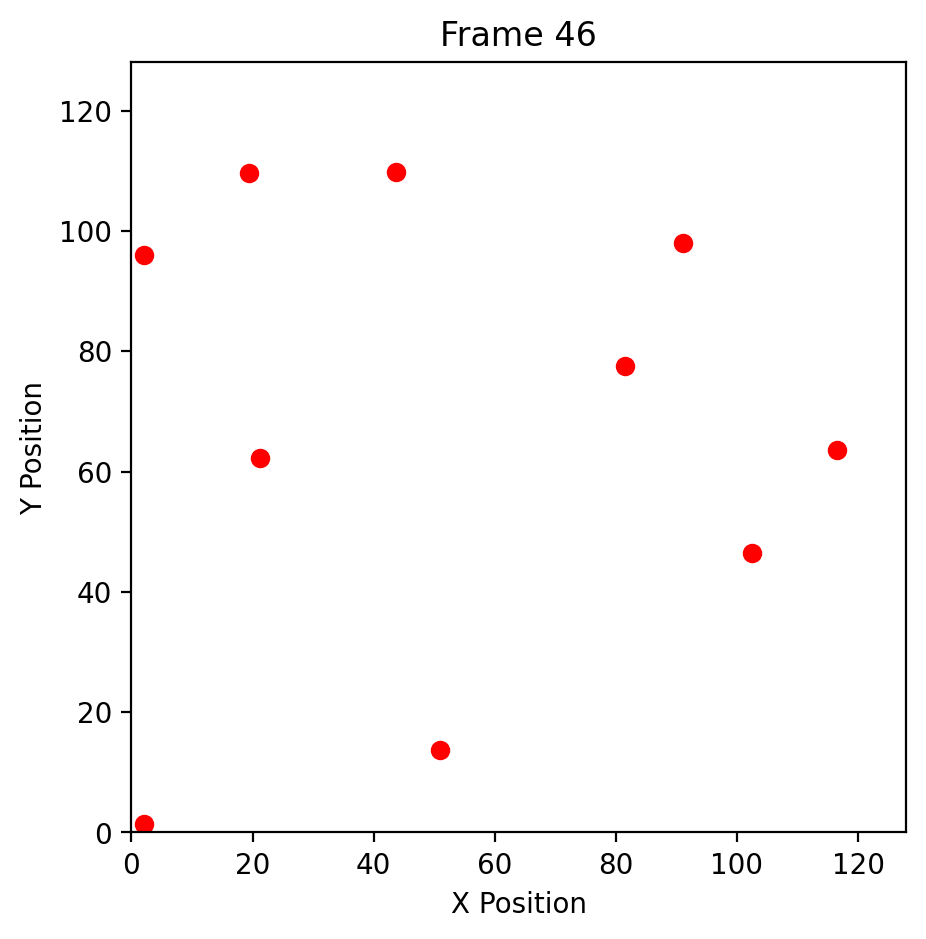

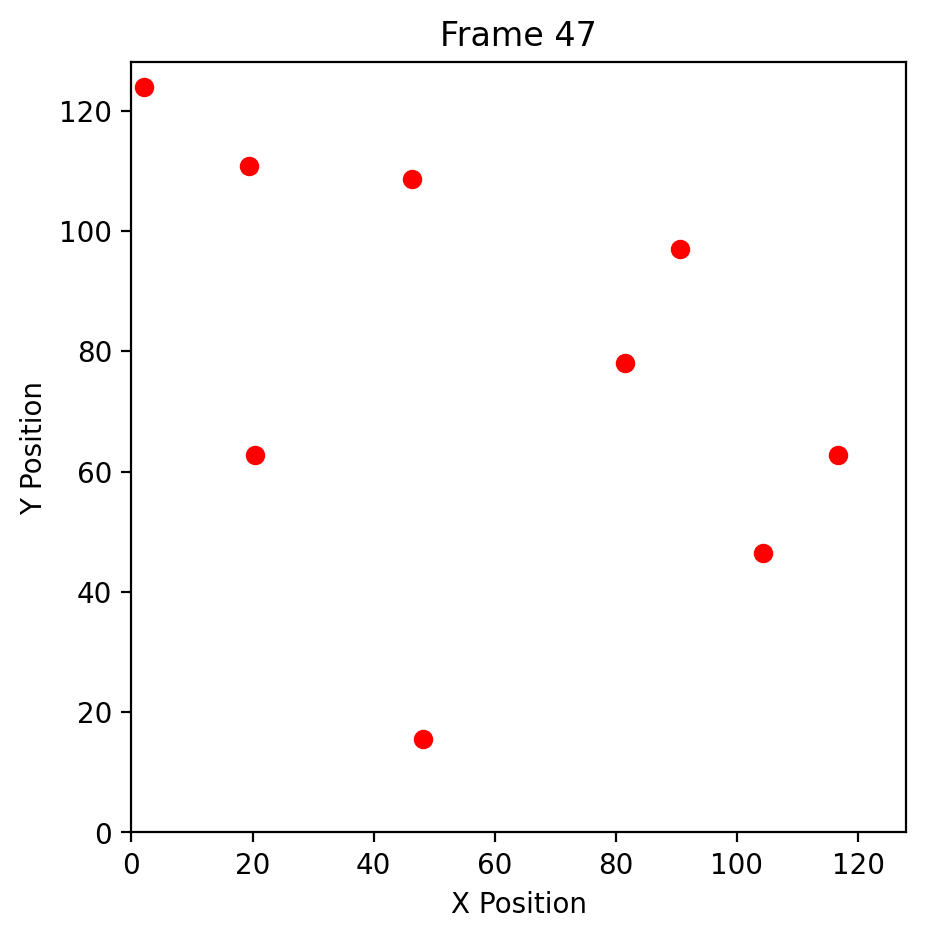

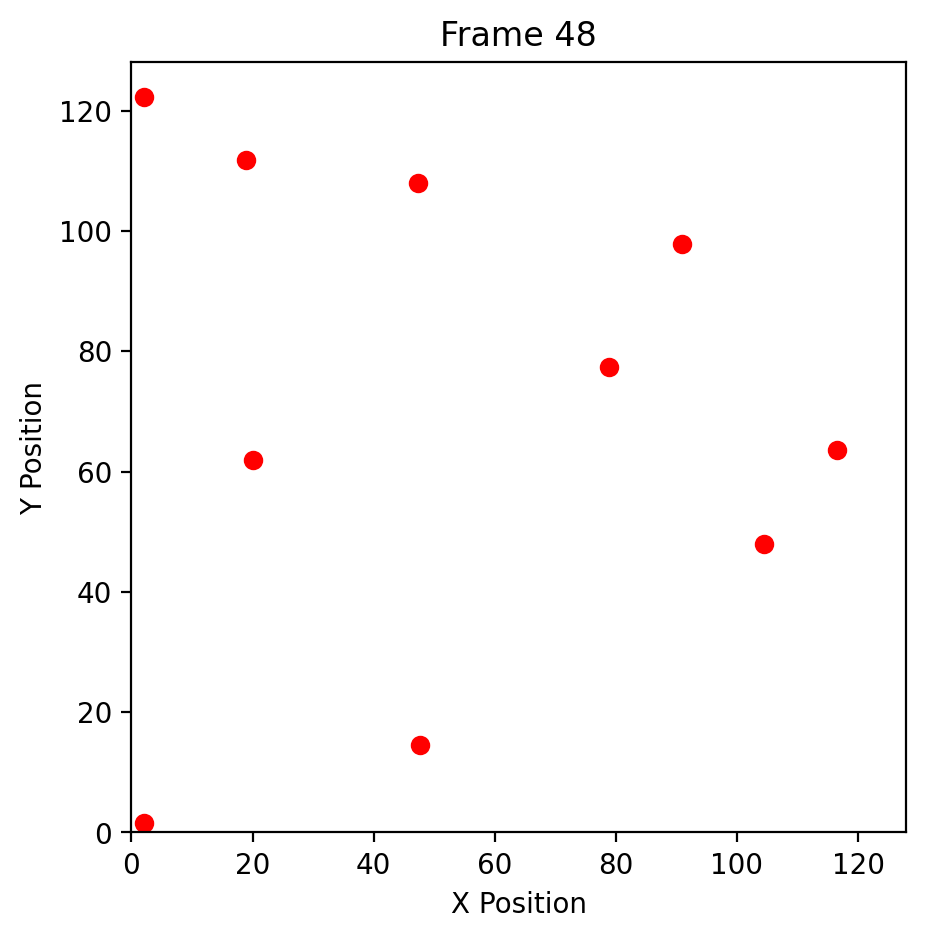

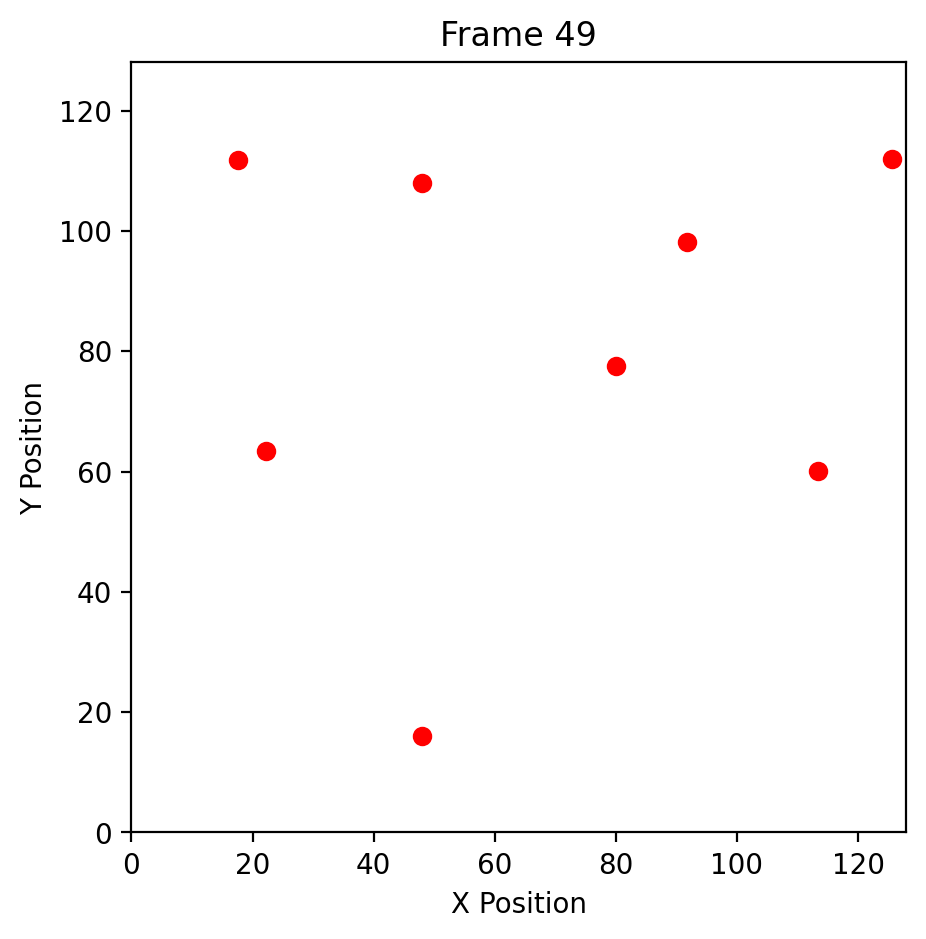

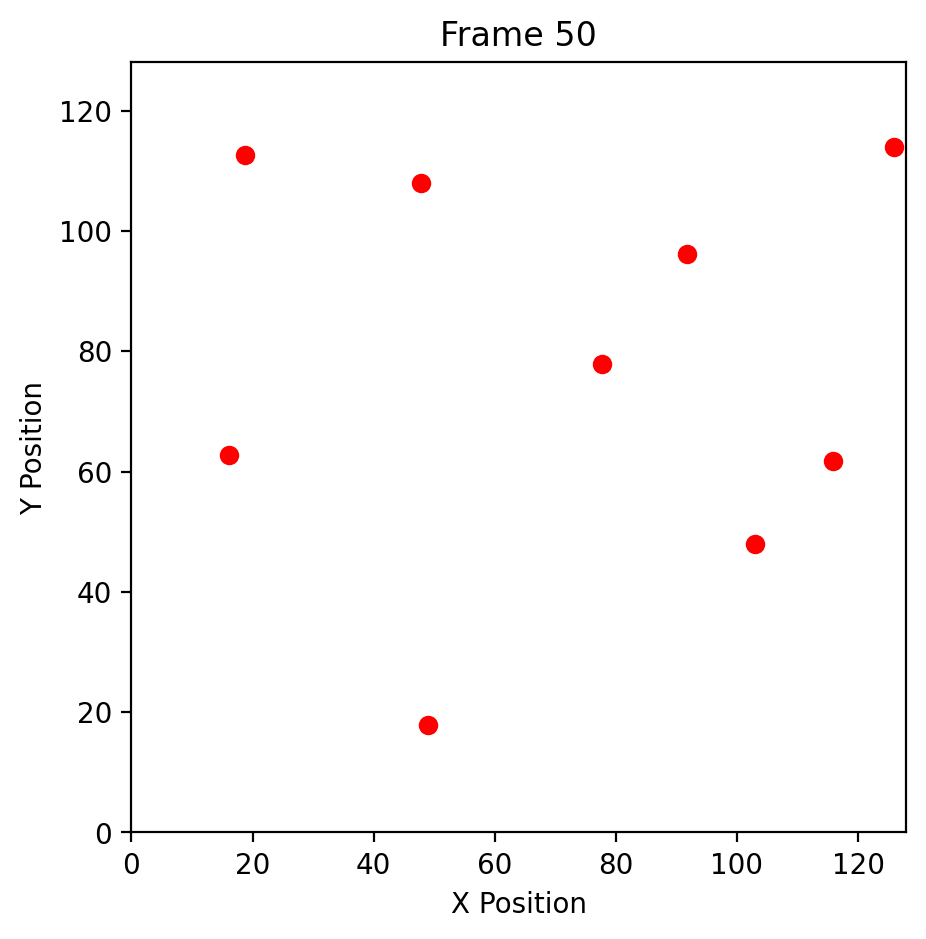

In [499]:
# Iterate through centers_per_frame and plot the center positions of particles for each frame
for i, centers in enumerate(centers_per_frame):
    # Unpack particle center positions for plotting
    if centers:  # Check if there are any centers in the current frame
        x_vals, y_vals = zip(*centers)
    else:
        x_vals, y_vals = [], []

    plt.figure(figsize=(5, 5))
    plt.scatter(y_vals, x_vals, c='r', marker='o')  # Mark particle centers with red circles
    plt.title(f"Frame {i+1}")
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.xlim(0, 128)
    plt.ylim(0, 128)
    plt.show()

# K-means

In [500]:
from sklearn.cluster import KMeans
centers_per_frame = []  # Store the center positions of particles for each frame

k = 10  

for frame_positions in particle_positions_per_frame:
    # Ensure frame_positions is a NumPy array
    frame_positions_np = np.array(frame_positions)
    
    # Apply KMeans algorithm
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(frame_positions_np)
    
    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    centers_per_frame.append(centers)

/var/folders/_h/v3zx4l357d3fgz8svznhxcjc0000gn/T/ipykernel_2624/2454678541.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5, 5))


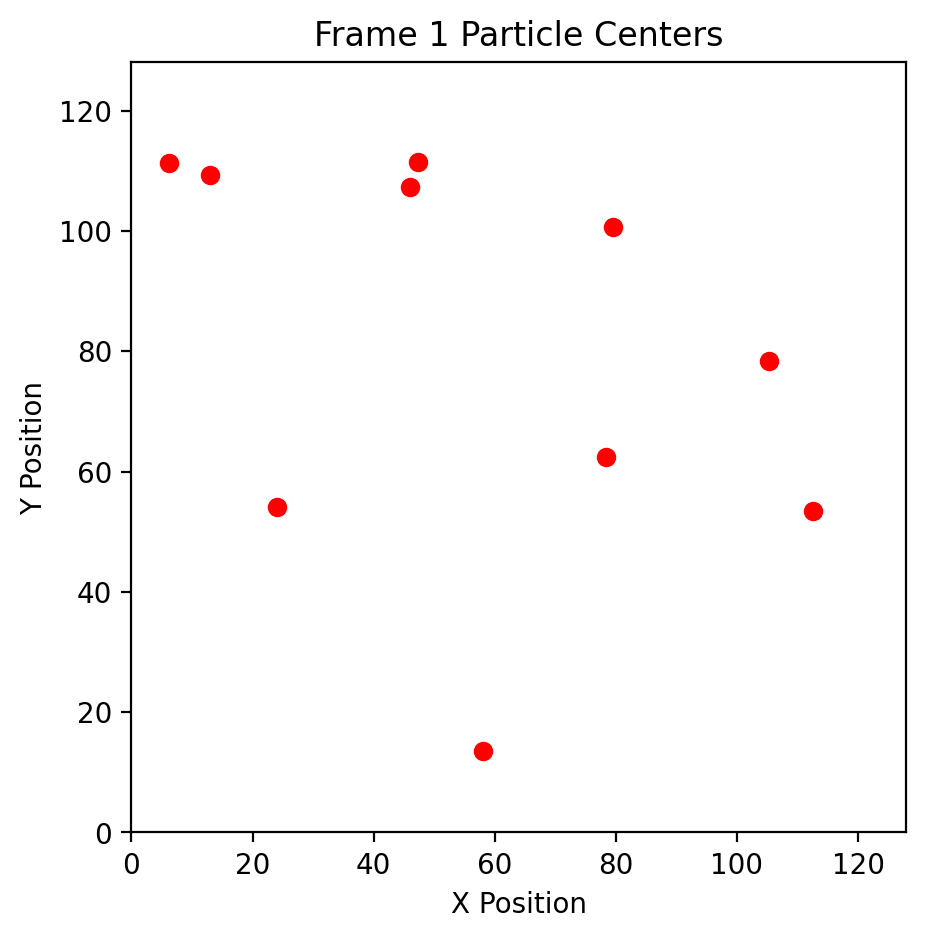

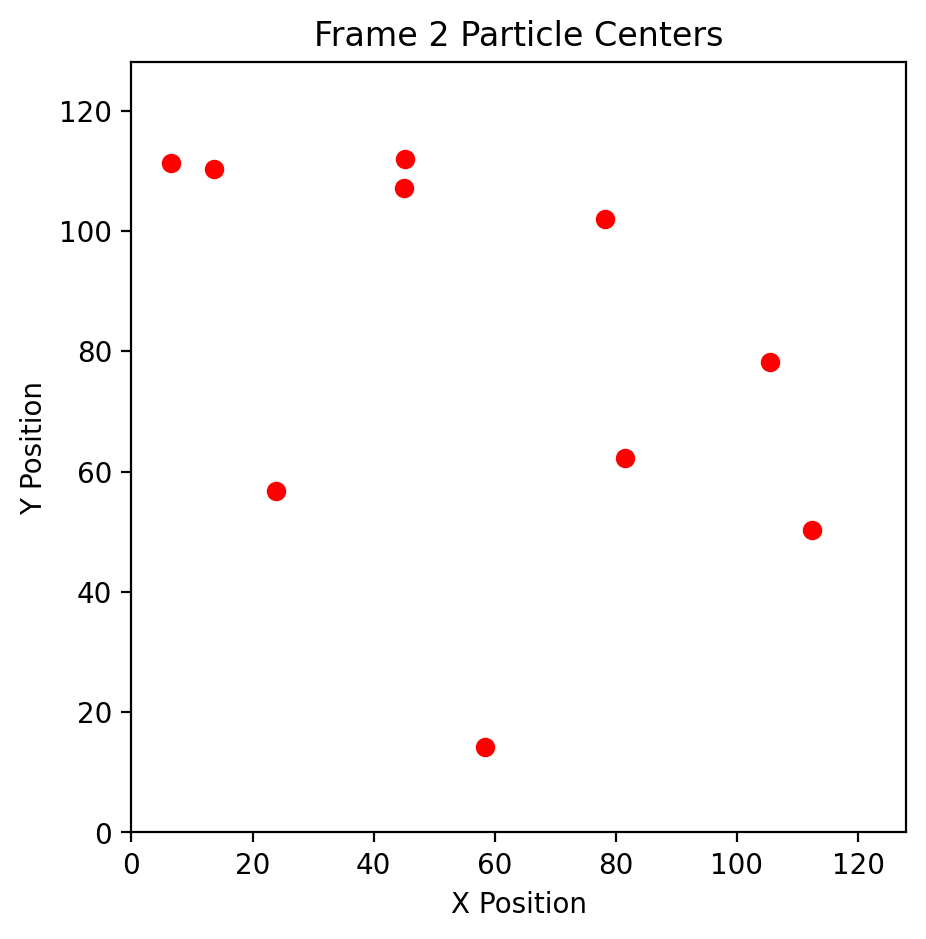

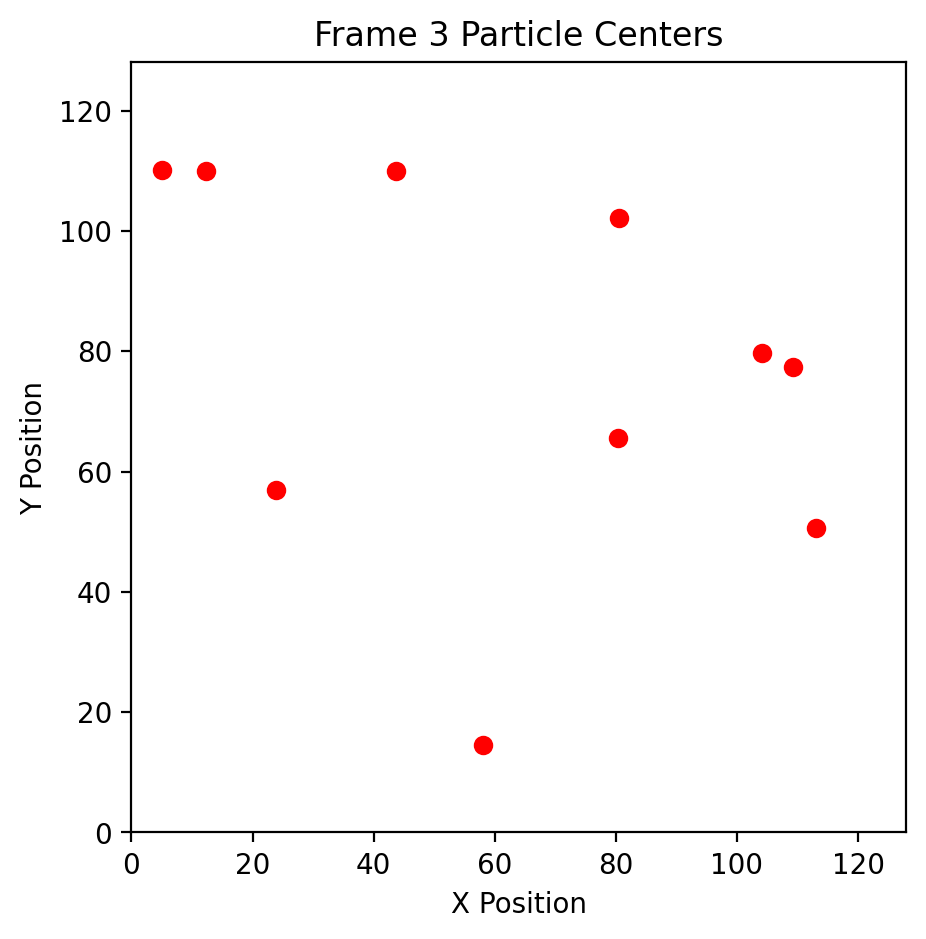

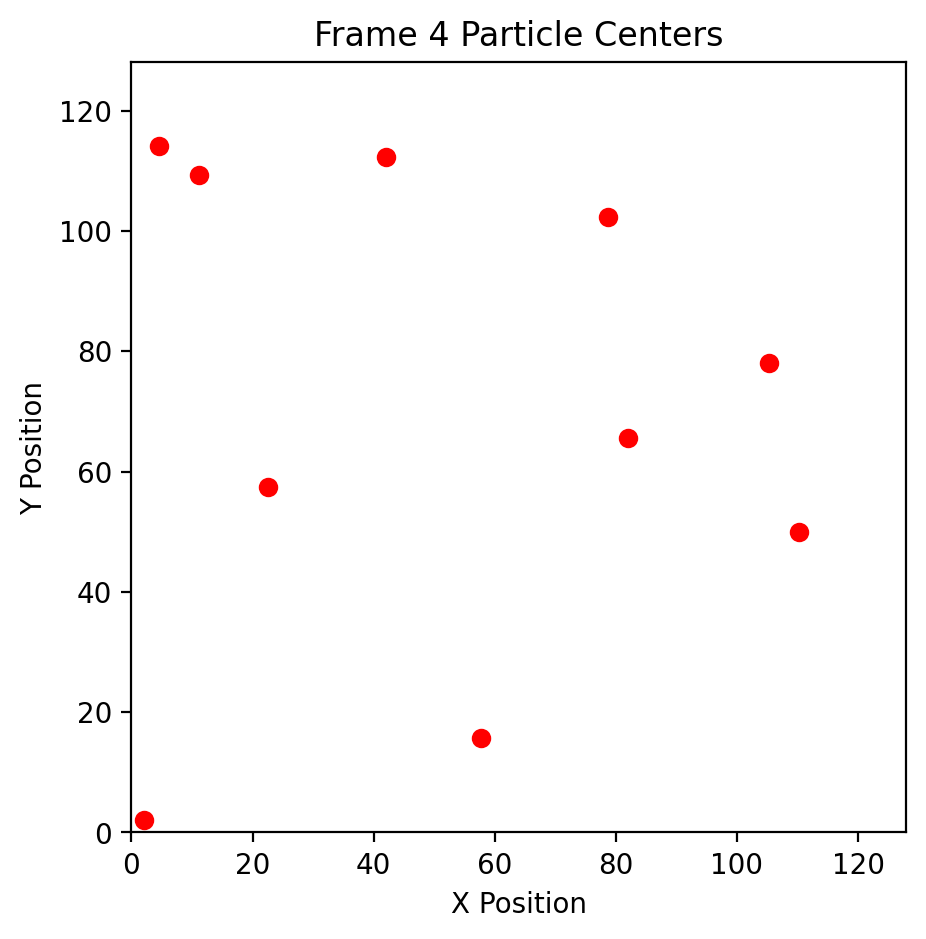

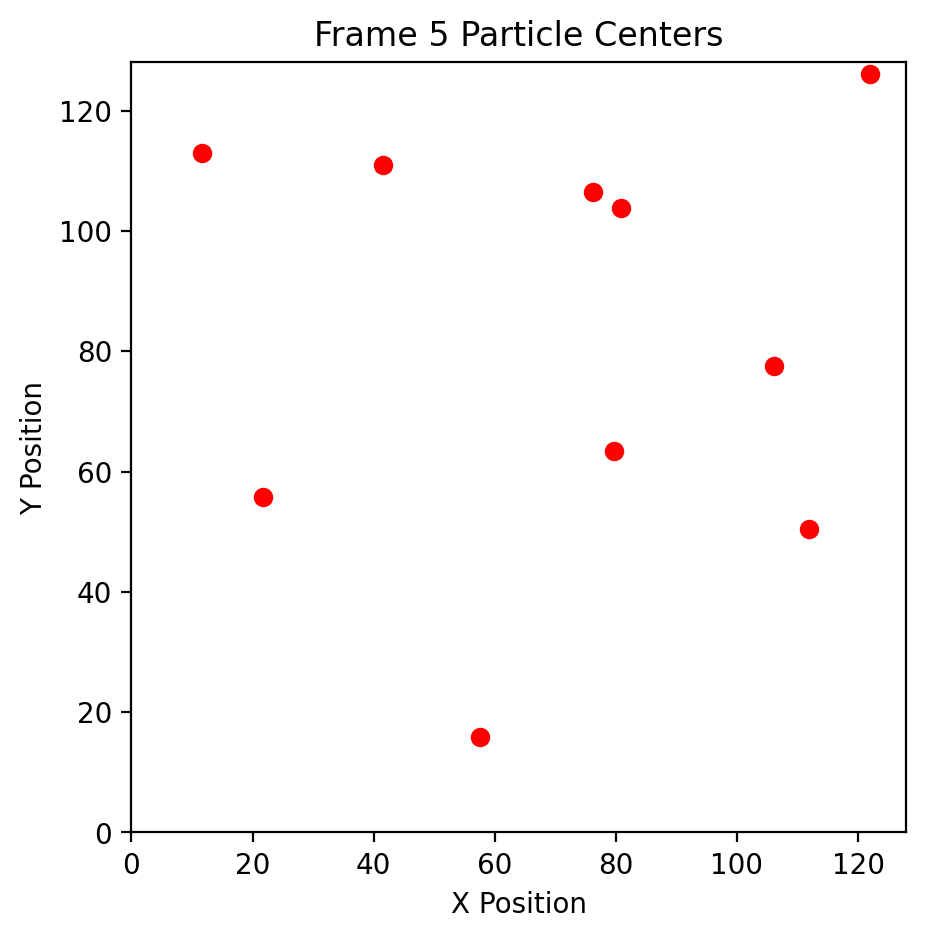

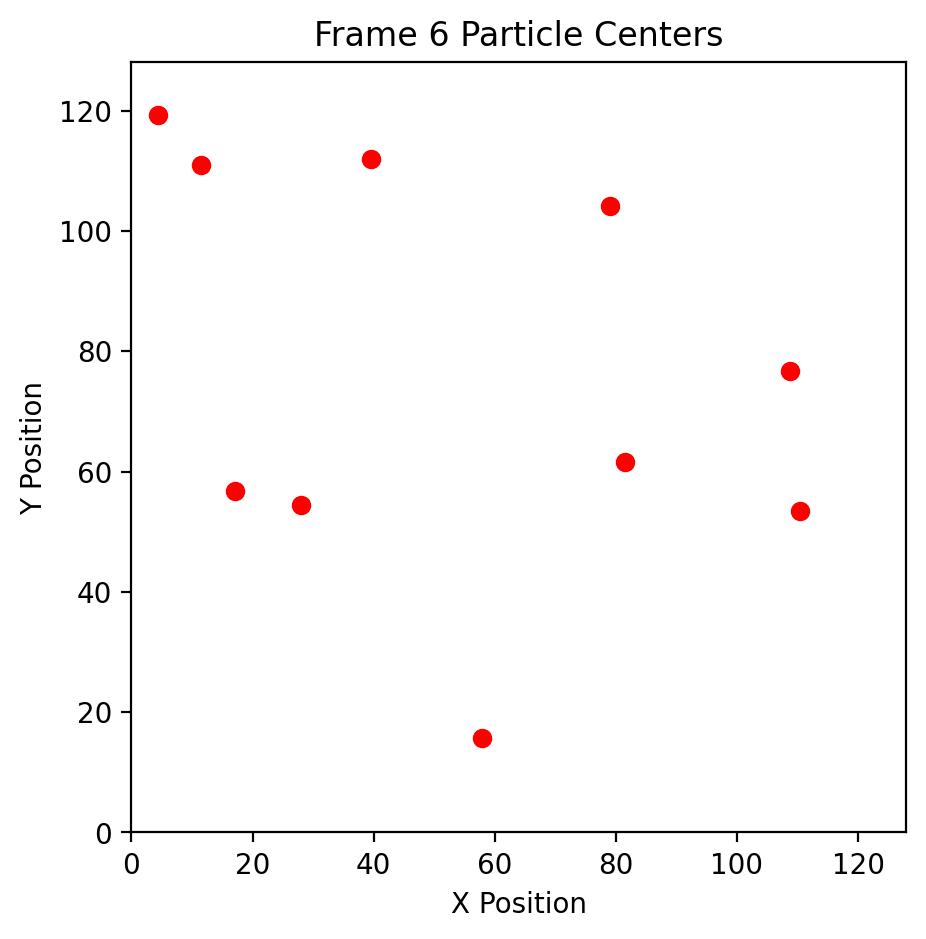

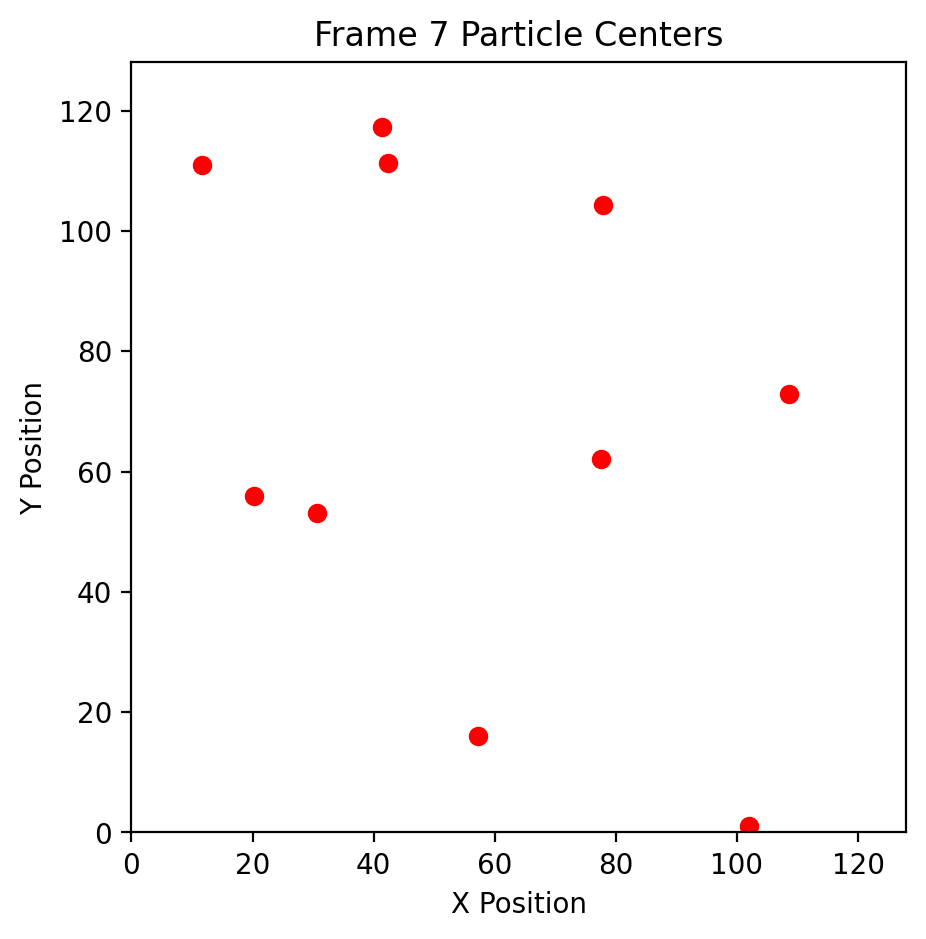

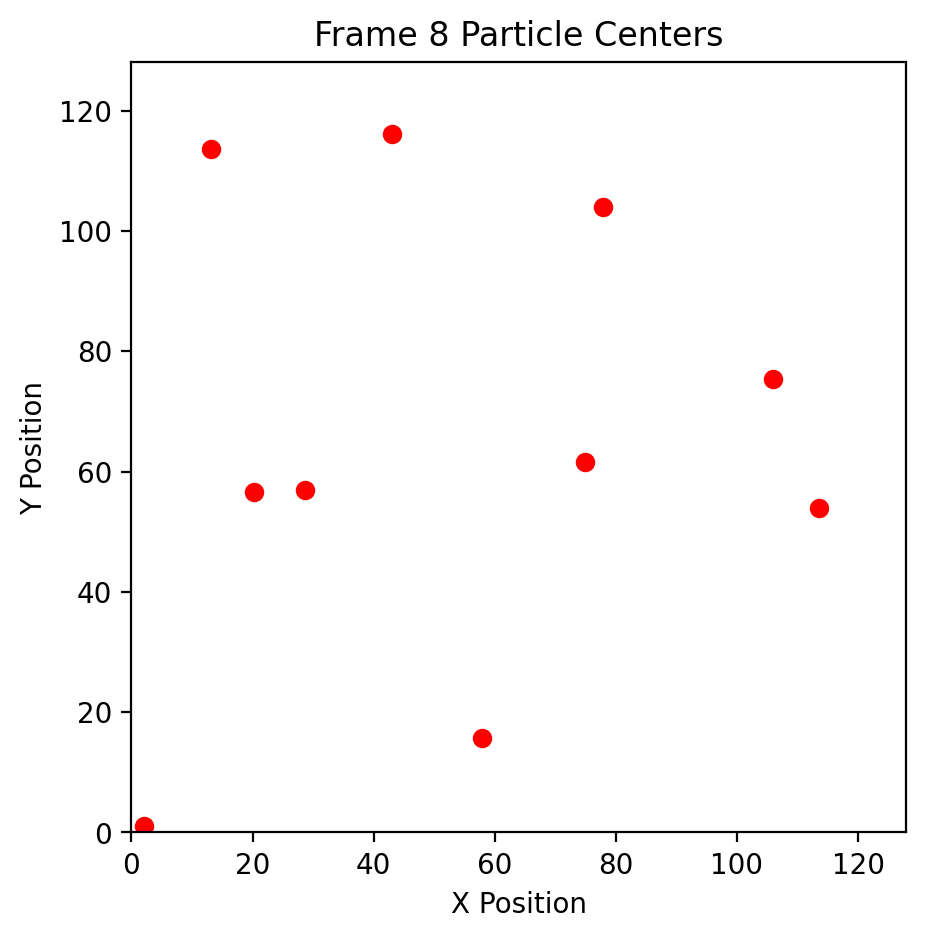

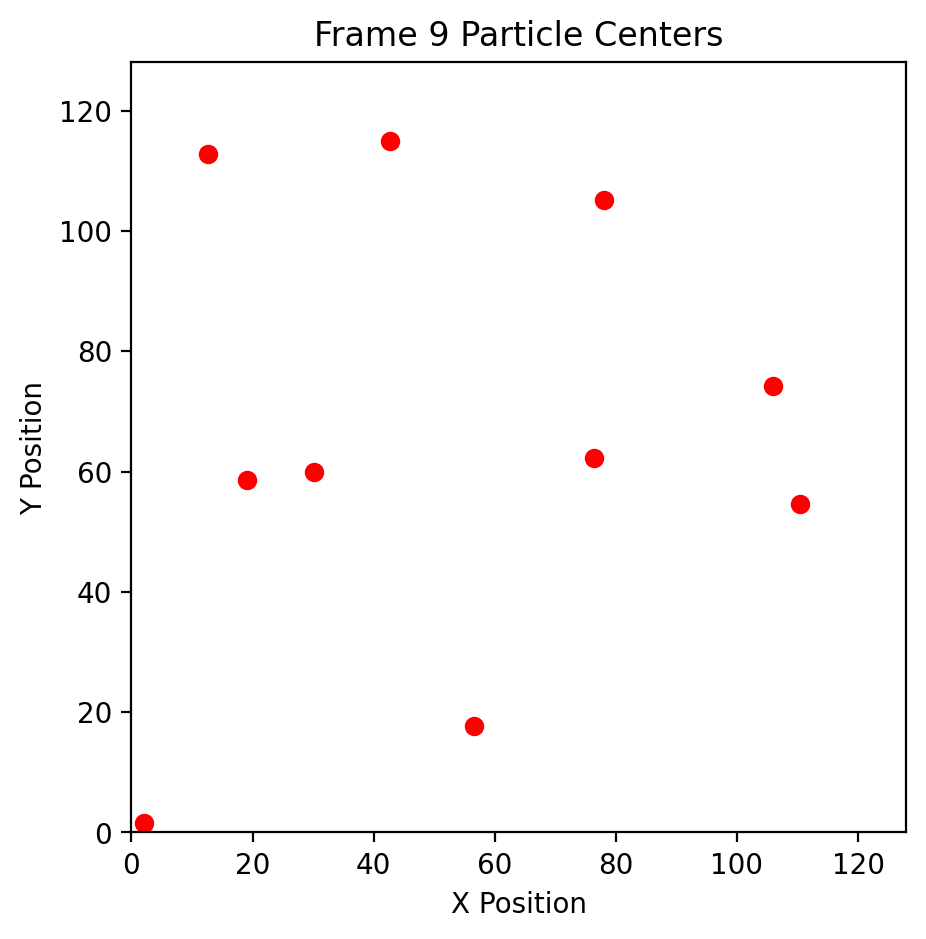

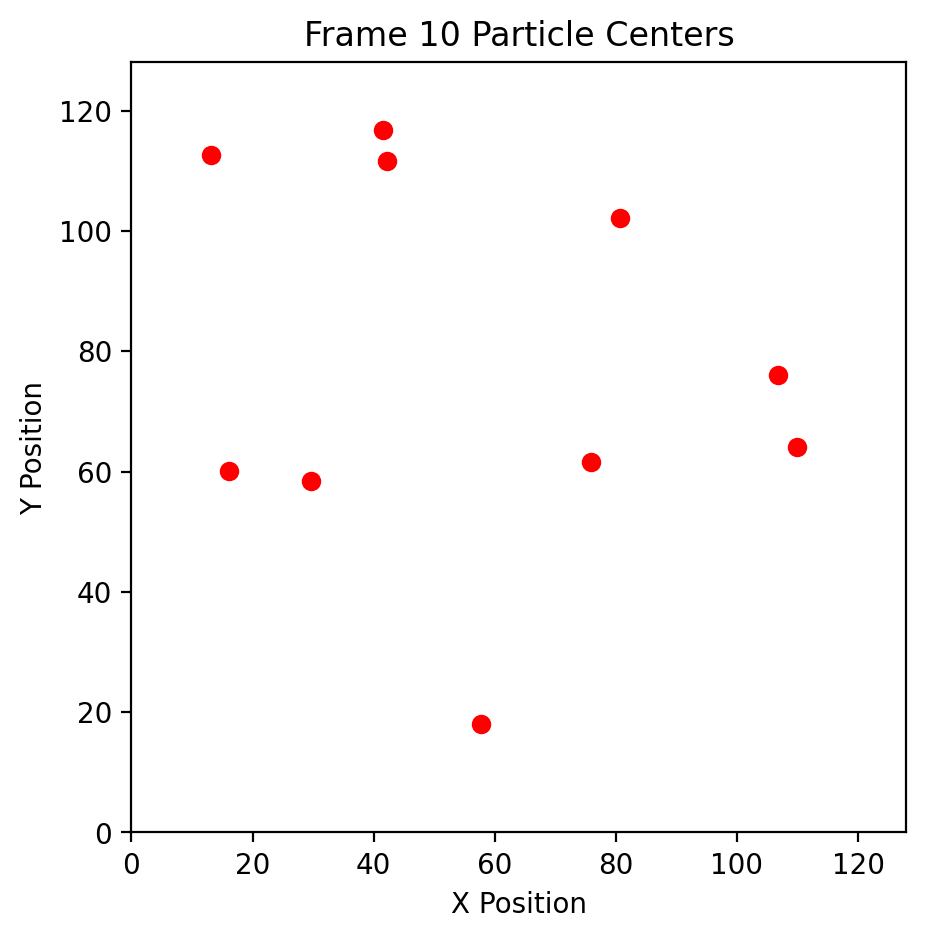

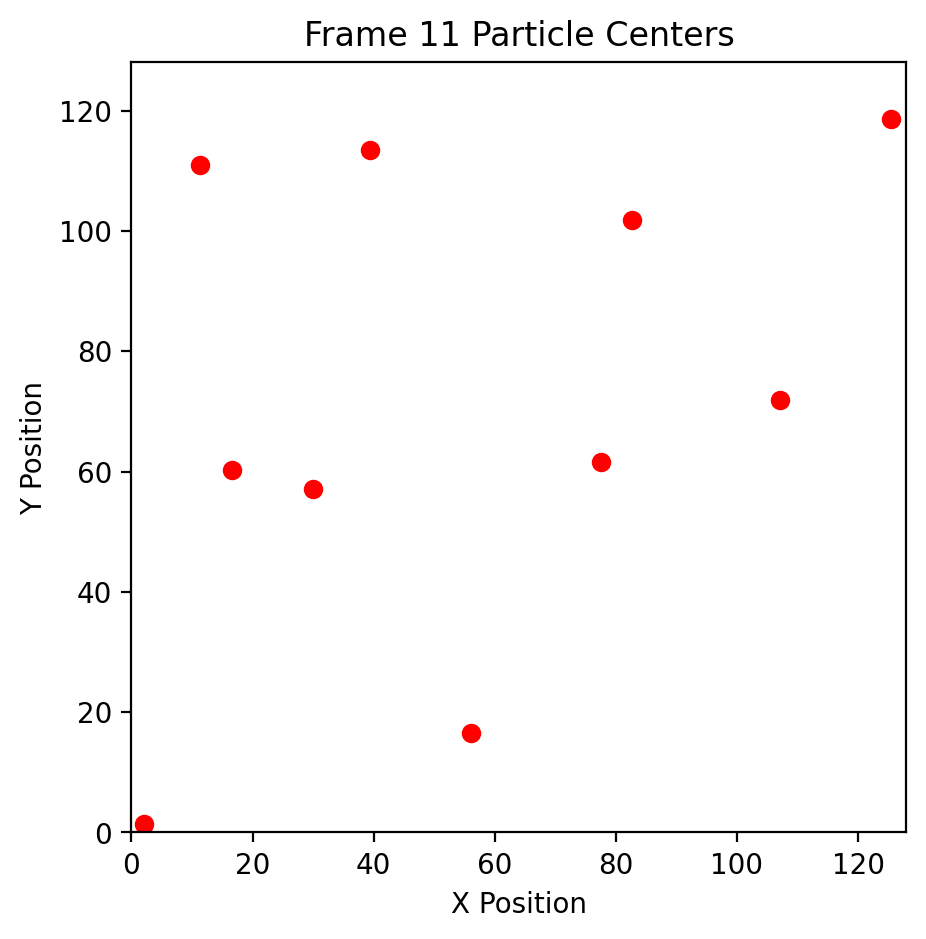

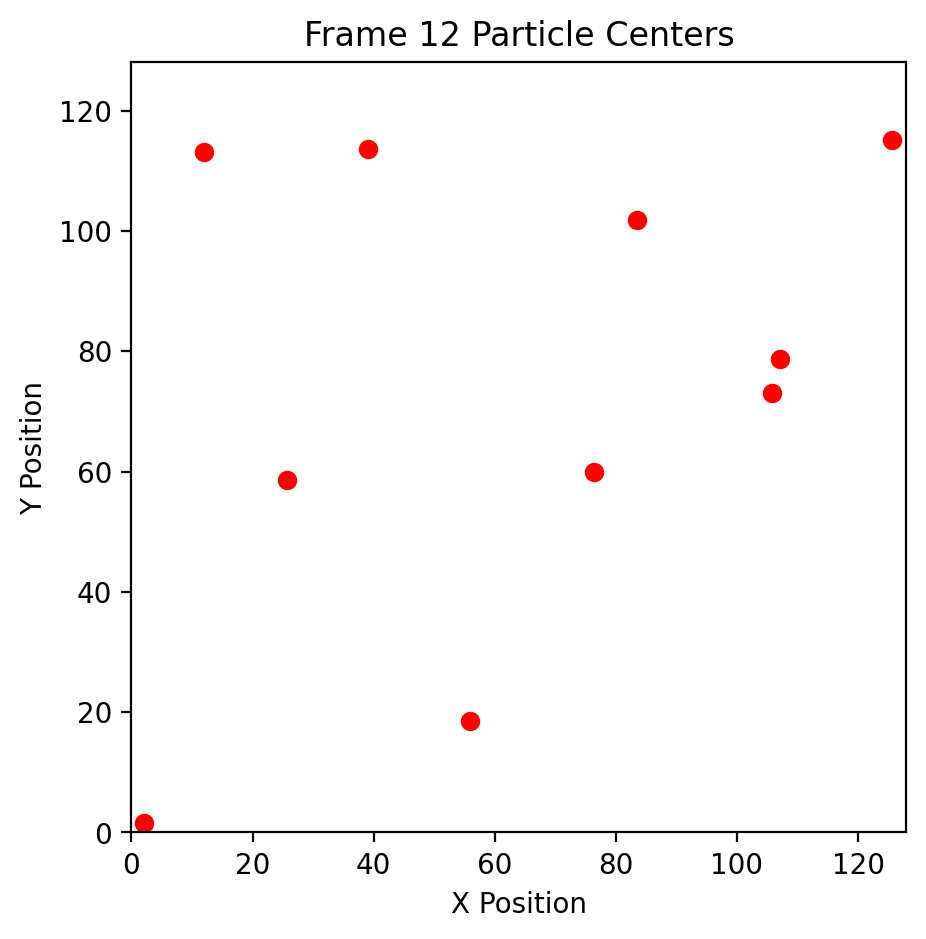

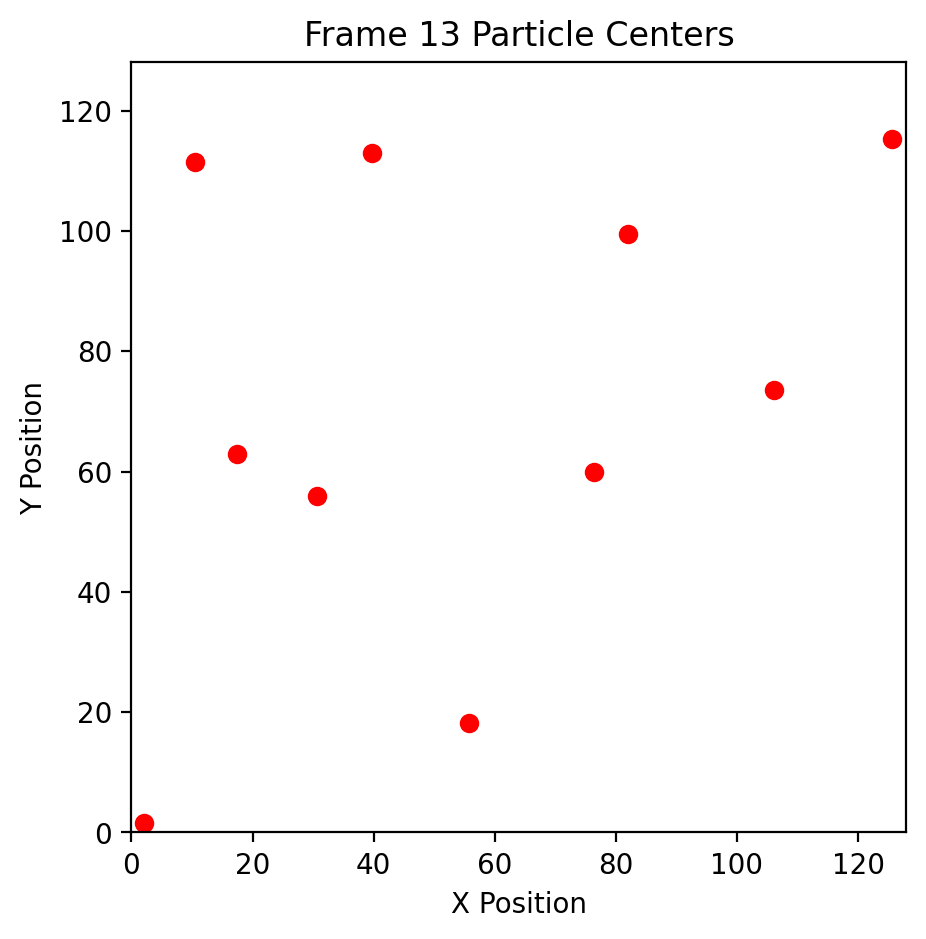

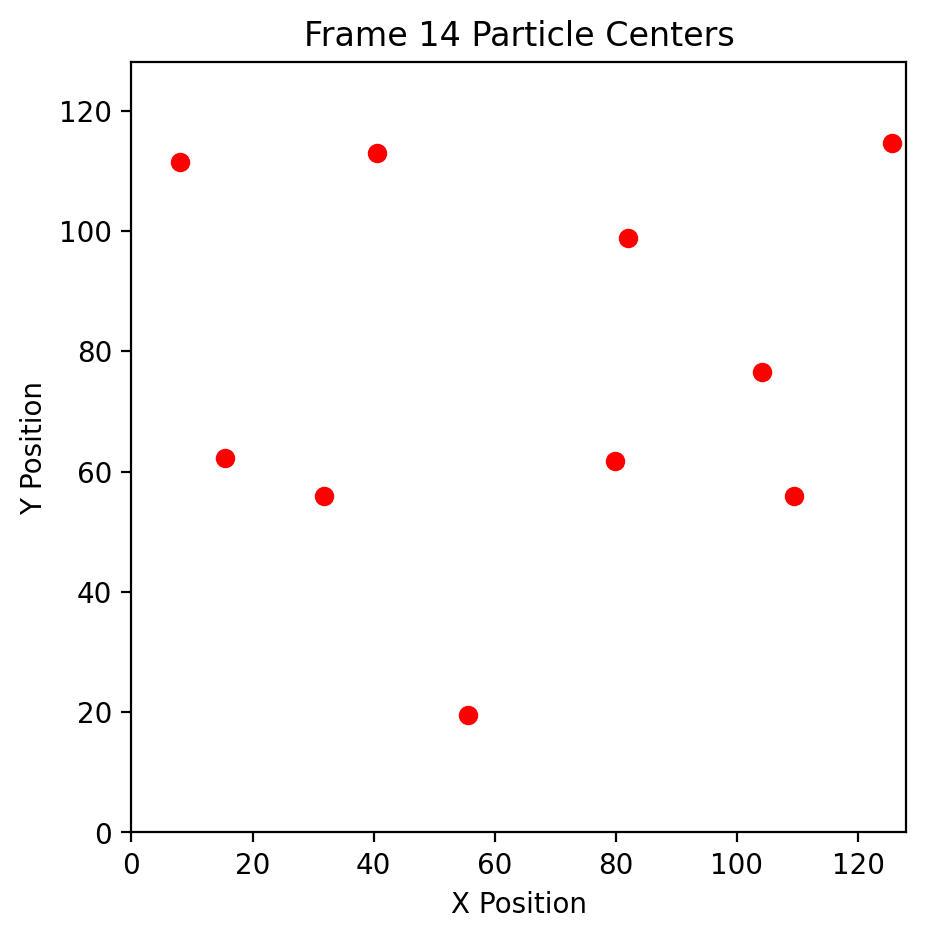

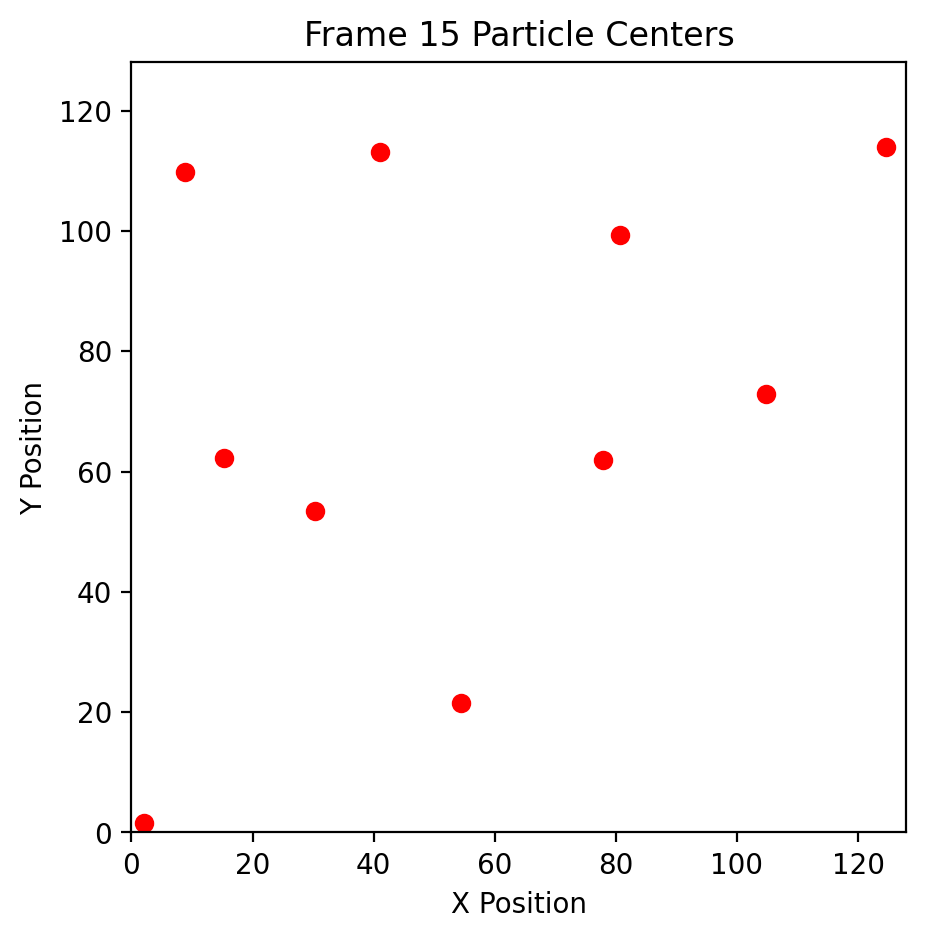

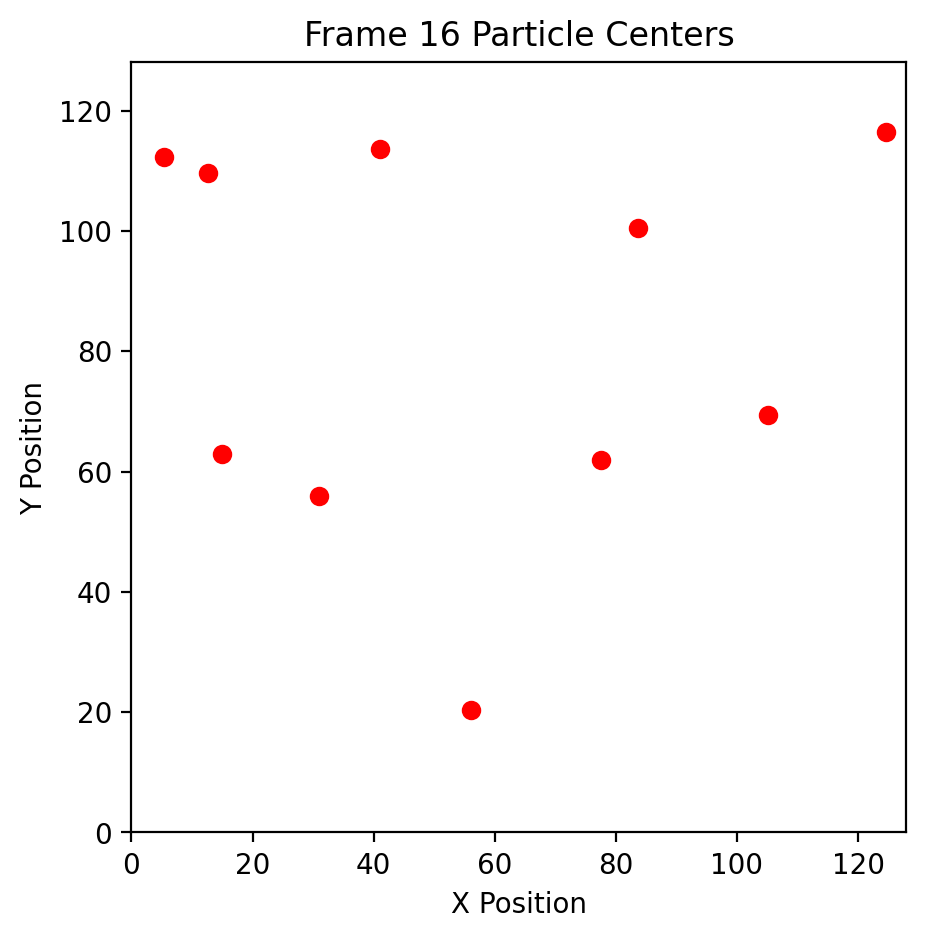

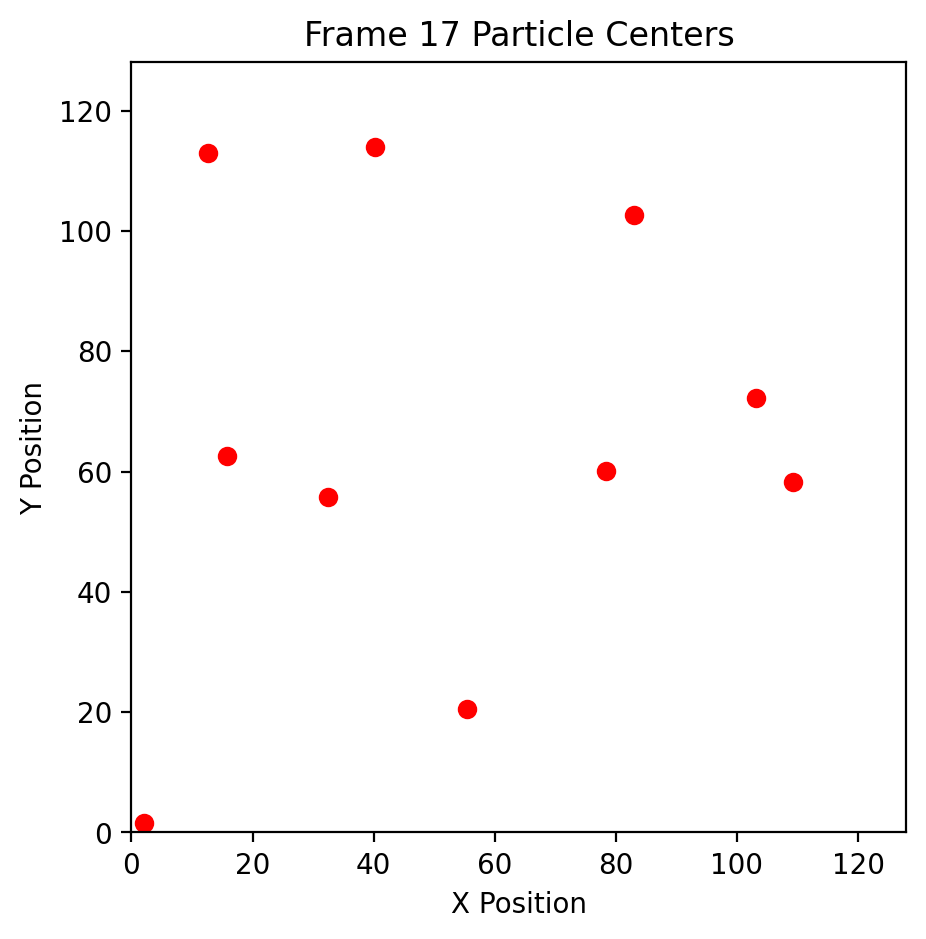

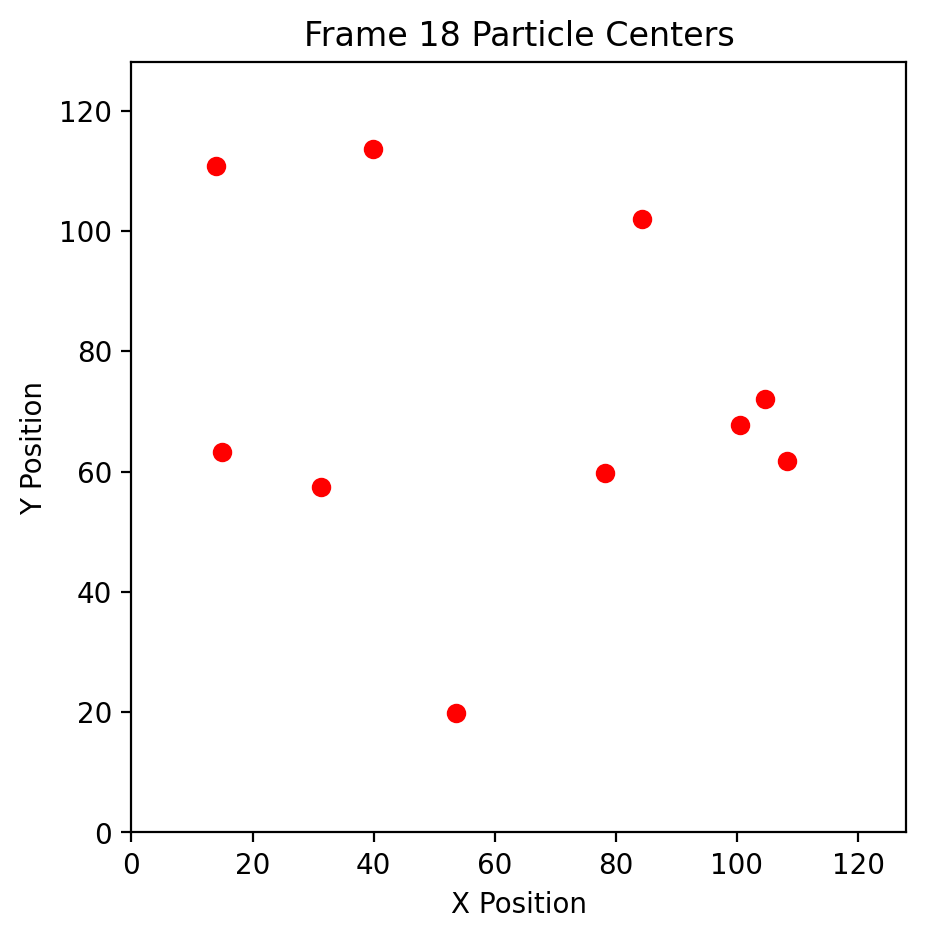

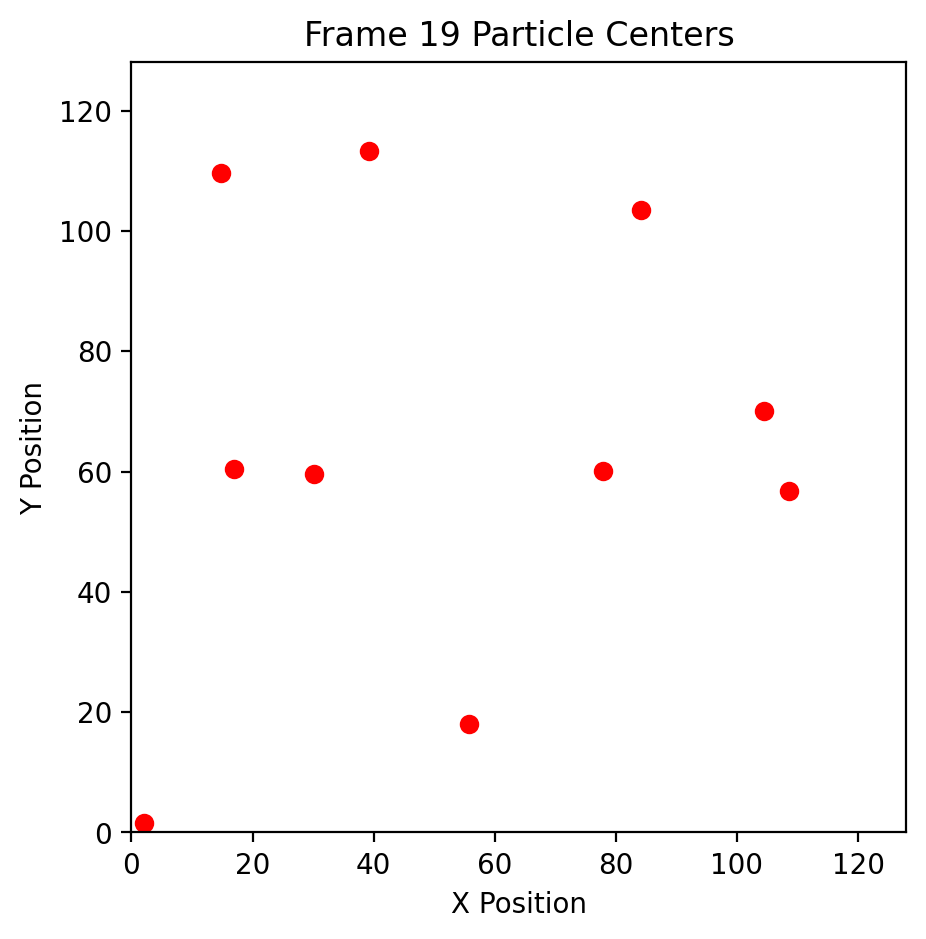

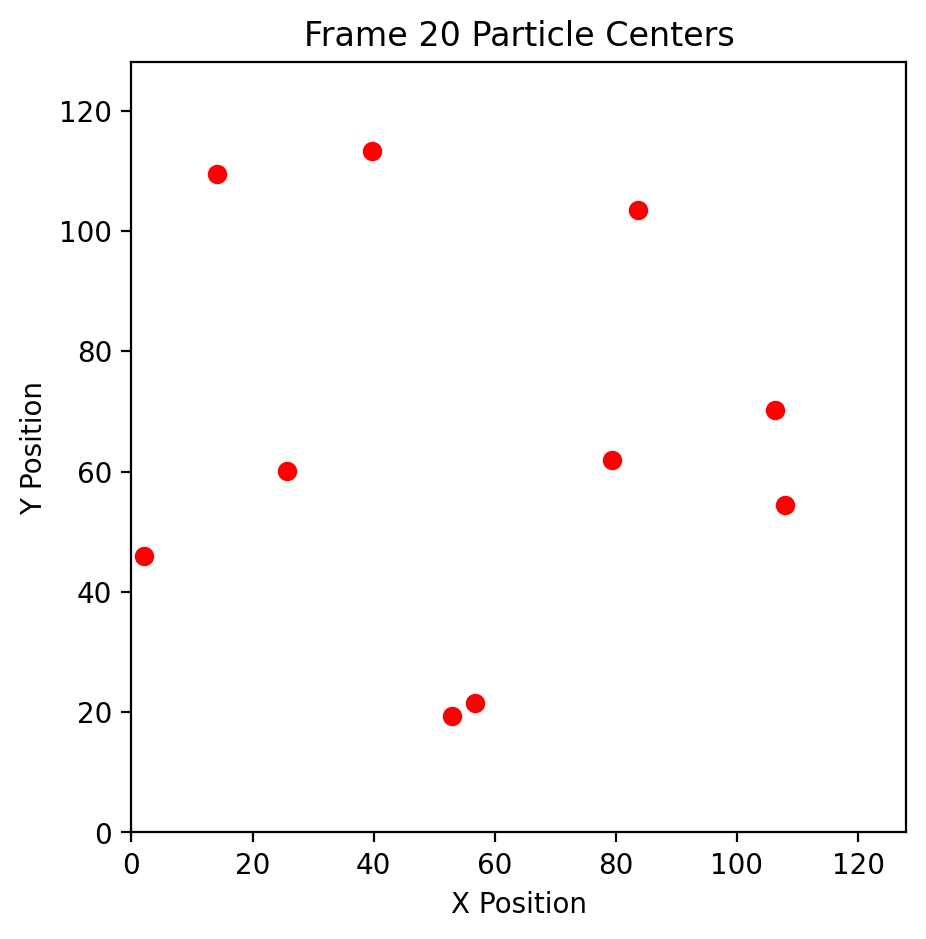

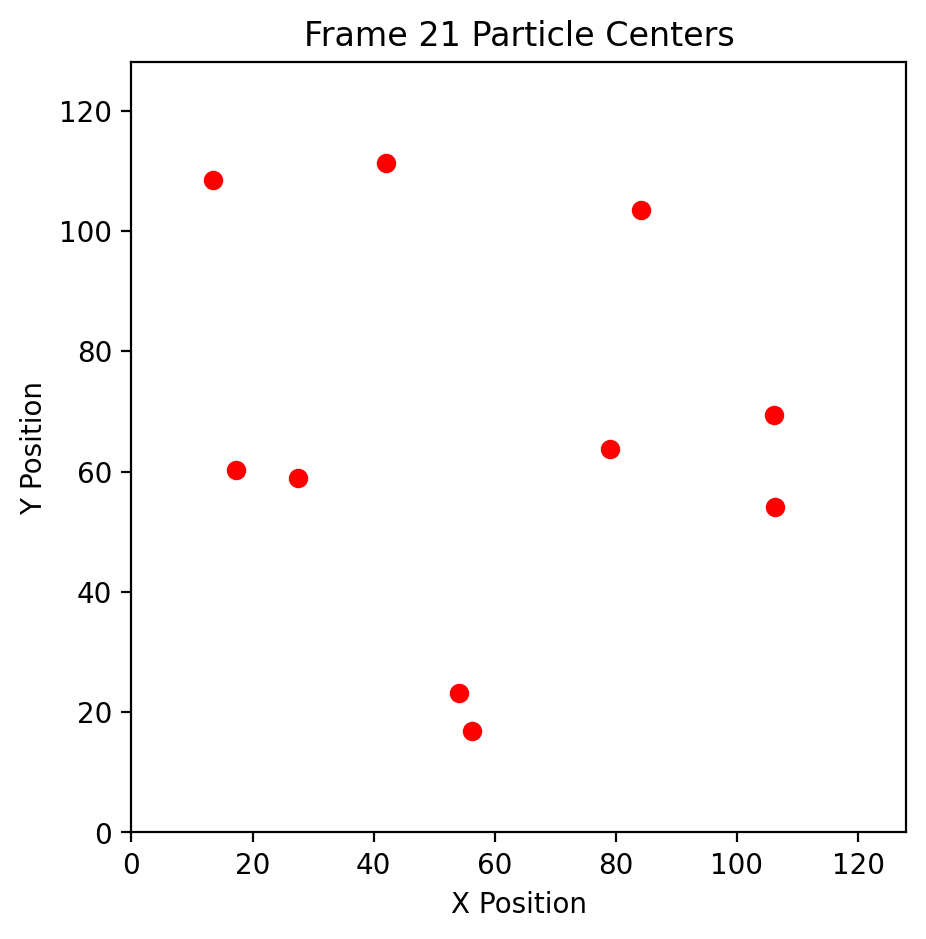

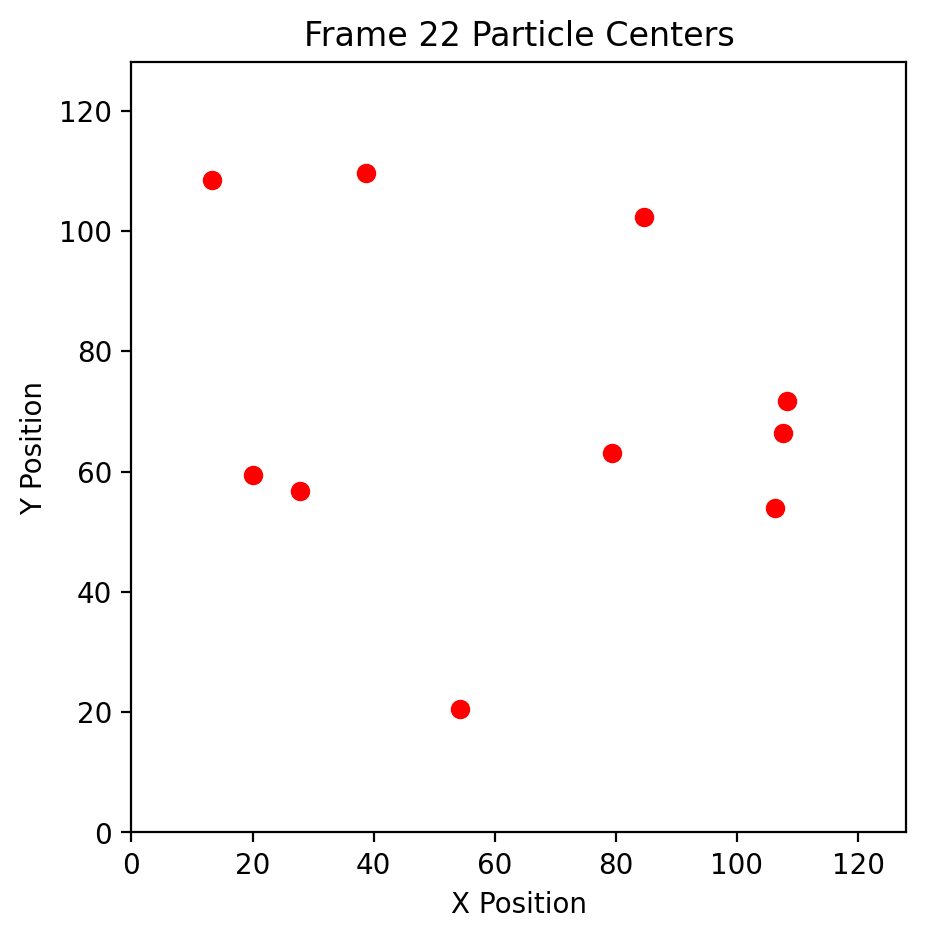

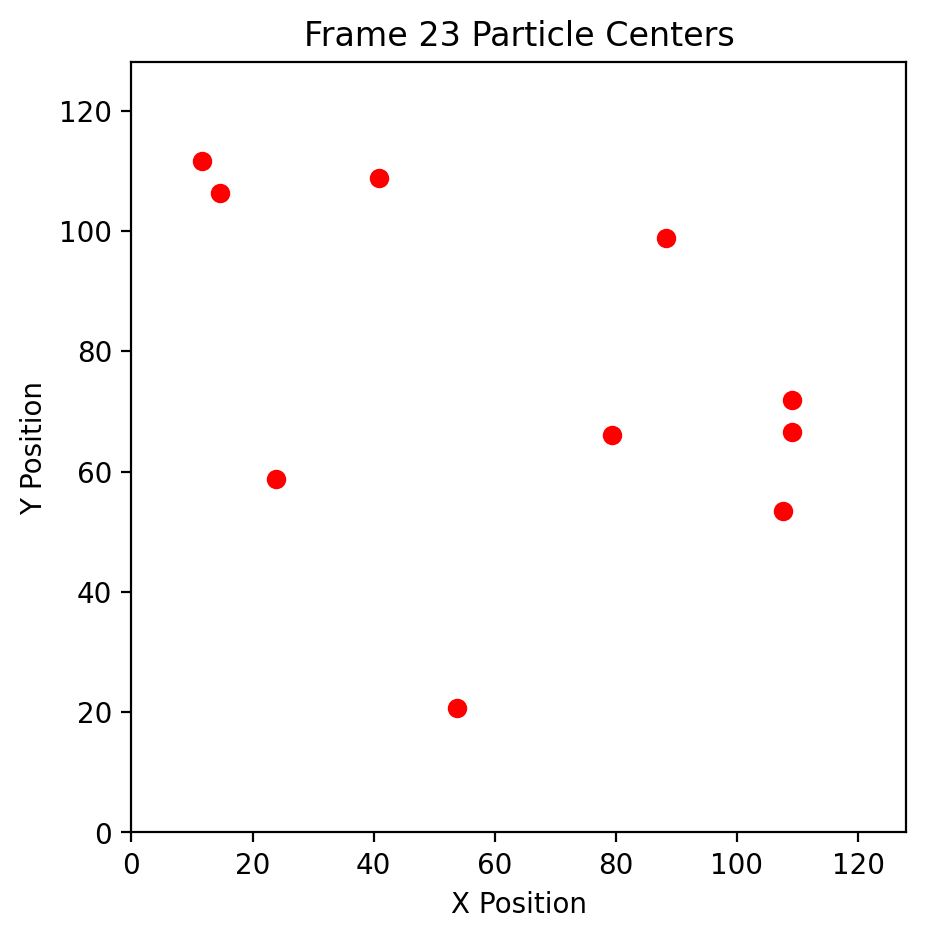

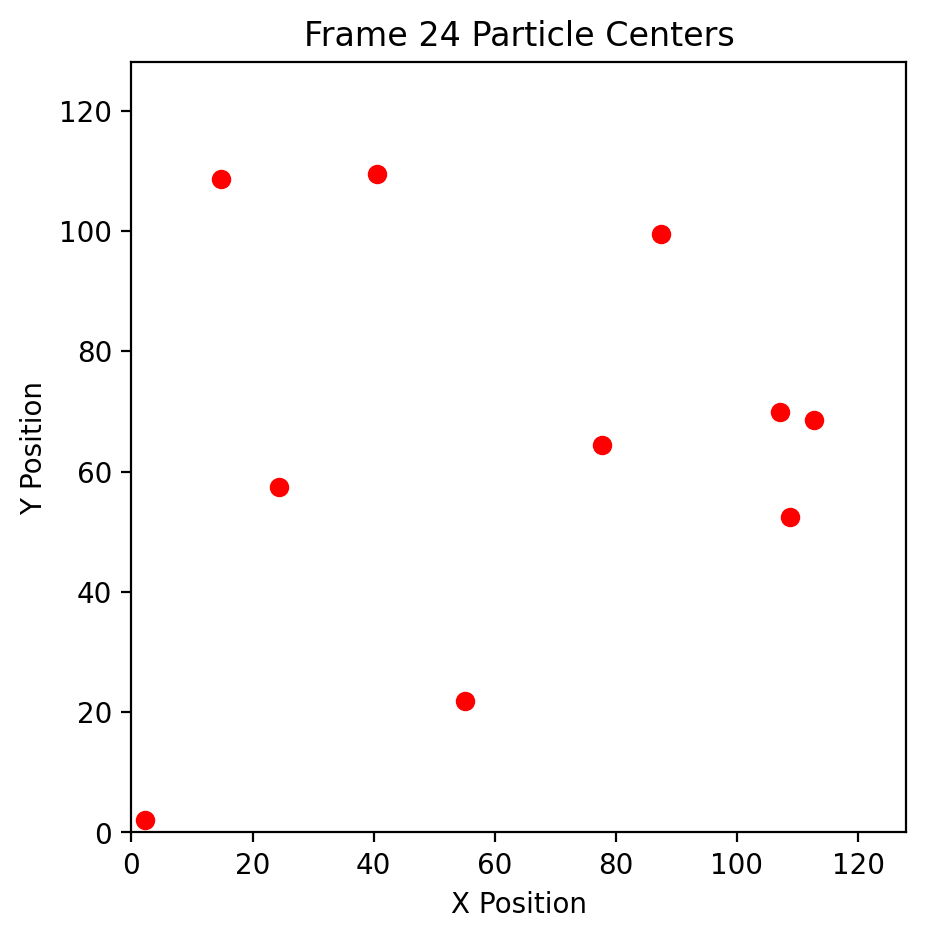

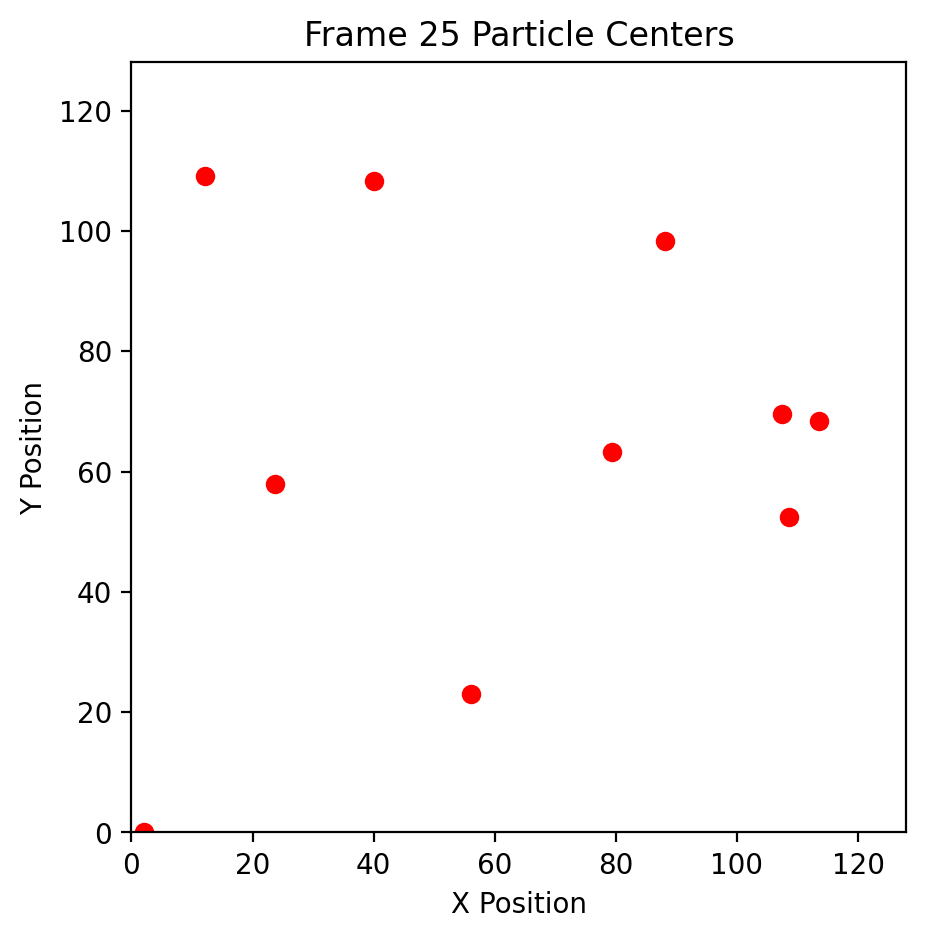

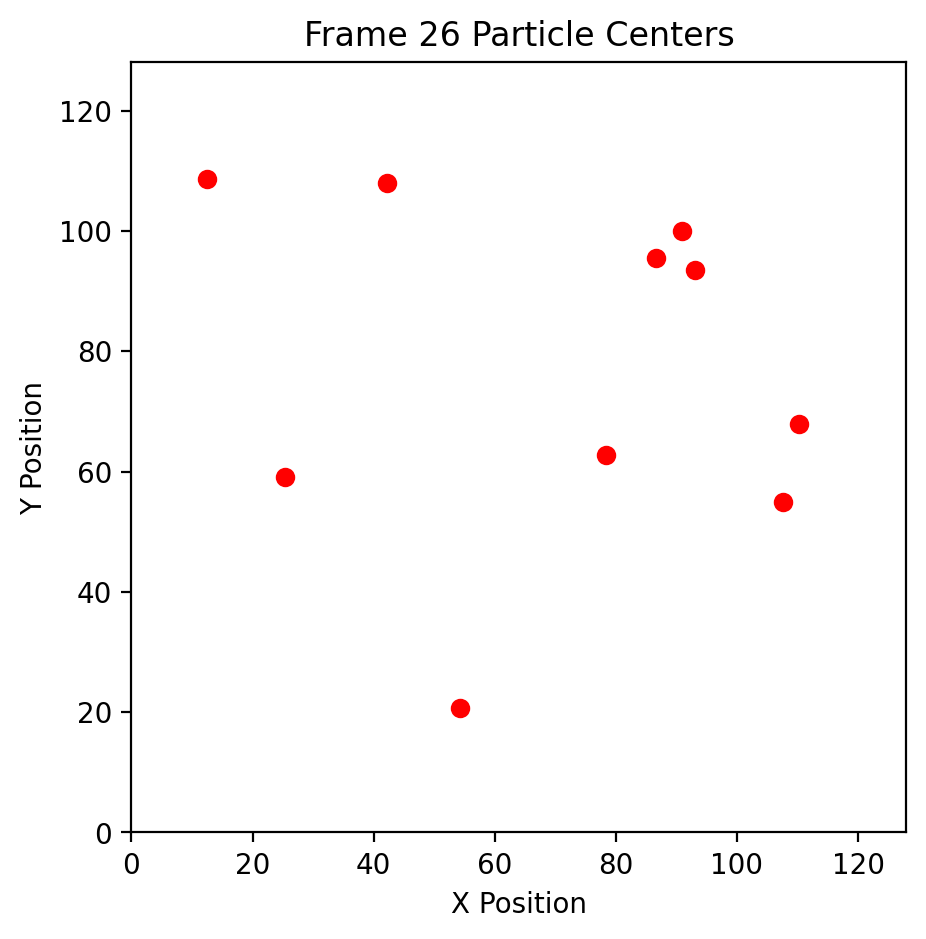

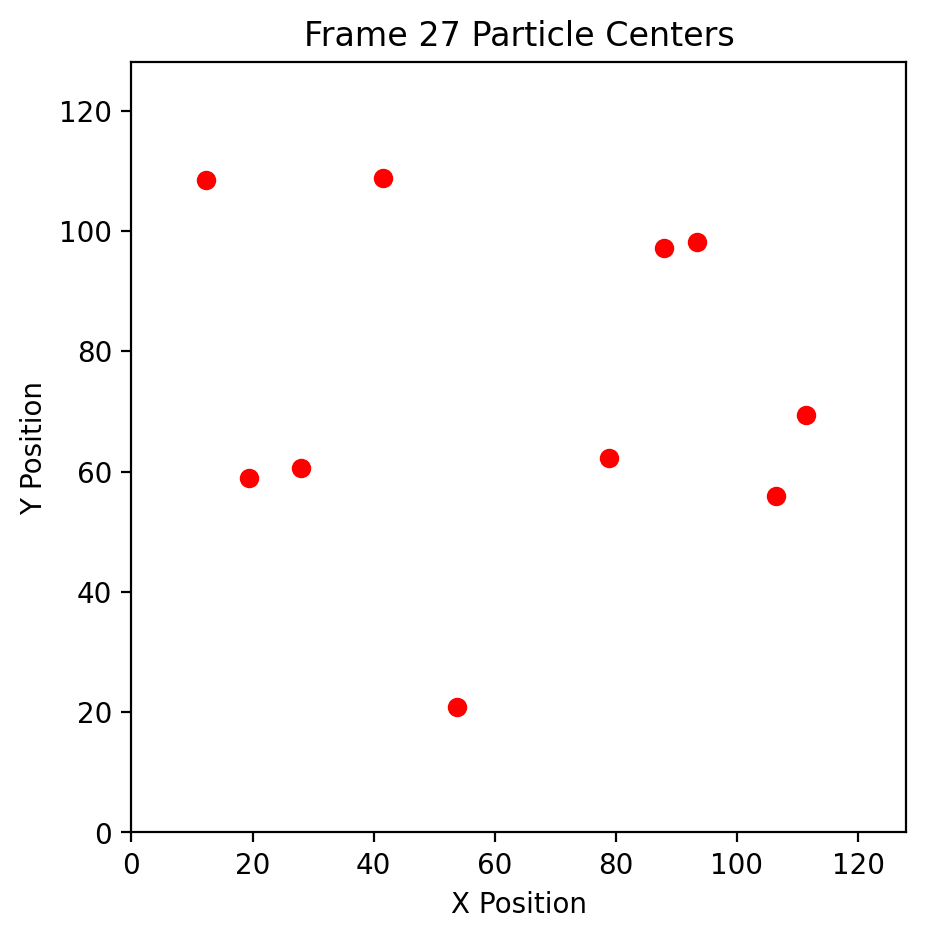

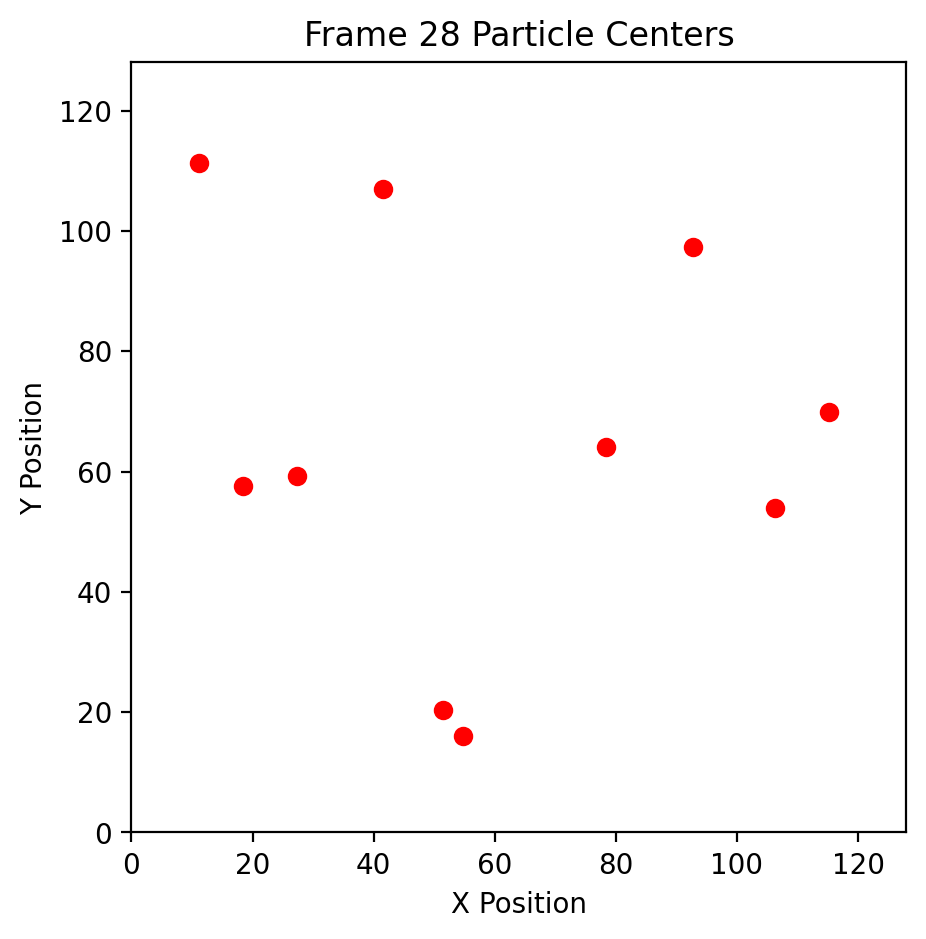

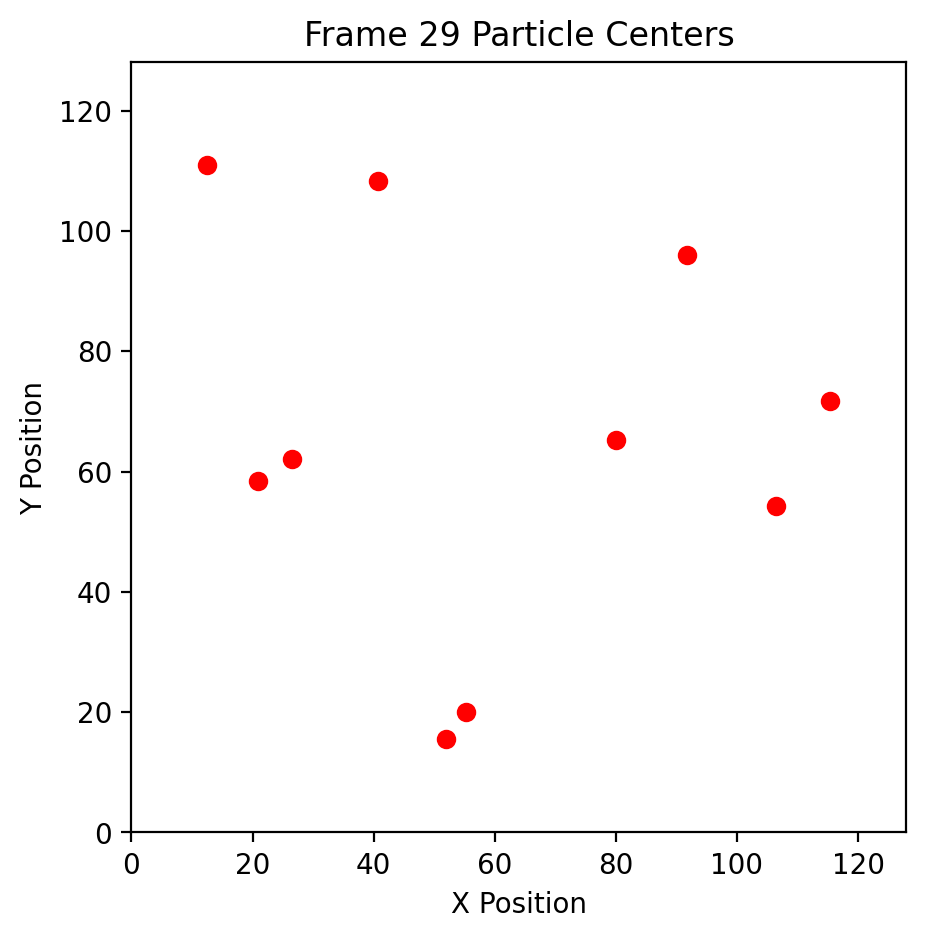

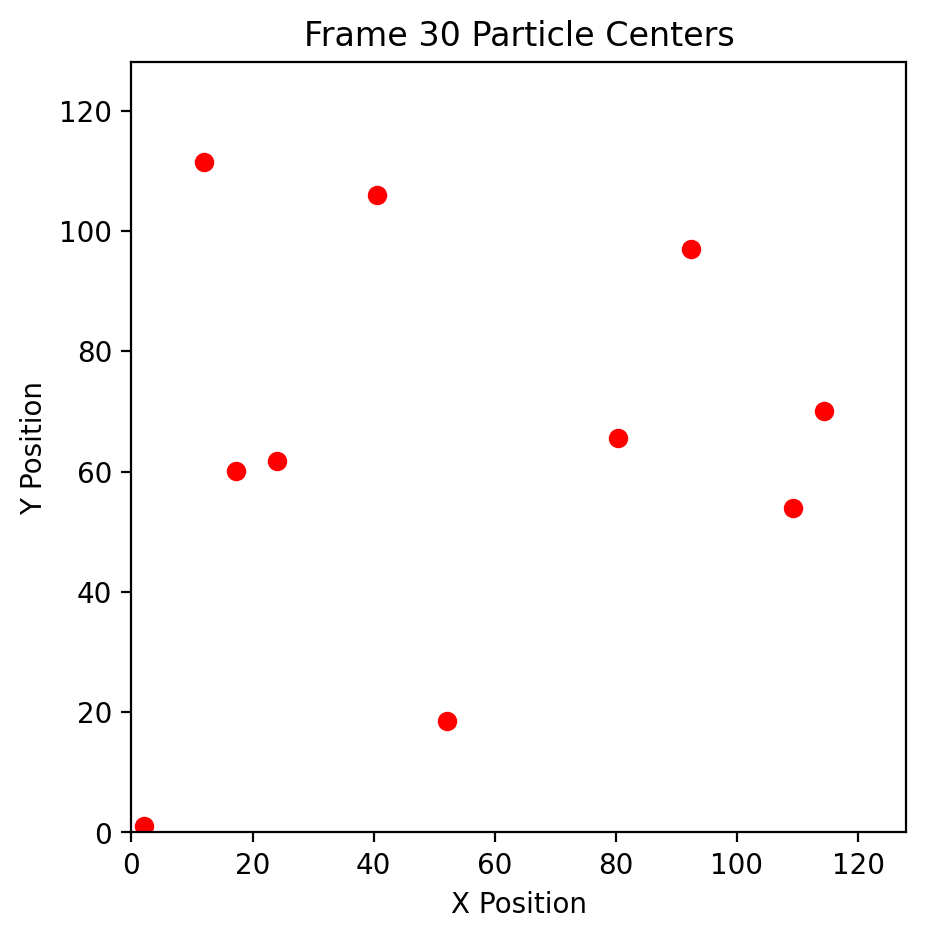

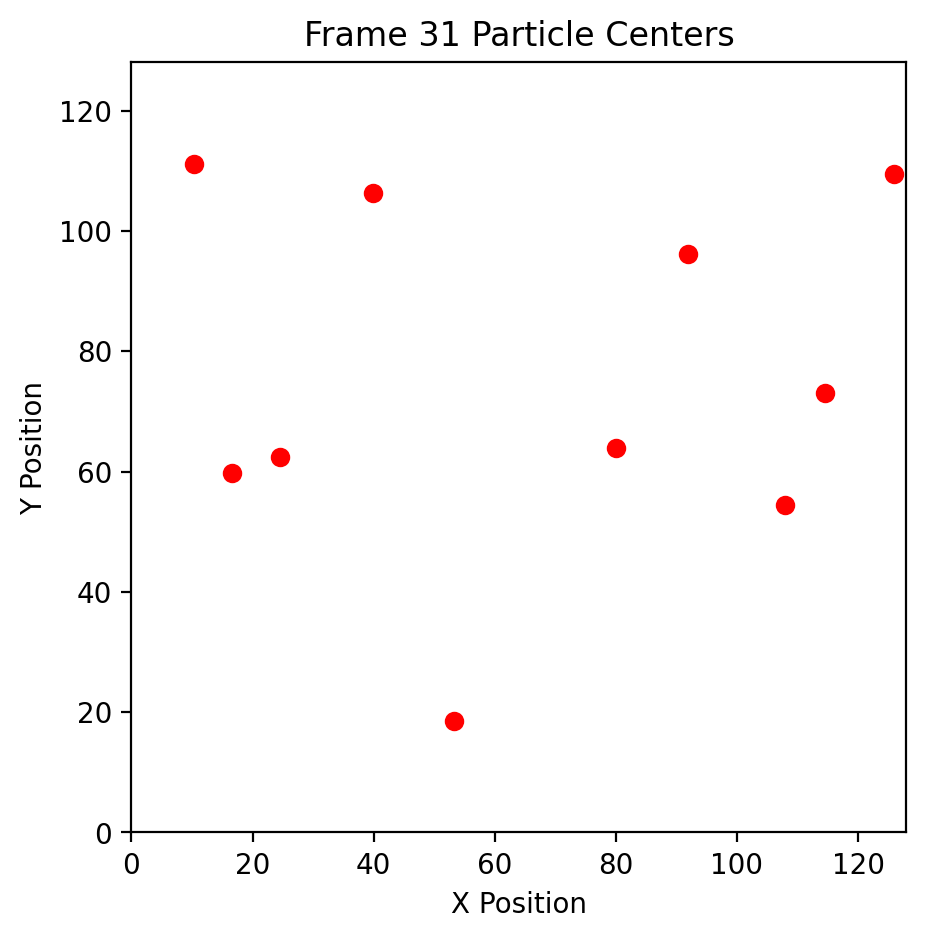

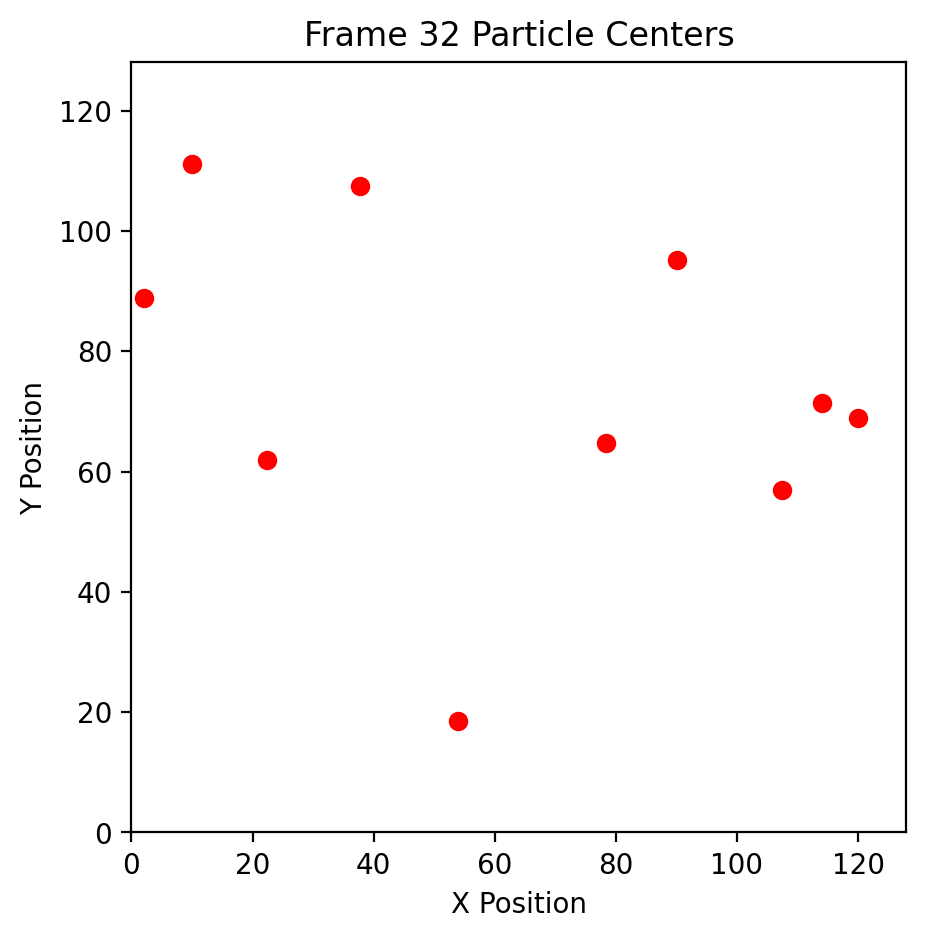

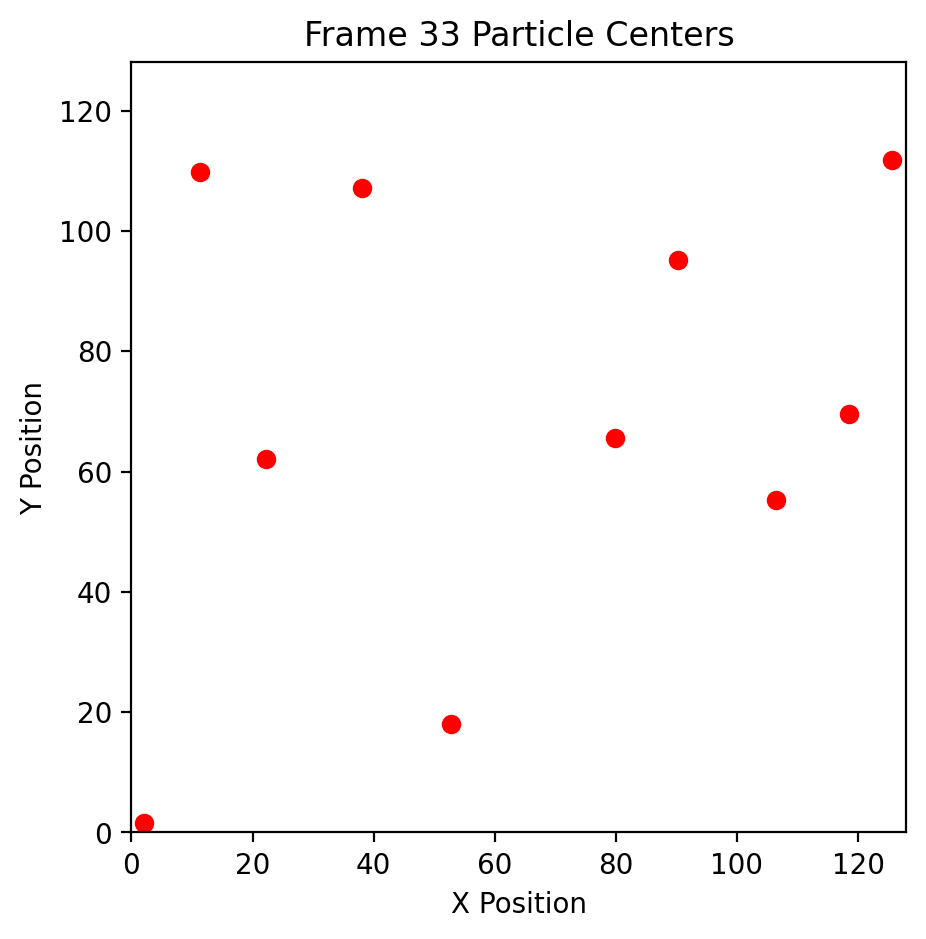

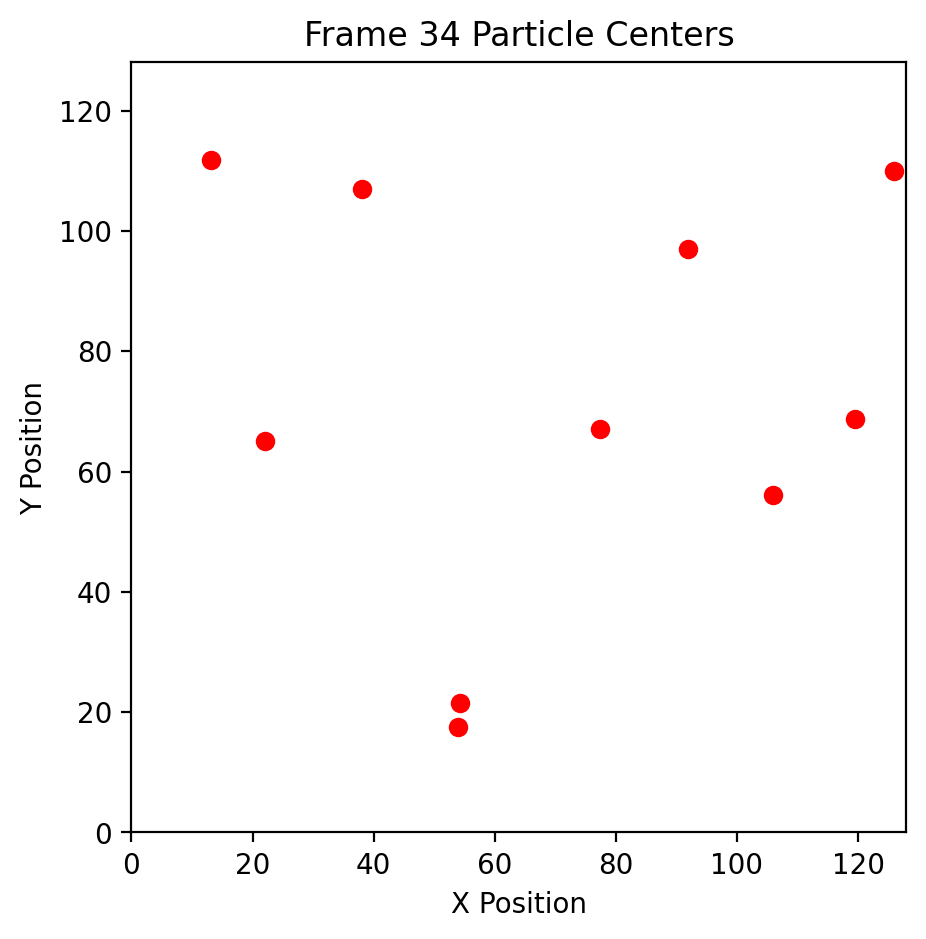

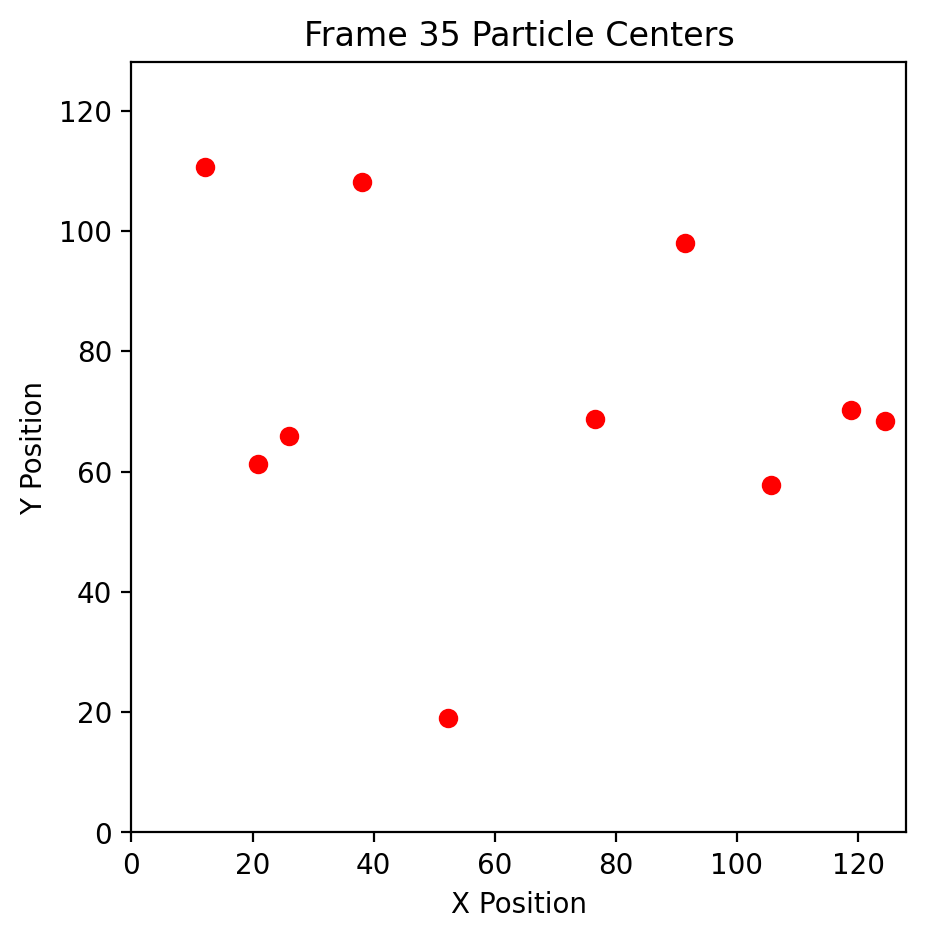

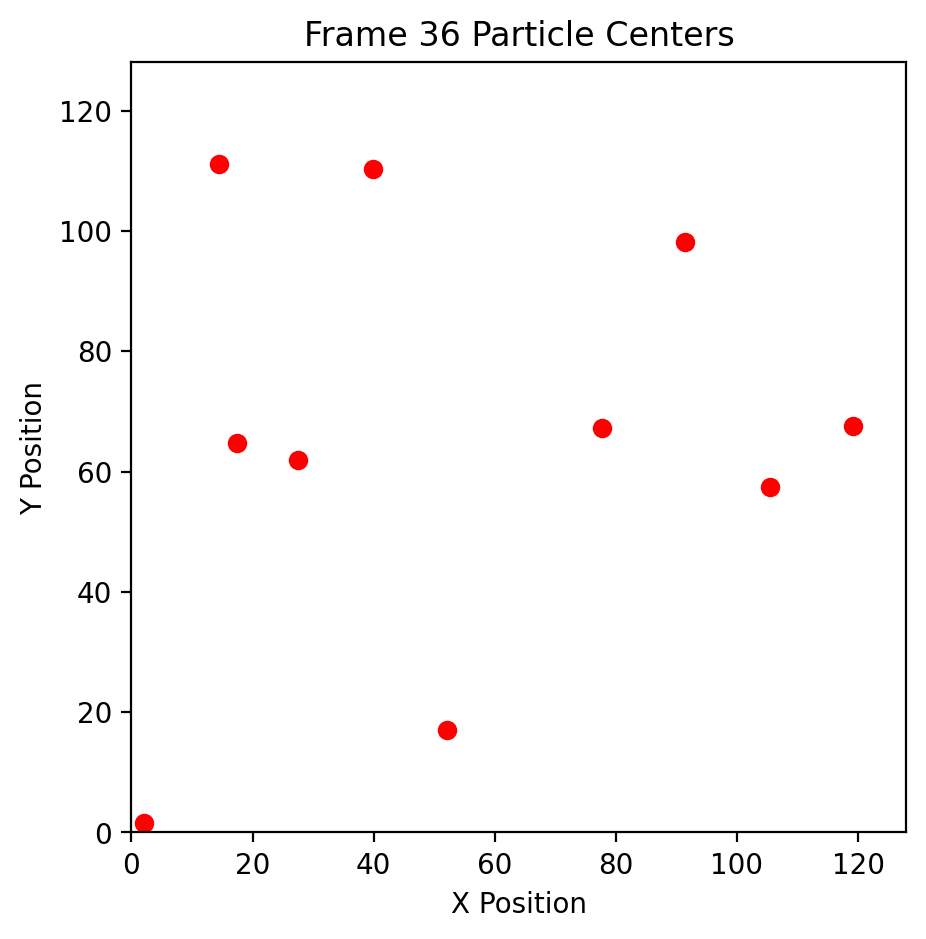

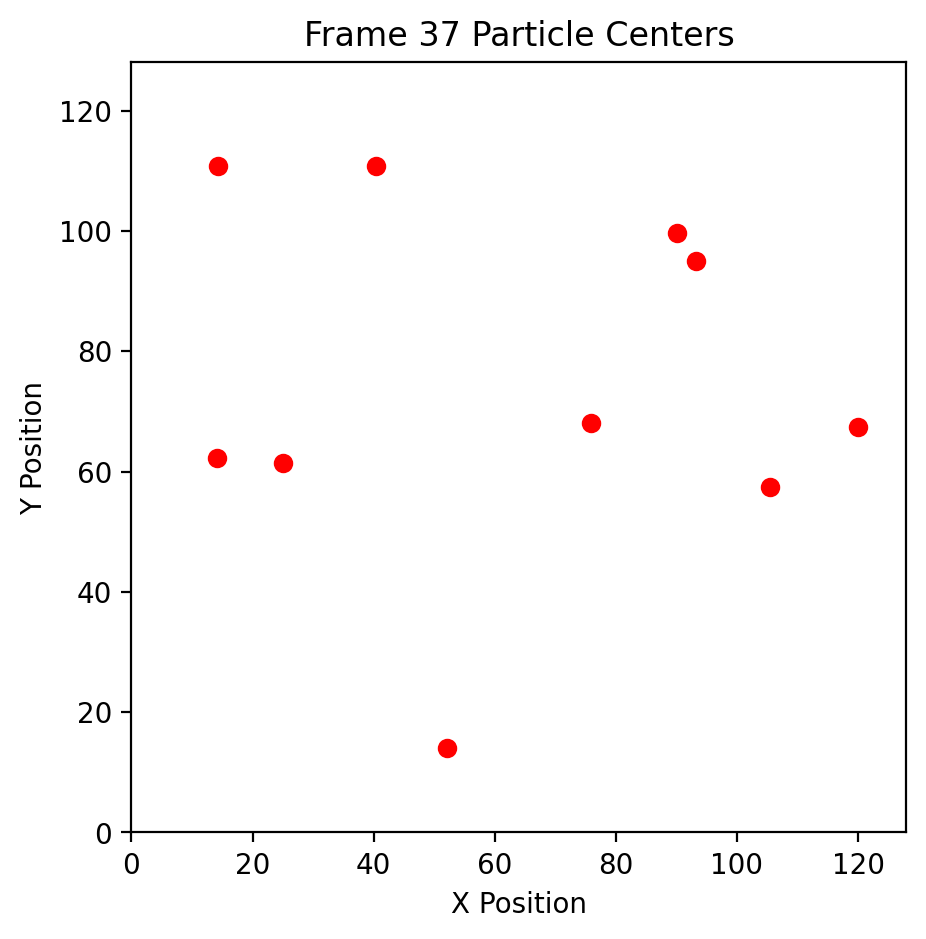

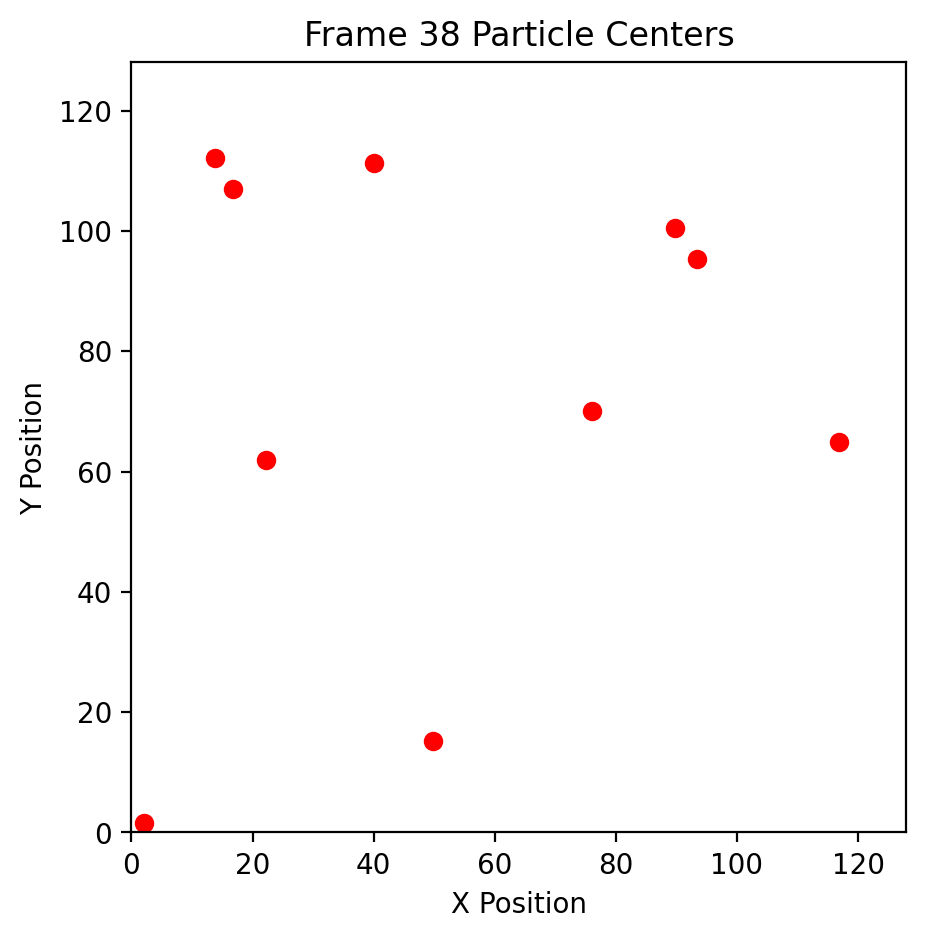

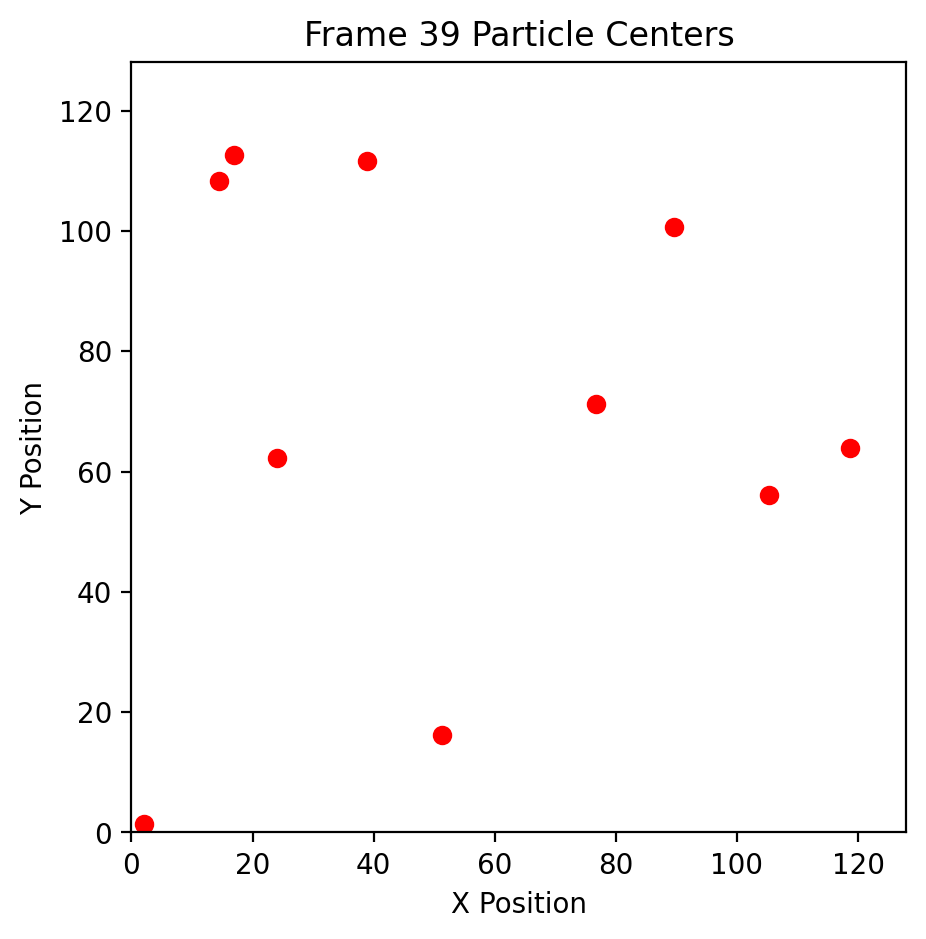

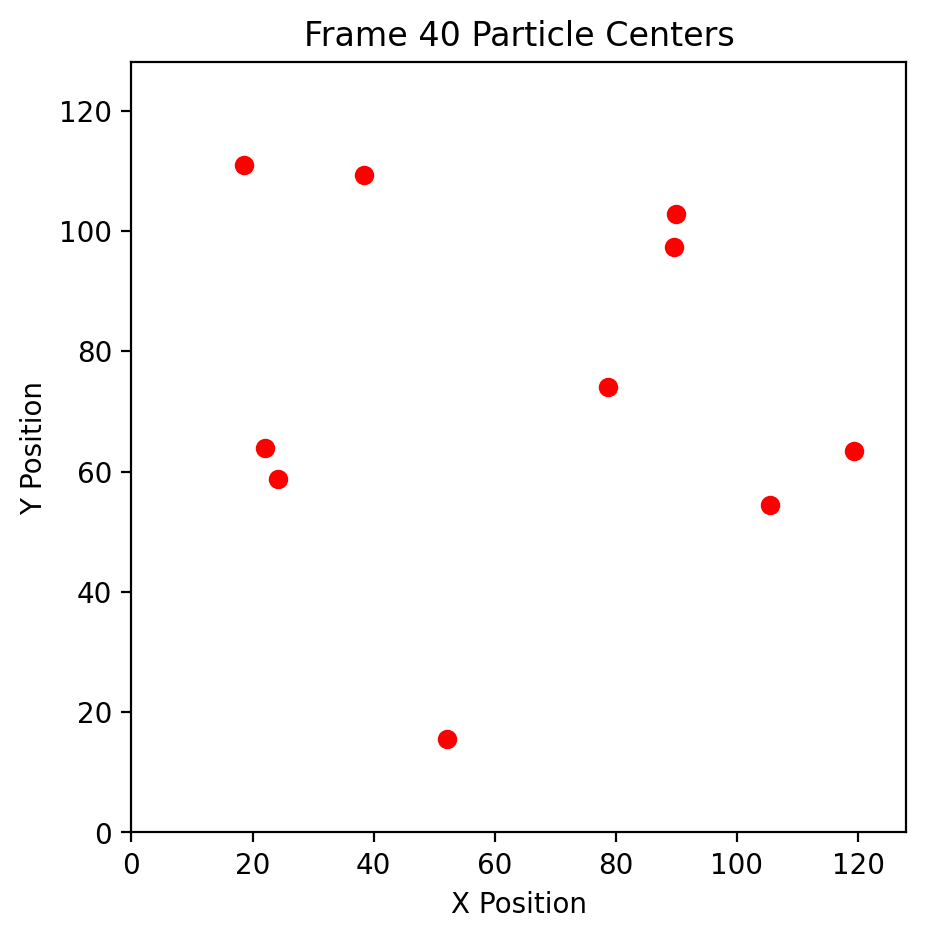

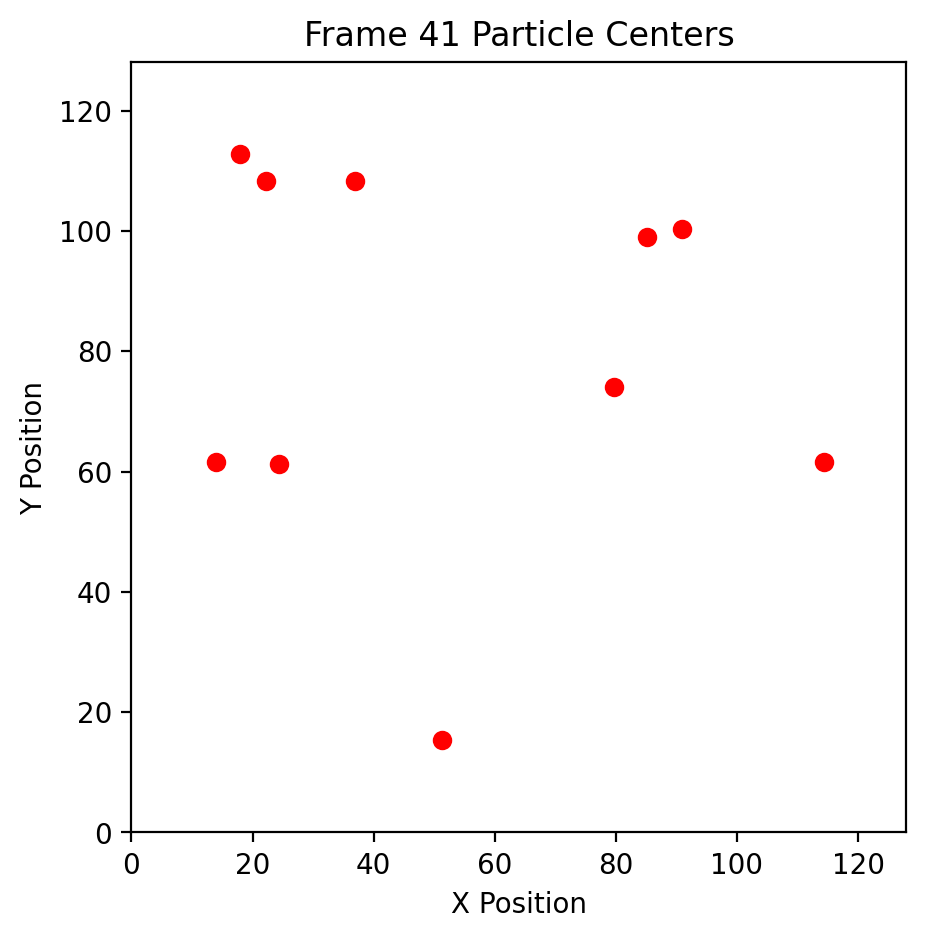

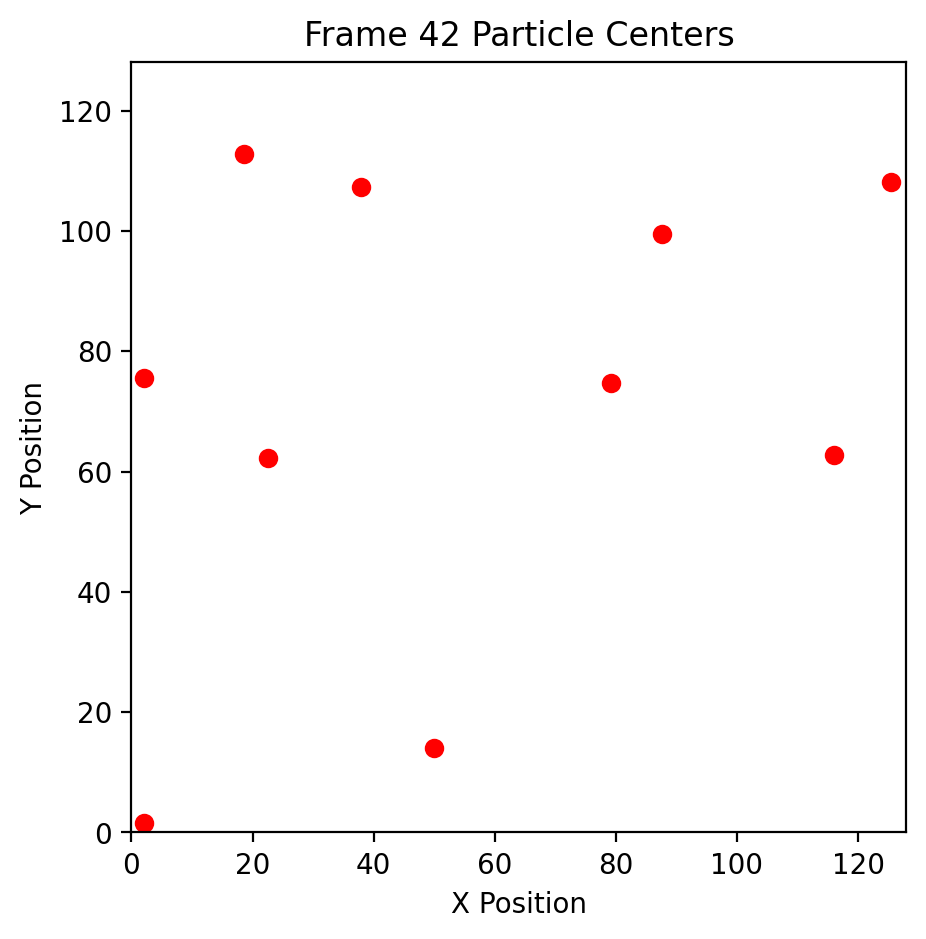

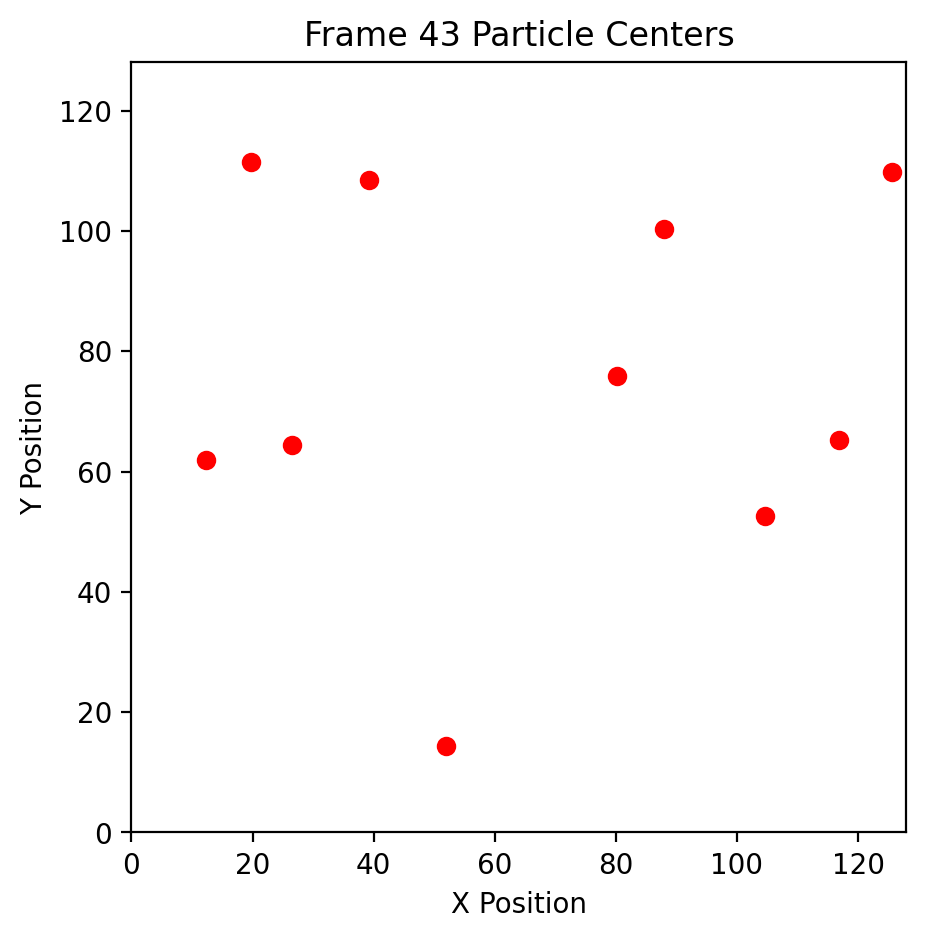

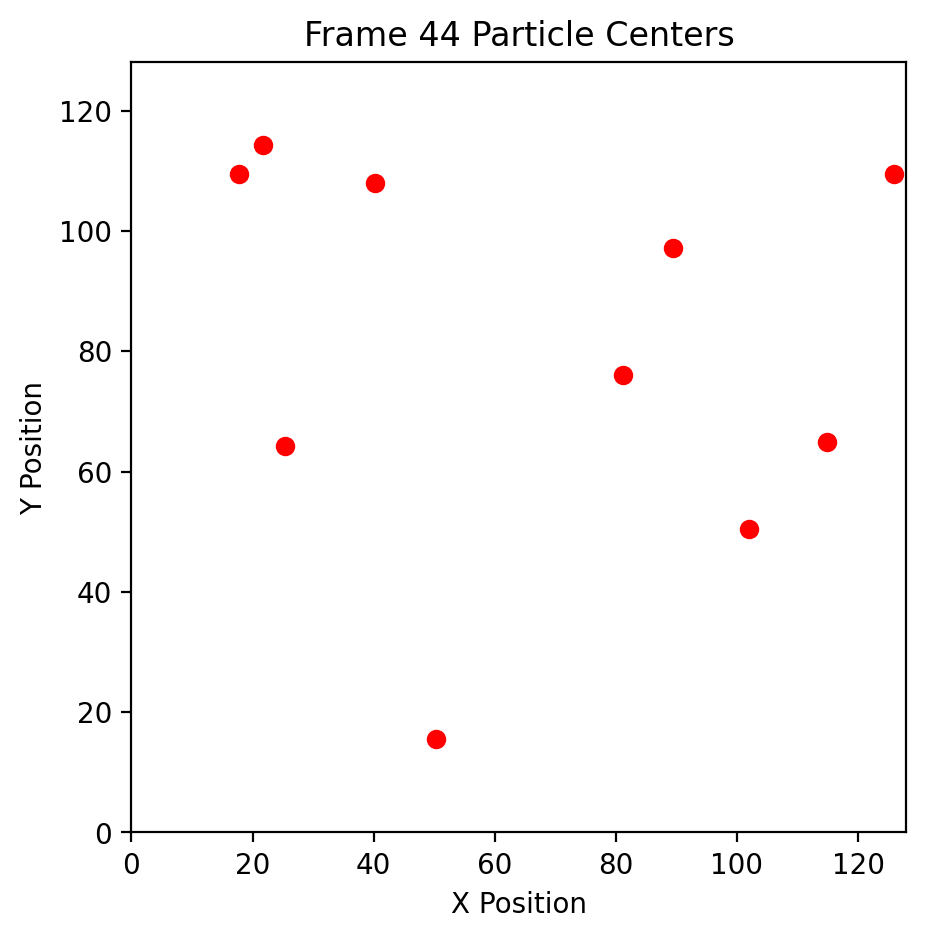

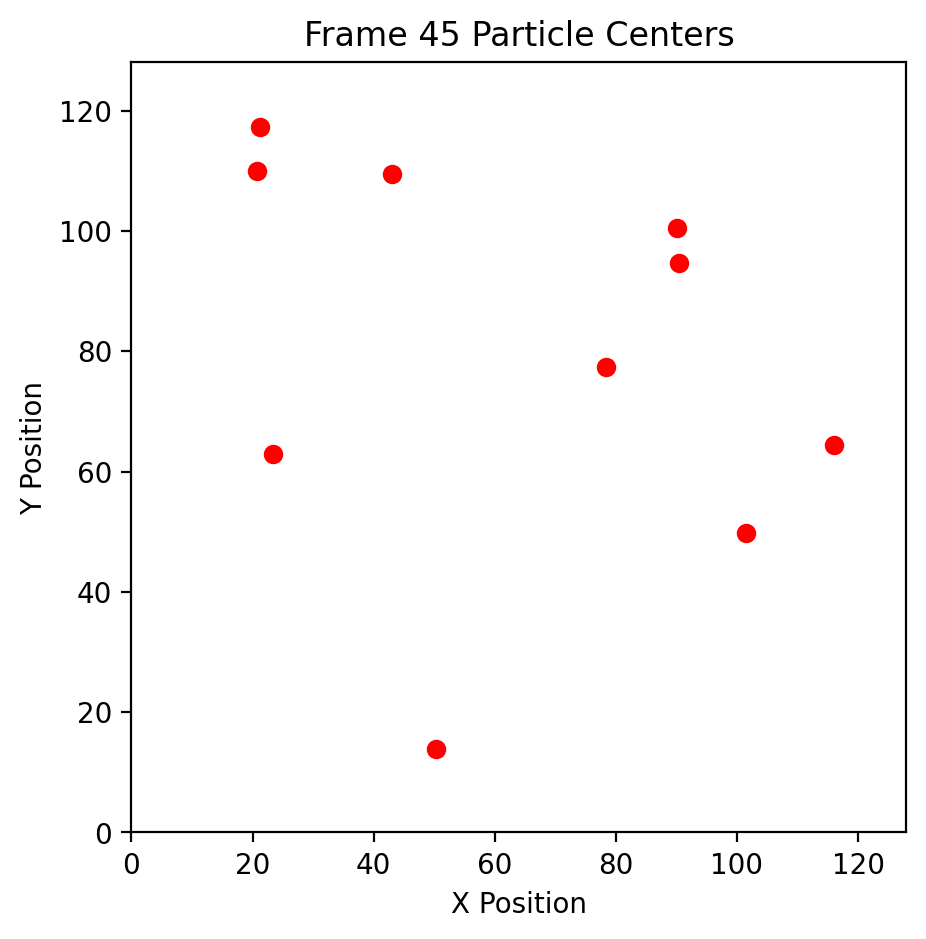

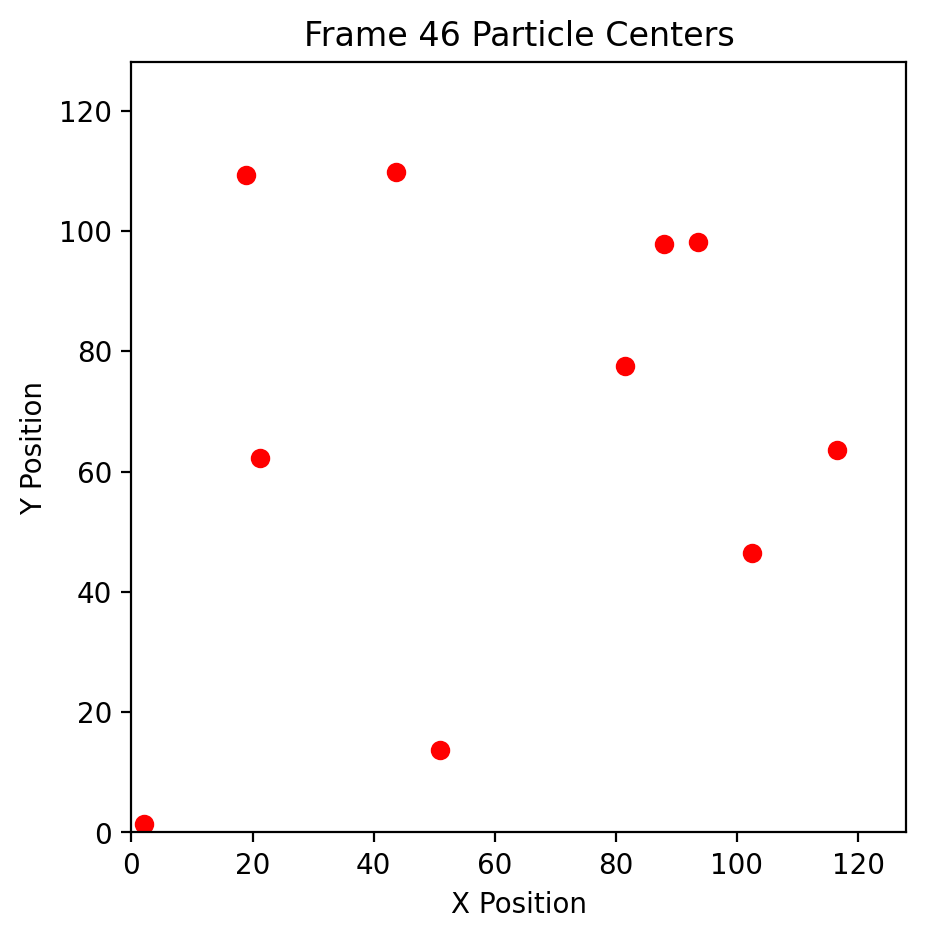

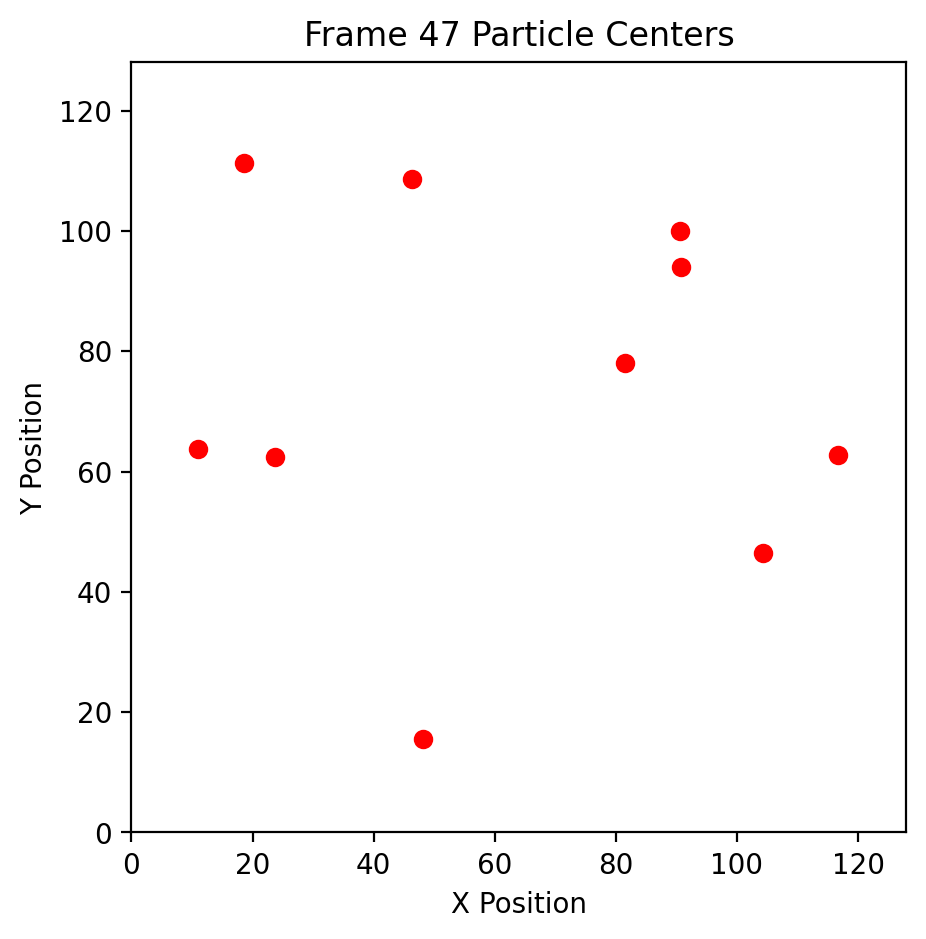

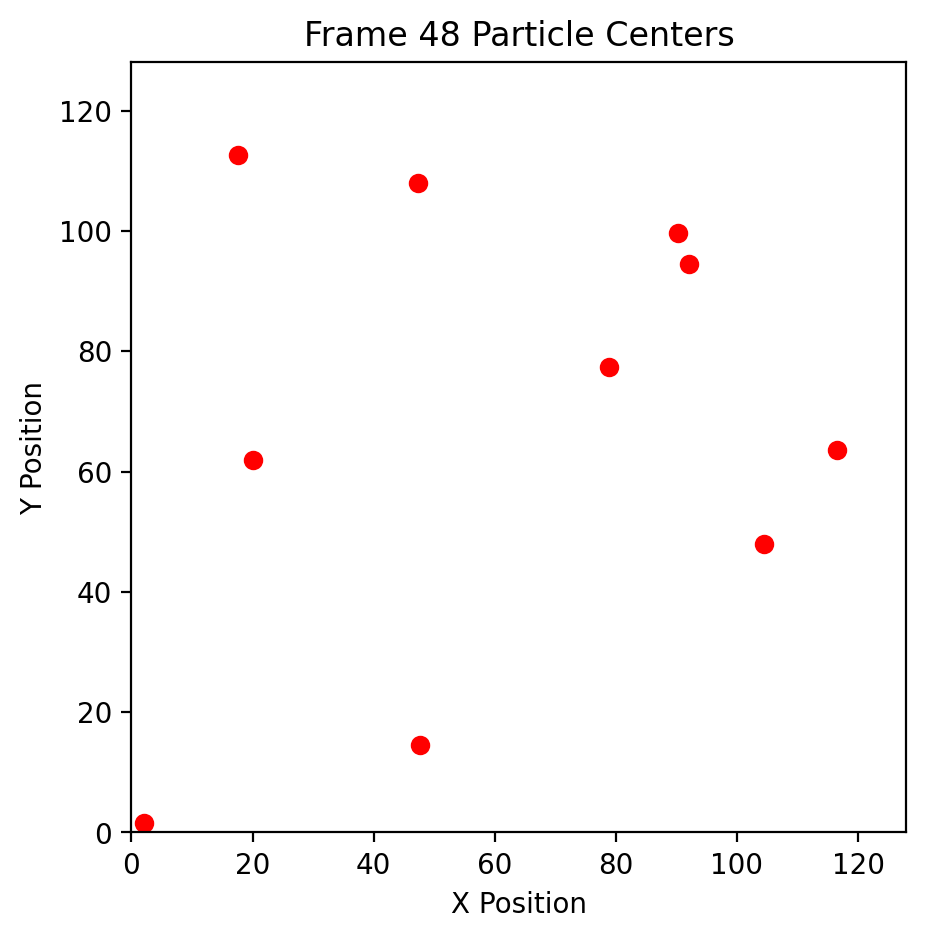

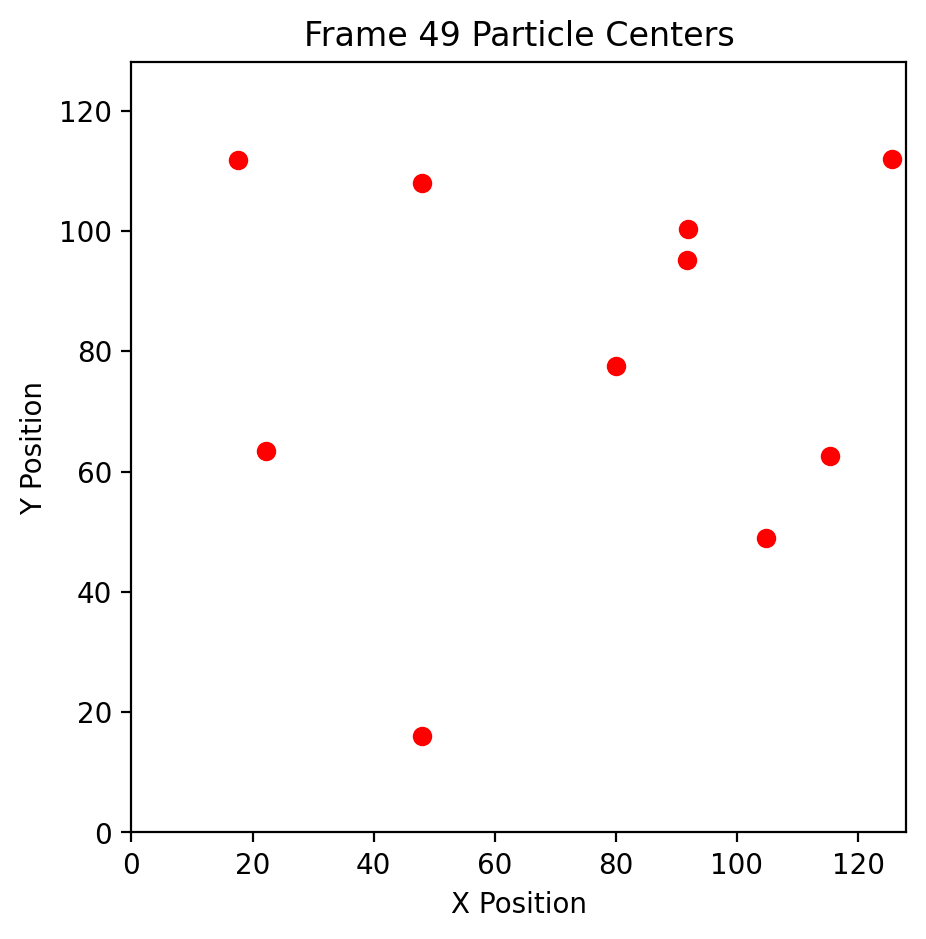

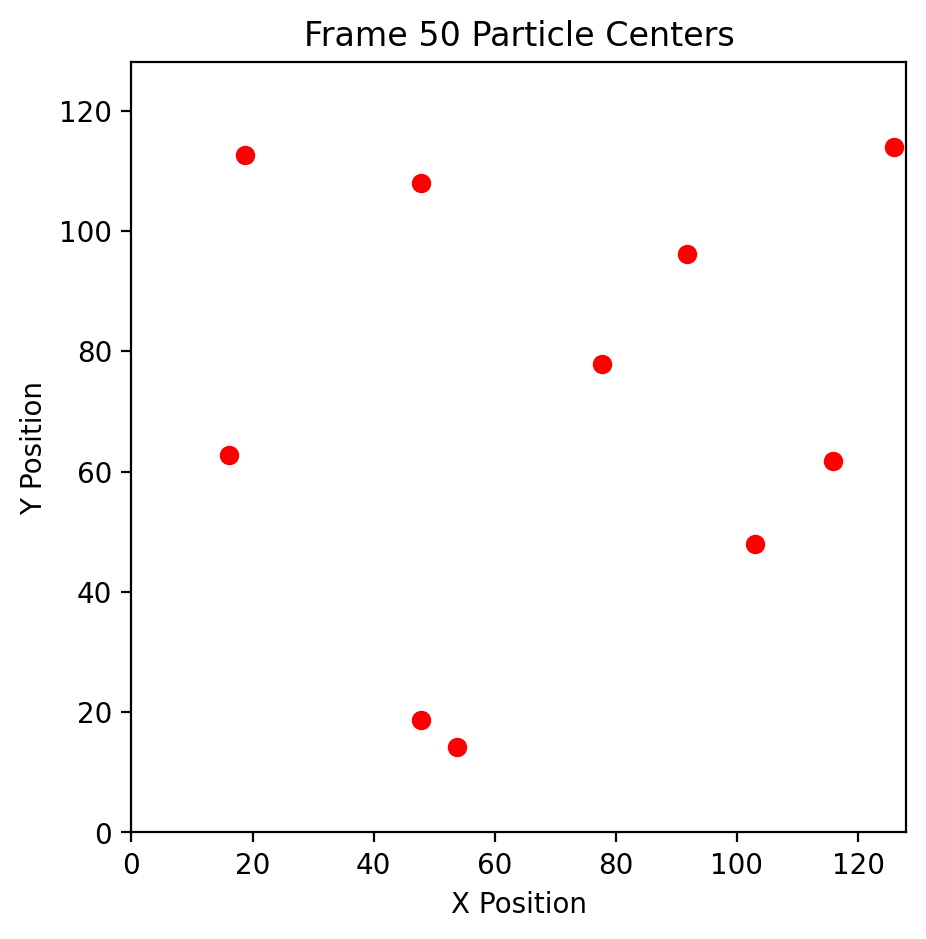

In [501]:
# Iterate through centers_per_frame and plot a scatter plot for each frame
for i, centers in enumerate(centers_per_frame):
    plt.figure(figsize=(5, 5))
    plt.scatter(centers[:, 1], centers[:, 0], c='r', marker='o')  # Mark particle centers with red circles
    plt.title(f"Frame {i + 1} Particle Centers")
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.xlim(0, 128)
    plt.ylim(0, 128)

plt.show()

# Goal 3: Given a video and particle positions (from the training data generator) develop a neural network to estimate the z-position of each particle
This one is somewhat speculative. It should be possible, but I have not tried it myself.

In [615]:
# Generate a video
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

In [616]:
def extract_patches_tf(vid, tracks, patch_size):
    half_patch = patch_size // 2
    Nt, Ny, Nx = vid.shape
    _, Nparticles, _ = tracks.shape

    patches = []  # Initialize list for training data
    z_coords = []

    for t in tf.range(Nt):
        for p in tf.range(Nparticles):
            x, y, z = tracks[t, p, 0], tracks[t, p, 1], tracks[t, p, 2]
            # Ensure x, y coordinates do not exceed 256 and are not less than 0
            x = tf.minimum(tf.maximum(tf.cast(tf.round(x), tf.int32), 0), 256)
            y = tf.minimum(tf.maximum(tf.cast(tf.round(y), tf.int32), 0), 256)

            # Calculate the coordinates of the extraction area, ensuring they do not exceed the boundaries of vid
            x_min = tf.maximum(x - half_patch, 0)
            y_min = tf.maximum(y - half_patch, 0)
            x_max = tf.minimum(x + half_patch + 1, Nx)
            y_max = tf.minimum(y + half_patch + 1, Ny)

            # Extract the image patch
            patch = vid[t, y_min:y_max, x_min:x_max]
            
            # Calculate the size of padding needed, ensuring it's non-negative
            padding_needed = [[0, tf.maximum(0, patch_size - (y_max - y_min))], 
                              [0, tf.maximum(0, patch_size - (x_max - x_min))]]

            # Pad to the desired size with 0
            patch_padded = tf.pad(patch, padding_needed, "CONSTANT", constant_values=0)
            
            # Ensure each patch is of size patch_size * patch_size
            patch_padded = tf.reshape(patch_padded, [patch_size, patch_size])
            
            patches.append(patch_padded)
            z_coords.append(z)

    patches = tf.stack(patches)
    z_coords = tf.stack(z_coords)
    
    return patches, z_coords





# def extract_patches_tf(vid, tracks, patch_size):
#     half_patch = patch_size // 2
#     Nt, Ny, Nx = vid.shape
#     _, Nparticles, _ = tracks.shape

#     patches = []  # 初始化训练数据列表
#     z_coords = []

#     for t in tf.range(Nt):
#         for p in tf.range(Nparticles):
#             x, y, z = tracks[t, p, 0], tracks[t, p, 1], tracks[t, p, 2]
#             # 确保x, y坐标不超过256，且不小于0
#             x = tf.minimum(tf.maximum(tf.cast(tf.round(x), tf.int32), 0), Nx - 1)
#             y = tf.minimum(tf.maximum(tf.cast(tf.round(y), tf.int32), 0), Ny - 1)

#             # 计算提取区域的坐标，确保它们不超出vid的边界
#             x_min = tf.maximum(x - half_patch, 0)
#             y_min = tf.maximum(y - half_patch, 0)
#             x_max = tf.minimum(x + half_patch + 1, Nx)
#             y_max = tf.minimum(y + half_patch + 1, Ny)

#             # 提取图像区域
#             patch = vid[t, y_min:y_max, x_min:x_max]

#             # 计算提取区域的像素均值
#             mean_val = tf.reduce_mean(patch)

#             # 计算需要填充的大小，确保非负
#             padding_needed = [[0, tf.maximum(0, patch_size - (y_max - y_min))], 
#                               [0, tf.maximum(0, patch_size - (x_max - x_min))]]

#             # 使用均值填充到期望的大小
#             patch_padded = tf.pad(patch, padding_needed, "CONSTANT", constant_values=mean_val)
            
#             # 确保每个图像块都是patch_size * patch_size的大小
#             patch_padded = tf.reshape(patch_padded, [patch_size, patch_size])
            
#             patches.append(patch_padded)
#             z_coords.append(z)

#     patches = tf.stack(patches)
#     z_coords = tf.stack(z_coords)
    
#     return patches, z_coords


patch_size = 51
# Convert vid and tracks to tensors if they are not already
vid = tf.convert_to_tensor(vid, dtype=tf.float32)
tracks = tf.convert_to_tensor(tracks, dtype=tf.float32)
patches, z_coords = extract_patches_tf(vid, tracks, patch_size)

In [619]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=49), Checkbox(value=True, description='show_trac…

In [623]:
tracks.shape

TensorShape([50, 10, 3])

In [633]:
print(tracks[0, 2])

tf.Tensor([258.6982   116.93767   25.897766], shape=(3,), dtype=float32)


In [634]:
# 设置打印选项
np.set_printoptions(threshold=np.inf)

print(patches[2].numpy())

[[16936. 17975. 16402. 14842. 16151. 11756. 18411. 14869. 15596. 18326.
  15313. 18804. 16246. 14419. 16498. 19865. 20043. 19306. 16160. 15959.
  15379. 14350. 18865. 19451. 17203.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.]
 [13582. 20209. 17824. 16516. 15331. 13825. 13841. 17091. 16313. 12912.
  13477. 15932. 13122. 17806. 15594. 13783. 17807. 14017. 14132. 15683.
  16887. 18693. 14482. 13827. 15229.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.]
 [15523. 13497. 11760. 18028. 13876. 11277. 13914. 13499. 12261. 15794.
  13707. 15430. 19668. 12918. 19521. 13807. 18620. 17153. 16202. 17443.
  16537. 13799. 14516. 16215. 19350.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0. 

In [588]:
# def create_model(input_shape=(51, 51, 1)):
#     model = models.Sequential([
#         layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Conv2D(128, (3, 3), activation='relu'),  # 新增的卷积层
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Flatten(),
#         layers.Dropout(0.5),  # 添加 Dropout 层
#         layers.Dense(128, activation='relu'),  # 增加全连接层的单元数
#         layers.BatchNormalization(),
        
#         layers.Dense(1)
#     ])
#     return model

In [614]:
def create_model(input_shape=(51, 51, 1)):
    model = models.Sequential([
        # First convolutional layer
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional layer
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional layer
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Flattening and fully connected layers
        layers.Flatten(),
        layers.Dropout(0.4),  # Adjust the Dropout rate to achieve better generalization
        layers.Dense(256, activation='relu'),  # Increase the number of units in the fully connected layer to enhance model complexity
        layers.BatchNormalization(),
        
        layers.Dropout(0.4),  # Also introduce Dropout between the fully connected layers
        layers.Dense(128, activation='relu'),  
        layers.BatchNormalization(),
        
        # 输出层
        layers.Dense(1, activation='linear')  # Assuming the output is a continuous value, use a linear activation function
    ])
    return model

In [590]:
model_Z_Position = create_model()
model_Z_Position.compile(optimizer='adam', loss='mean_squared_error')  

In [579]:
# model_Z_Position.save('model_Z1.keras')

In [593]:
from tensorflow.keras.models import load_model

model_Z_Position = load_model('model_Z1.keras')

# # model = load_model('model1.keras', compile=False)  # 加载模型，不编译
# # model.compile(optimizer='rmsprop', loss='weighted_binary_crossentropy')  # 重新配置优化器和损失函数

In [591]:
patches = tf.expand_dims(patches, axis=-1)  # 增加通道维度
history = model_Z_Position.fit(patches, z_coords, epochs=10, validation_split=0.2)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 154.9913 - val_loss: 3886.7124
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 55.7933 - val_loss: 3759.7773
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 41.4991 - val_loss: 2099.4243
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 26.8963 - val_loss: 751.6263
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 22.6069 - val_loss: 309.9817
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 12.9654 - val_loss: 242.6181
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 16.2945 - val_loss: 193.5694
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 10.0794 - val_loss: 189.7026
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 11.1786 - val_loss: 165.5309
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 11.3140 - val_loss: 148.5744


In [582]:
num_videos = 100
for i in range(num_videos):
    print(i)
    vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)
    # Convert vid and tracks to tensors if they are not already
    vid = tf.convert_to_tensor(vid, dtype=tf.float32)
    tracks = tf.convert_to_tensor(tracks, dtype=tf.float32)
    patches, z_coords = extract_patches_tf(vid, tracks, patch_size)   
    patches = tf.expand_dims(patches, axis=-1)  # Increase channel dimension
    model_Z_Position.fit(patches, z_coords, epochs=10, validation_split=0.2)

0
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 226.9202 - val_loss: 455.1880
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 191.6508 - val_loss: 469.1246
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 96.9602 - val_loss: 788.8318
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 87.5730 - val_loss: 684.5045
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 84.7147 - val_loss: 402.3235
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 68.9421 - val_loss: 256.6063
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 47.5519 - val_loss: 286.8993
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 50.1394 - val_loss: 280.7963
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 44.5680 - val_loss: 239.3559
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 43.0411 - val_loss: 228.5395
1
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 435.5755 - val_loss: 687.0387
Epoch 2/10
13

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 99.7377 - val_loss: 250.7076
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 83.1771 - val_loss: 217.7210
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 70.3033 - val_loss: 170.1242
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 74.0908 - val_loss: 179.4474
7
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 293.0619 - val_loss: 486.8655
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 147.6793 - val_loss: 66.7212
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 92.5773 - val_loss: 122.2587
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 74.1503 - val_loss: 226.1944
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 52.7146 - val_loss: 189.8919
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 61.9103 - val_loss: 79.0993
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 63.3736 - val_loss: 58.5531
Epoch 8/10
13/13 ━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 97.0410 - val_loss: 582.2729
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 57.6707 - val_loss: 388.0755
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 41.3010 - val_loss: 355.2747
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 35.4817 - val_loss: 375.4591
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 32.2040 - val_loss: 335.5612
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 21.3914 - val_loss: 440.9753
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 29.7881 - val_loss: 614.9694
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 19.8645 - val_loss: 525.2535
14
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 236.4516 - val_loss: 203.4594
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 102.4079 - val_loss: 395.2651
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 63.5647 - val_loss: 393.9998
Epoch 4/10
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 60.0624 - val_loss: 28.8401
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 36.0352 - val_loss: 25.1848
20
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 330.2359 - val_loss: 385.9257
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 76.3965 - val_loss: 284.0753
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 55.2198 - val_loss: 111.1123
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 32.1556 - val_loss: 253.2995
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 37.4782 - val_loss: 256.1193
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 23.8483 - val_loss: 59.4200
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 29.8654 - val_loss: 30.2838
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 19.1418 - val_loss: 30.9854
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 15.2756 - val_loss: 25.9232
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 33.4858 - val_loss: 250.6209
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 40.1708 - val_loss: 246.6177
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 24.2237 - val_loss: 179.2557
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 17.6217 - val_loss: 115.8175
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 19.2137 - val_loss: 49.5998
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 21.1722 - val_loss: 42.3449
27
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 264.5923 - val_loss: 771.4648
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 121.9479 - val_loss: 543.7125
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 103.5940 - val_loss: 415.5764
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 68.6461 - val_loss: 407.6480
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 104.4232 - val_loss: 405.1404
Epoch 6/10
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 128.7245 - val_loss: 282.0126
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 83.1083 - val_loss: 181.1949
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 58.3028 - val_loss: 112.7089
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 51.7633 - val_loss: 173.0706
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 41.3102 - val_loss: 158.2939
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 38.3635 - val_loss: 206.6354
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 39.1221 - val_loss: 99.7438
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 43.7768 - val_loss: 104.8089
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 31.3968 - val_loss: 59.0911
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 30.2350 - val_loss: 161.0848
34
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 43.3675 - val_loss: 723.0005
Epoch 2/10
13/13 ━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 28.8489 - val_loss: 46.5971
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 34.4280 - val_loss: 48.0367
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 21.7052 - val_loss: 48.8347
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 32.5869 - val_loss: 45.1252
40
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 103.2185 - val_loss: 47.7223
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 46.9094 - val_loss: 69.0103
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 27.4969 - val_loss: 45.1708
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 28.9149 - val_loss: 38.7641
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 30.0136 - val_loss: 33.0668
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 20.8031 - val_loss: 31.5792
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 24.4663 - val_loss: 28.1446
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 35.1697 - val_loss: 443.1937
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 17.8311 - val_loss: 66.9823
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 27.4635 - val_loss: 114.3646
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 21.3099 - val_loss: 766.1128
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 27.0422 - val_loss: 911.0806
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 23.0845 - val_loss: 447.9163
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 34.9031 - val_loss: 232.9530
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 12.9730 - val_loss: 229.8106
47
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 152.2425 - val_loss: 294.7064
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 106.6866 - val_loss: 323.2276
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 75.4570 - val_loss: 137.8984
Epoch 4/10
13/13 ━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 11.1508 - val_loss: 18.2020
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 11.8233 - val_loss: 19.0722
53
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 311.8553 - val_loss: 188.6289
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 216.1333 - val_loss: 177.7884
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 159.0707 - val_loss: 161.5812
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 148.5063 - val_loss: 123.2234
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 104.2691 - val_loss: 79.1413
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 99.3705 - val_loss: 67.3599
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 93.4892 - val_loss: 78.3151
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 84.3357 - val_loss: 58.4184
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 63.6994 - val_loss: 43.4391
Epoch 10/10
13/13 ━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 23.5151 - val_loss: 271.7862
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 18.6182 - val_loss: 222.0818
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 14.4396 - val_loss: 233.9450
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 12.0525 - val_loss: 427.6271
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 29.3801 - val_loss: 535.7234
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 17.3391 - val_loss: 449.6971
60
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 234.6699 - val_loss: 1189.6561
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 137.7233 - val_loss: 90.3899
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 97.5122 - val_loss: 162.0205
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 71.3008 - val_loss: 167.3381
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 58.0728 - val_loss: 159.7557
Epoch 6/10
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 144.2217 - val_loss: 461.3878
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 41.4826 - val_loss: 486.0395
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 27.5615 - val_loss: 405.1390
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 25.5825 - val_loss: 534.5209
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 24.5680 - val_loss: 588.3970
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 16.9826 - val_loss: 578.8968
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 29.1961 - val_loss: 498.4608
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 13.3932 - val_loss: 480.9925
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 13.0429 - val_loss: 383.9347
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 13.3683 - val_loss: 380.6938
67
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 273.2299 - val_loss: 275.1055
Epoch 2/10
13/13 ━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 24.3510 - val_loss: 746.8044
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 21.1833 - val_loss: 636.5771
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 19.5978 - val_loss: 504.1699
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 16.1354 - val_loss: 193.1075
73
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 168.5499 - val_loss: 401.6636
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 58.4933 - val_loss: 536.7309
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 57.6442 - val_loss: 431.0997
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 32.8923 - val_loss: 375.3579
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 44.1467 - val_loss: 426.4702
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 52.8420 - val_loss: 462.2752
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 34.4331 - val_loss: 430.7047
Epoch 8/10
13/13 ━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 149.0565 - val_loss: 566.6800
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 119.0971 - val_loss: 45.8969
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 90.4686 - val_loss: 486.1733
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 87.8123 - val_loss: 423.0297
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 52.3031 - val_loss: 205.0286
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 77.2679 - val_loss: 30.8557
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 59.6555 - val_loss: 134.6387
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 53.1723 - val_loss: 278.4911
80
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 45.1426 - val_loss: 833.8213
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 26.5230 - val_loss: 751.3436
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 20.5892 - val_loss: 329.4220
Epoch 4/10
13/13 ━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 29.3493 - val_loss: 309.8638
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 25.5071 - val_loss: 310.5915
86
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 202.4519 - val_loss: 243.3379
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 87.1940 - val_loss: 227.2919
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 57.8079 - val_loss: 240.3597
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 41.2524 - val_loss: 235.3941
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 49.1362 - val_loss: 269.0591
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 38.7234 - val_loss: 244.0362
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 29.5175 - val_loss: 105.5373
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 31.5826 - val_loss: 195.2971
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 26.0580 - val_loss: 64.9561
Epoch 10/10
13/13 ━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 63.2757 - val_loss: 45.0330
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 41.9527 - val_loss: 38.6378
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 23.5731 - val_loss: 34.8723
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 39.5643 - val_loss: 31.0884
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 26.5582 - val_loss: 28.8439
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 23.1552 - val_loss: 27.0932
93
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 80.8446 - val_loss: 331.5210
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 41.1021 - val_loss: 365.6660
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 20.7367 - val_loss: 401.4373
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 28.1981 - val_loss: 392.3798
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 27.1338 - val_loss: 386.0072
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 71.5982 - val_loss: 94.7013
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 46.7864 - val_loss: 88.7985
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 32.3867 - val_loss: 39.4398
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 21.7101 - val_loss: 33.7231
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 22.6769 - val_loss: 36.9314
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 18.4828 - val_loss: 81.8037
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 17.6234 - val_loss: 60.3377
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 22.9327 - val_loss: 33.3768
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 14.7648 - val_loss: 50.8859
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 26.9048 - val_loss: 56.2313


In [243]:
# num_videos = 30
# for i in range(num_videos):
#     vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)
#     # Convert vid and tracks to tensors if they are not already
#     vid = tf.convert_to_tensor(vid, dtype=tf.float32)
#     tracks = tf.convert_to_tensor(tracks, dtype=tf.float32)
#     patches, z_coords = extract_patches_tf(vid, tracks, patch_size)
#     # 标准化 patches
#     patches_mean = tf.reduce_mean(patches)
#     patches_std = tf.math.reduce_std(patches)
#     patches_standardized = (patches - patches_mean) / patches_std
    
#     # 标准化 z_coords
#     z_coords_mean = tf.reduce_mean(z_coords)
#     z_coords_std = tf.math.reduce_std(z_coords)
#     z_coords_standardized = (z_coords - z_coords_mean) / z_coords_std
    
#     model_Z_Position.fit(patches_standardized, z_coords_standardized, epochs=20, batch_size=10)

In [597]:
# Generate a test video
test_vid, test_labels, test_tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)
# Convert vid and tracks to tensors if they are not already
test_vid = tf.convert_to_tensor(test_vid, dtype=tf.float32)
test_tracks = tf.convert_to_tensor(test_tracks, dtype=tf.float32)
test_patches, test_z_coords = extract_patches_tf(test_vid, test_tracks, patch_size)

In [598]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(test_vid[t], origin='lower')
    if show_tracks:
        plot(test_tracks[t, :, 0], test_tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(test_vid[t], origin='lower')
    imshow(test_labels[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=49), Checkbox(value=True, description='show_trac…

In [599]:
predicted_z_coords = model_Z_Position.predict(test_patches)
# 假设 test_z_coords 包含测试集中粒子的实际 z 坐标
num_results_to_display = 100  # 选择展示的结果数量

for actual, predicted in zip(test_z_coords[:num_results_to_display], predicted_z_coords[:num_results_to_display]):
    print(f"Actual Z: {actual}, Predicted Z: {predicted[0]}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Actual Z: -12.790748596191406, Predicted Z: 1.2263526916503906
Actual Z: -26.982437133789062, Predicted Z: -32.5587158203125
Actual Z: 2.0883445739746094, Predicted Z: 2.986769437789917
Actual Z: 18.8074951171875, Predicted Z: 25.376373291015625
Actual Z: -10.088394165039062, Predicted Z: -13.981210708618164
Actual Z: -25.8587646484375, Predicted Z: -30.154020309448242
Actual Z: -16.196868896484375, Predicted Z: -25.22083854675293
Actual Z: 0.14545249938964844, Predicted Z: 1.5160222053527832
Actual Z: -8.696556091308594, Predicted Z: -14.095193862915039
Actual Z: 2.9379539489746094, Predicted Z: -26.33544921875
Actual Z: -12.23764419555664, Predicted Z: 0.14790549874305725
Actual Z: -28.805999755859375, Predicted Z: -25.374996185302734
Actual Z: 3.8935394287109375, Predicted Z: 4.551257610321045
Actual Z: 18.307907104492188, Predicted Z: 25.762069702148438
Actual Z: -9.238765716552734, Predicted Z: -12.513144493103027
Actual Z: -20.9183616638183

In [510]:
def extract_patches_from_clusters(vid, centers_per_frame, patch_size):
    half_patch = patch_size // 2
    Nt, Ny, Nx = vid.shape
    patches = []  # 初始化训练数据列表

    for t, centers in enumerate(centers_per_frame):
        for center in centers:
            x, y = center
            # 确保x, y坐标不超过边界，且不小于0
            x = tf.minimum(tf.maximum(tf.cast(tf.round(x), tf.int32), 0), Nx - 1)
            y = tf.minimum(tf.maximum(tf.cast(tf.round(y), tf.int32), 0), Ny - 1)

            # 计算提取区域的坐标，确保它们不超出vid的边界
            x_min = tf.maximum(x - half_patch, 0)
            y_min = tf.maximum(y - half_patch, 0)
            x_max = tf.minimum(x + half_patch + 1, Nx)
            y_max = tf.minimum(y + half_patch + 1, Ny)

            # 提取图像区域
            patch = vid[t, y_min:y_max, x_min:x_max]

            # 计算需要填充的大小，确保非负
            padding_needed = [[0, tf.maximum(0, patch_size - (y_max - y_min))], 
                              [0, tf.maximum(0, patch_size - (x_max - x_min))]]

            # 使用0填充到期望的大小
            patch_padded = tf.pad(patch, padding_needed, "CONSTANT", constant_values=0)

            # 确保每个图像块都是patch_size * patch_size的大小
            patch_padded = tf.reshape(patch_padded, [patch_size, patch_size])

            patches.append(patch_padded)

    patches = tf.stack(patches)
    
    return patches

patch_size = 5
patches = extract_patches_from_clusters(vid, centers_per_frame, patch_size)